In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import glob
import os
import peakutils
import logging
import datetime
import warnings
from lmfit.models import PseudoVoigtModel, GaussianModel
from jupyterthemes import jtplot

In [2]:
from xps.xps_sw import *
from xps.xps_import import *
from xps.xps_analysis import *
from xps.xps_bg import *
from xps.xps_fits import *

jtplot.style('default', grid=False)
logging.getLogger().setLevel(logging.CRITICAL)
warnings.filterwarnings("ignore")

plt.rcParams['errorbar.capsize'] = 8
plt.rcParams['font.size'] = 18
plt.rc('font', size= 18)
plt.rc('legend', fontsize= 15)
plt.rc('xtick', labelsize= 18)
plt.rc('ytick', labelsize= 18)
plt.rc('axes', labelsize=18)
plt.rc('axes', titlesize=18)
plt.rcParams["xtick.major.size"] = 8

plt.rcParams['lines.linewidth'] = 4
asf = dict({'C_1s' : 0.296, 'O_1s' : 0.711, 'N_1s' : 0.477, 'Ba_3d' : 7.49,
            'Br_3p' : 1.054, 'Cu_2p' : 5.321, 'Ba_4d': 2.35,
           'In3d' : 4.359, 'Sn3d' : 4.725, 'Cl_2p' : 0.891, 'Si2p': 0.339})


In [3]:
def plot_xp_regions(experiments : list, regions : list, colors : list = [], ncols: int = 3, flag_shift: bool = False):
    """Subplots all regions of a list of experiments (unnormalised)"""
    rows = int(np.ceil(len(regions) / ncols))

    fig, ax = plt.subplots(rows, ncols, figsize=(16, 8))
    fig.add_subplot(111, frameon=False, xticks=[], yticks=[])  # Used for common xlabel and ylabel

    for i,r in enumerate(regions):
        enmx, comx = [], [] # Peak point lists
        for c,xp in enumerate(experiments):
            j, k = i//ncols, i%ncols

            if i == len(regions) - 1:   # Set labels from last region
                lb = xp.name

            else:
                lb='__nolabel__'

            try:
                li = plot_region(xp, r, ax=ax[j][k], lb=lb)
                ax[j][k].legend()
                ax[j][k].invert_xaxis()
            except KeyError:    # Auto-exclude regions not recorded for a particular experiment
                pass
            if flag_shift:
                argmx = np.argmax(xp.dfx[r].counts)
                enmx.append(xp.dfx[r].energy.loc[argmx])
                comx.append(xp.dfx[r].counts.loc[argmx])

        ax[j][k].set_title(r)
        ax[j][k].set_yticks([])
        if flag_shift:  ax[j][k].plot(enmx, comx, '--k', lw=2.5)

        if len(experiments)%2 == 0:
            ax[j][k].invert_xaxis()
    plt.xlabel('\nEnergy [eV]', ha='center')
    plt.tight_layout(w_pad=0.5, h_pad=0.5, pad=0.1)
    return ax

def plot_fit_result(xp: XPS_experiment, region: str, fitRes: ModelResult = None,
                    lb : str = None, ax = None, col:str = None, offset: float = 0.3,
                    plot_comps: bool = True, flag_fill: bool = False):
    if ax == None : ax = plt.gca()
    if col == None: col = xp.color
    if lb == None: lb = xp.name
    if fitRes == None: fitRes = xp.fit[region]
        
    offset *= np.average(xp.dfx[region].dropna().counts.values)
    p1 = ax.scatter(xp.dfx[region].energy, xp.dfx[region].counts + offset,
                    color=col, label=lb, zorder = 1)

    x = xp.dfx[region].dropna().energy

    ax.plot(x, fitRes.best_fit + offset, '-', color=col)#, label='best fit, $\chi^2_N$ = %i' %fitRes.redchi)
#     ax.legend(loc='upper left')

    if plot_comps:
        comps = fitRes.eval_components(x=x)
        for compo in comps:
            posx = fitRes.best_values[compo+'center']
            colc = ax.plot(x, comps[compo], ls='dotted', lw=2, color=col, label='__nolabel__')[0].get_color()

            ax.vlines(x=posx, ymin=0, ymax=comps[compo].max(), linestyle='-', colors=col)
            ax.text(x=posx, y=comps[compo].max()*0.9, s='%.1f' %posx, fontsize=12)
            if flag_fill:
                ax.fill_between(x, y1 = 0, y2 = comps[compo], alpha=0.3, color=col)

    return ax, offset

def table_fit_area(exps: list, region: str):
    """Print a table with fit results and relative areas dict"""
    par_table = ['center', 'fwhm', 'amplitude', 'area']
    head = 'comp\t'

    for par in par_table: 
        head += '%s\t'%par

    print(head)

    for xp in exps:
        fit = xp.fit[region]
        for i, comp in enumerate(fit.components):
            pref = comp.prefix
            line = pref[:-1] + '\t'

            for par in par_table[:-1]:
                line += '%.2f\t '%fit.values[pref + par]        
            line += '%.2f'%xp.area[region+'_'+pref]

            print(line)

In [4]:
def n_layers(xpf: XPS_experiment, xp0: XPS_experiment, r_ml: float, region: str, mfp: float, takeoff: float):
    """Estimate number of layers from the attenuation in substrate (region) between an experiment
    with the layer xpf and a reference (clean) experiment xp0.
    For uncorrected thickness estimation (in nm), use function layer_thickness.
    Parameters:
    ------------
    - xpf: Experiment with substrate CL attenuated by layer.
    - xp0: Clean experiment for reference.
    - r_ml: Size of a Monolayer, in the same units as mfp
        (if the attenuation corresponds to sub-ML regime, correct for bare substrate contribution)
    - region: substrate region.
    - mfp: mean free path of the molecule conforming the layer (use QUASES to compute it).
        NOTE: Use EAL to account for elastic scattering, if negligible use IMFP.
    - takeoff: angle in degrees between the surface normal and the analyser entry.

    Returns:
    layers, dlayers: number layer and associated error
    -----------
    """
    #from invisible_cities.core.system_of_units import nm

    try:
        If = xpf.area[region]
        I0 = xp0.area[region]

    except KeyError:
        If = np.trapz(xpf.dfx[region].dropna().counts, dx=0.1)
        I0 = np.trapz(xp0.dfx[region].dropna().counts, dx=0.1)

    dIf = np.sqrt(If)
    dI0 = np.sqrt(I0)

    costh = np.cos(takeoff*np.pi/180)

    thick = mfp*costh*np.log(I0/If)
    dthick = mfp*costh*np.sqrt((dI0/I0)**2 + (dIf/If)**2)

    if thick < r_ml:
        layers = (If/I0 - 1) / (np.exp(- r_ml * costh / mfp) - 1)
        dlayers = layers * np.sqrt( (dIf/If)**2 + (dI0/I0)**2 )
    else:
        layers = thick / r_ml
        dlayers = dthick / r_ml

    xpf.area.update({'layers' : layers})
    xpf.area.update({'dlayers' : dlayers})

    return layers, dlayers

def arrange_coverages(experiments: list, inds: list,
                      r_ml: float, region: str, mfp: float, takeoff: float)->np.matrix:
    """Estimate n_layers for a list of experiments following the indices inds
    Parameters:
     - experiments: list of XPS_experiment to look into
     - inds: list of indices. It must be arranged such that each set of measurements
             has its reference (clean substrate) index at the end of each list.
             Example:  inds = [[0,1,2,3,5,7,8, 4], [9, 10]]
             will take experiments[4] as clean_substrate, and compute the thickness of experiments[0],
             experiments[1], experiments[2]... Then it will take experiments[10] as clean_substrate and
             compute the thickness for experiments[9]
     - all other params must be passed as for n_layers
    Returns:
    layers_res: matrix (M x 2), with column 0 is the mean value of n_layers and column 1 its error, and
    where M is the number of experiments passed for computation.
    """
    layers_res = []
    for lref in inds:
        for li in lref[:-1]:
            lay, dlay = n_layers(xpf=experiments[li], xp0=experiments[lref[-1]],
                                           r_ml = r_ml, region=region, mfp=mfp, takeoff=takeoff) 
            experiments[li].area['layers'] = lay
            experiments[li].area['dlayers'] = dlay
            
            layers_res.append((lay, dlay))
    layers_res = np.matrix(layers_res)
    return layers_res

def plot_coverages(experiments, label='__nolabel__'):
    layers, dlayers = [], []
    names = []
    for xp in experiments:
        try:
            layers.append(xp.area['layers'])
            dlayers.append(xp.area['dlayers'])
            names.append(xp.name.replace('_', ' ') )
        except KeyError:
            pass

    ax = plt.gca()
    ax.errorbar(x=layers, xerr=dlayers, y=names, fmt='o', markersize=10, label=label)
    ax.set_xlabel('Layers')
    ax.legend()

# Samples 11-12 from Febr '21

In [82]:
path = '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_02*/**/*.uxy'

files = glob.glob(path, recursive=True)
files.sort()
files_new = files[:6]
# files[1:] = files[:-1]
files = files_new
files

['/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_02_01_Cu/proc/20210201_11-Cu_FBI_subl_20min.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_02_01_Cu/proc/20210201_11-Cu_FBI_subl_20min_BaCl2_2min.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_02_01_Cu/proc/20210201_11-Cu_clean.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_02_02_Cu/proc/20210202_12-Cu_FBI_subl_20min.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_02_02_Cu/proc/20210202_12-Cu_FBI_subl_20min_BaCl2_4min.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_02_02_Cu/proc/20210202_12-Cu_clean.uxy']

In [83]:
samp12 = [read_processed_xp(f) for f in files]

for xp in samp12:
#     xp.name = xp.name.replace('17-Cu_','').replace('subl_','')
    xp.name = deepcopy(xp.other_meta)

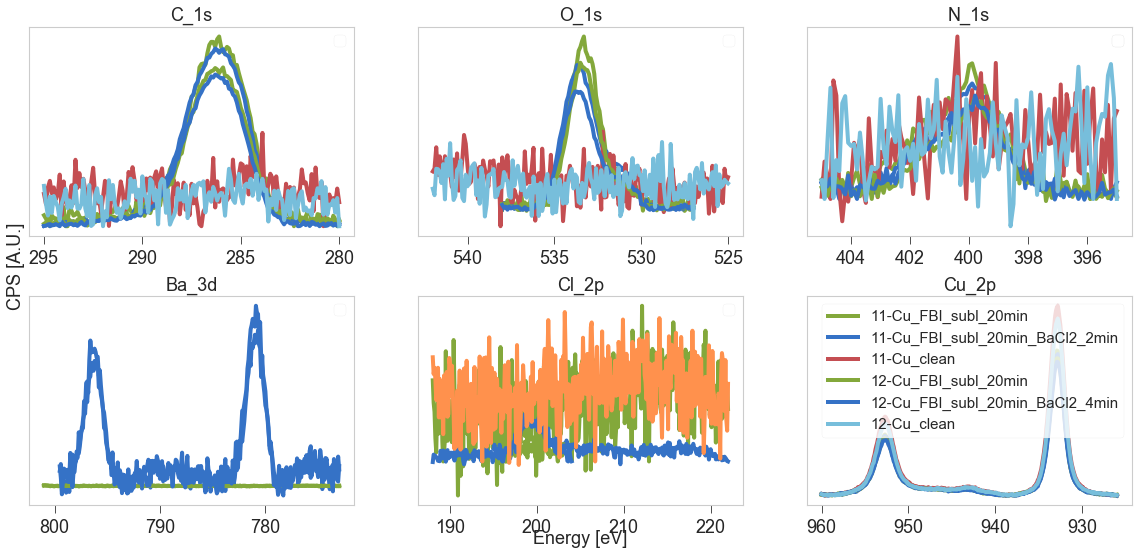

In [47]:
regs = ['C_1s', 'O_1s', 'N_1s', 'Ba_3d', 'Cl_2p', 'Cu_2p']

plot_xp_regions(samp12, regs, ncols=3);
# plt.gcf().savefig('/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_26_Cu/Unscaled_exps.png', dpi=200)

## Coverages

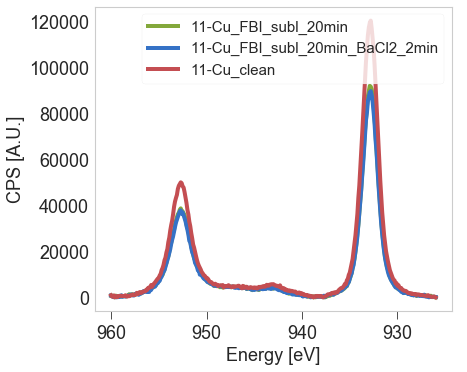

In [163]:
region = 'Cu_2p'
for xp in samp12[:3]:
    plot_region(xp, region)

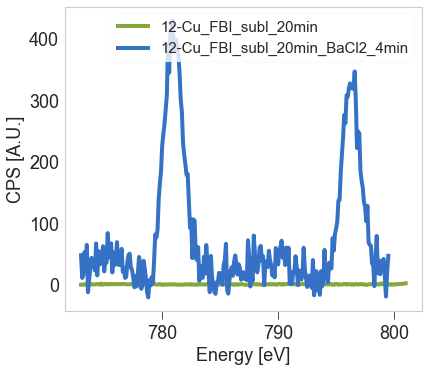

In [166]:
region = 'Ba_3d'
for xp in samp12[3:5]:
    plot_region(xp, region)

'Ba_3d' region does not exist in 11-Cu_clean
'Ba_3d' region does not exist in 12-Cu_clean


[16.87150103705865, 1714.9839263259396, 13.624075755138687, 1850.996223628866]

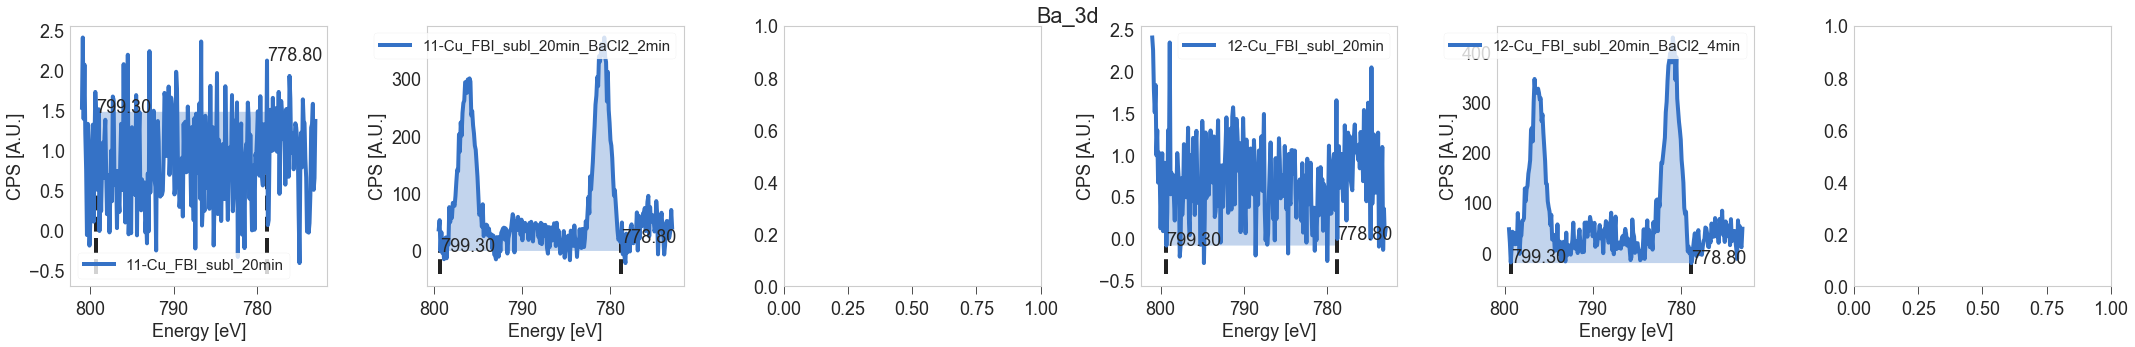

In [168]:
integrateRegions(samp12, 'Ba_3d', asf)

In [172]:
samp17[2].name

'FBI_60min_BaCl2_1min'

In [174]:
samp17[2].area['Ba_3d'] / samp12[1].area['Ba_3d']

6.230412772981911

In [176]:
samp17[2].area['layers'] / samp12[1].area['layers']

8.83998783554938

In [148]:
# Coverage with FBI: IMFP = 1.86 nm
inds = [[0, 2], [3, 5]]
layers_fbi = arrange_coverages(samp12, inds,
                               r_ml = 1.1*nm, region='Cu_2p', mfp = 1.86*nm, takeoff = 10)

# Coverage with BaCl2: IMFP = 1.35 nm
# Take previous stage (only FBI) as reference
inds = [[1, 0], [4, 3]]
layers_fbi = arrange_coverages(samp12, inds,
                               r_ml = 1*nm, region='Cu_2p', mfp = 1.35*nm, takeoff = 10)

# Add thickness of reference layer
# samp12[1].area['layers'] += samp12[0].area['layers']
# samp12[4].area['layers'] += samp12[0].area['layers']          

In [149]:
samp12[0].area['layers'], samp12[3].area['layers']

(0.5011053158895734, 0.44898825976914586)

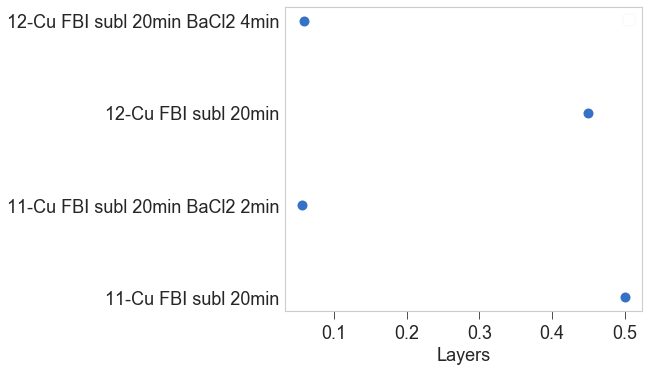

In [150]:
plot_coverages(samp12)

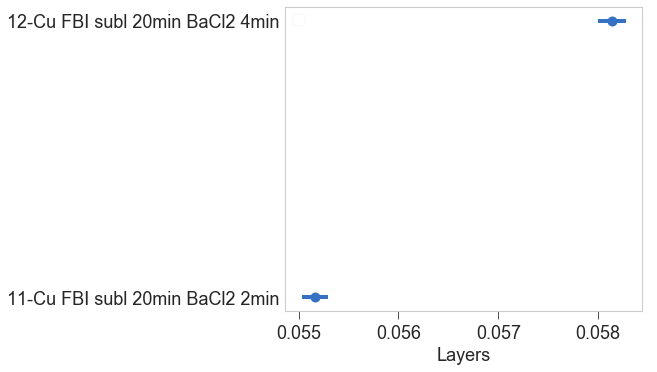

In [151]:
plot_coverages([samp12[1], samp12[4]])

## Fits

Modify user pars
Modify user pars
Modify user pars
Modify user pars


Text(799, 427.9273438904236, 'Ba 4d')

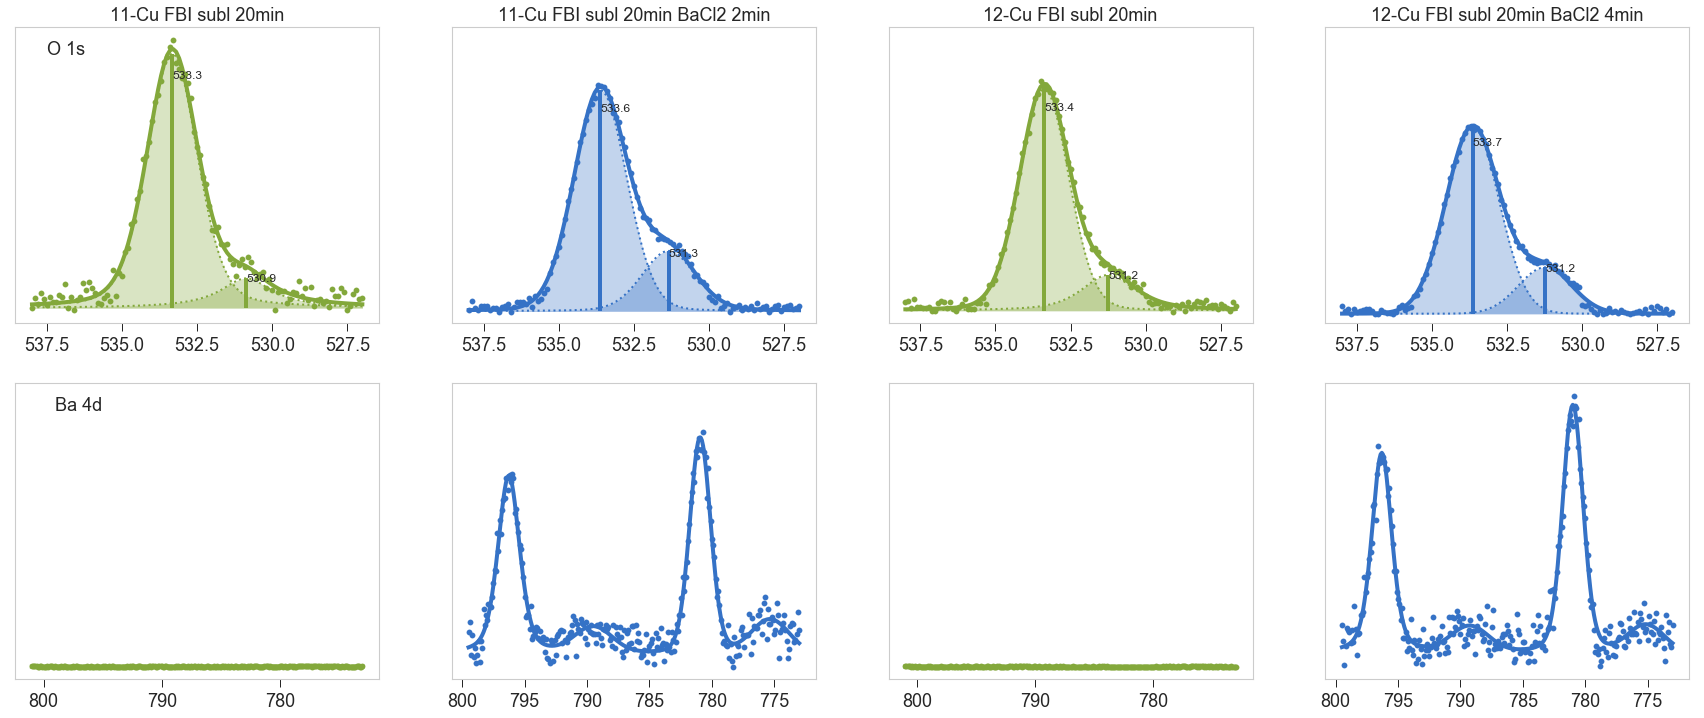

In [90]:
fig, ax = plt.subplots(2, 4, sharex=False, figsize=(30, 12), )

selection = [samp12[0], samp12[1], samp12[3], samp12[4]]
r = 'O_1s'
for i, xp in enumerate(selection):
    Fn = XPFit(xp, region = r)
    Fn.preset_pars('v1_sigma', 1.0421)
    Fn.double_voigt(sepPt=532)

    plot_fit_result(xp, r, fitRes=xp.fit[r], ax=ax[0][i], offset=0,
                    flag_fill=True, plot_comps=True)
    ax[0][i].set(title=xp.name.replace('_', ' '), xlabel='', ylabel='', yticks=[], 
                 ylim=(ax[0][i].get_ylim()[0], ax[0][0].get_ylim()[1]))
    ax[0][i].invert_xaxis()
    ax[0][i].tick_params('both', length=8, width=1, which='major')
ax[0][0].text(s='O 1s', x=537.5, y=ax[0][1].get_ylim()[1]*0.9)

r = 'Ba_3d'
li, _ = plot_fit_result(samp12[4], r, fitRes=samp12[4].fit[r], ax=ax[1][3], flag_fill=True, plot_comps=False)
lim = li.get_ylim()
ax[1][3].cla()
for i,xp in enumerate(selection):
    Fn = XPFit(xp, region = r)
#     Fn.double_voigt()

    li = plot_fit_result(xp, r, fitRes=xp.fit[r], ax=ax[1][i], flag_fill=True, plot_comps=False)
    ax[1][i].set(xlabel='', ylabel='', yticks=[], ylim=lim)
    ax[1][i].invert_xaxis()
    ax[1][i].tick_params('both', length=8, width=1, which='major',)
ax[1][0].text(s='Ba 4d', x=799, y=lim[1]*0.9)
# plt.tight_layout(w_pad=0.5, h_pad=0.5, pad=0.1)
# ax[0][0].legend(list(li.get_lines()), labels = [xp.name for xp in samp12[:0:-1]], ncol=len(selection),
#             loc="upper left", bbox_to_anchor=(0.1, 1.2))  

In [91]:
for xp in samp12:
    print(xp.fit['O_1s'].best_values['v1_sigma'])

1.0421
1.0421
14.141694101617695
1.0421
1.0421
8.045951787333934


In [92]:
area_big = []
for xp in selection[1:4:2]:
    print(xp.name)
    print(xp.area['O_1s_v1_'])
    print(xp.area['O_1s_v2_'])
    
    area_big.append(xp.area['O_1s_v1_'])
# area_big.append(selection[4].area['O_1s_v1_'])

11-Cu_FBI_subl_20min_BaCl2_2min
0.20136842799150967
0.7986315720084903
12-Cu_FBI_subl_20min_BaCl2_4min
0.1826111498546721
0.8173888501453278


### Plot O_v1 vs subl Ba

Text(0, 0.5, 'Area O*-Ba / Total O 1s area')

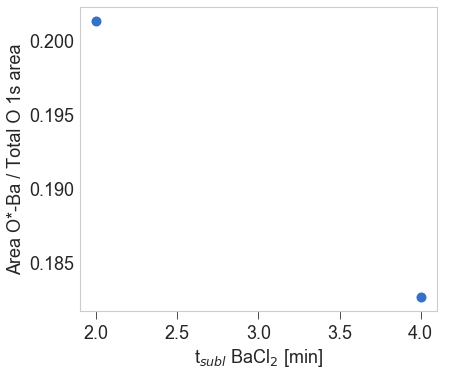

In [93]:
tsubl = [2, 4]
plt.plot(tsubl, area_big, 'o', markersize=10)
plt.xlabel('t$_{subl}$ BaCl$_2$ [min]')
plt.ylabel('Area O*-Ba / Total O 1s area')

In [91]:
for xp in samp12:
    write_processed_xp(xp.path, xp)

Storing of file /Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_02_01_Cu/proc/20210201_11-Cu_FBI_subl_20min.uxy.ft successful
Storing of file /Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_02_01_Cu/proc/20210201_11-Cu_FBI_subl_20min_BaCl2_2min.uxy.ft successful
Storing of file /Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_02_01_Cu/proc/20210201_11-Cu_clean.uxy.ft successful
Storing of file /Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_02_02_Cu/proc/20210202_12-Cu_FBI_subl_20min.uxy.ft successful
Storing of file /Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_02_02_Cu/proc/20210202_12-Cu_FBI_subl_20min_BaCl2_4min.uxy.ft successful
Storing of file /Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_02_02_Cu/proc/20210202_12-Cu_clean.uxy.ft successful


# Sample 13 from Febr '21

In [69]:
path = '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_02_03*/**/*.uxy'

files = glob.glob(path, recursive=True)
files.sort()
file_clean = files[-1]
files[1:] = files[:-1]
files[0] = file_clean
files

['/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_02_03_Cu/proc/20210203_13-Cu_clean.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_02_03_Cu/proc/20210203_13-Cu_FBI_subl_60min.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_02_03_Cu/proc/20210203_13-Cu_FBI_subl_60min_BaCl2_04min.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_02_03_Cu/proc/20210203_13-Cu_FBI_subl_60min_BaCl2_08min.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_02_03_Cu/proc/20210203_13-Cu_FBI_subl_60min_BaCl2_12min.uxy']

In [70]:
samp13 = [read_processed_xp(f) for f in files]

for xp in samp13:
#     xp.name = xp.name.replace('17-Cu_','').replace('subl_','')
    xp.name = deepcopy(xp.other_meta)

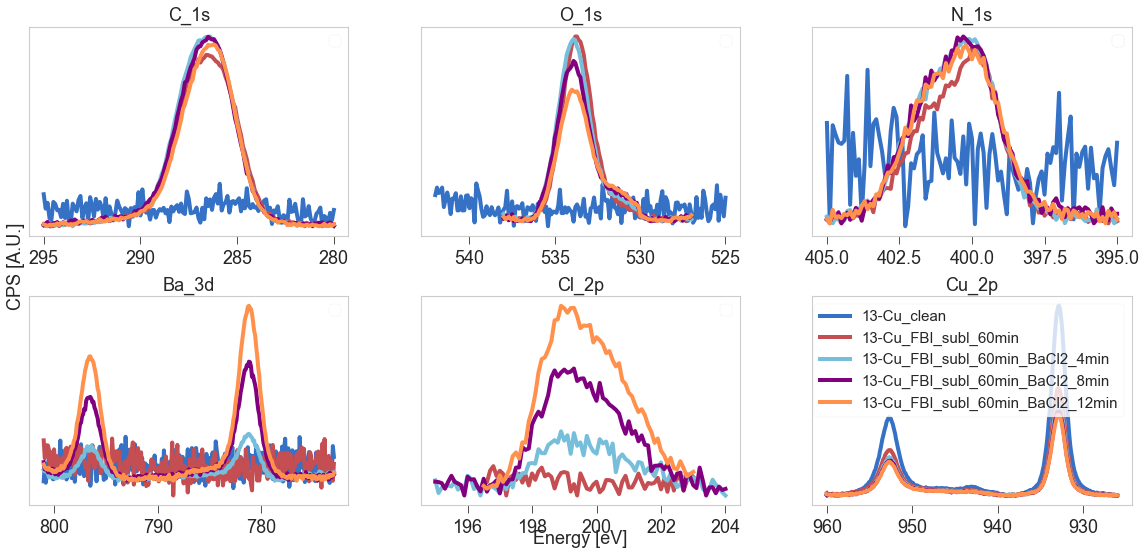

In [71]:
regs = ['C_1s', 'O_1s', 'N_1s', 'Ba_3d', 'Cl_2p', 'Cu_2p']

plot_xp_regions(samp13, regs, ncols=3);
# plt.gcf().savefig('/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_26_Cu/Unscaled_exps.png', dpi=200)

## Coverages

In [72]:
# Coverage with FBI: IMFP = 1.86 nm
inds = [[1, 0]]
layers_fbi = arrange_coverages(samp13, inds,
                               r_ml = 1.1*nm, region='Cu_2p', mfp = 1.86*nm, takeoff = 10)

# Coverage with BaCl2: IMFP = 1.35 nm
# Take previous stage (only FBI) as reference
inds = [[2, 3, 4, 1]]
layers_fbi = arrange_coverages(samp13, inds,
                               r_ml = 1*nm, region='Cu_2p', mfp = 1.35*nm, takeoff = 10)

# Add thickness of reference layer
# for xp in samp13[2:]:
#     xp.area['layers'] += samp13[1].area['layers']

In [37]:
n_layers(samp13[1], samp13[0],
       r_ml = 1.1*nm, region='Cu_2p', mfp = 1.86*nm, takeoff = 10)

(0.899023390302803, 0.002256720857865622)

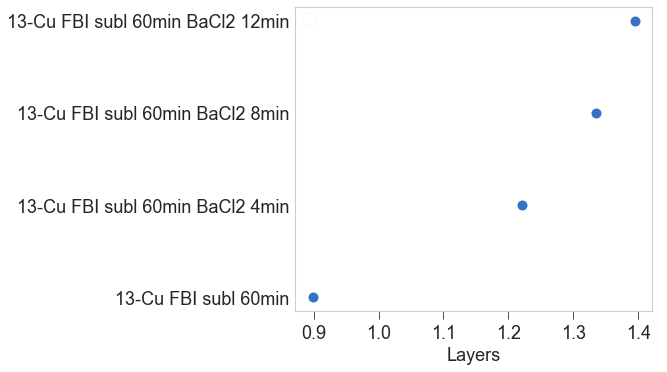

In [39]:
plot_coverages(samp13)

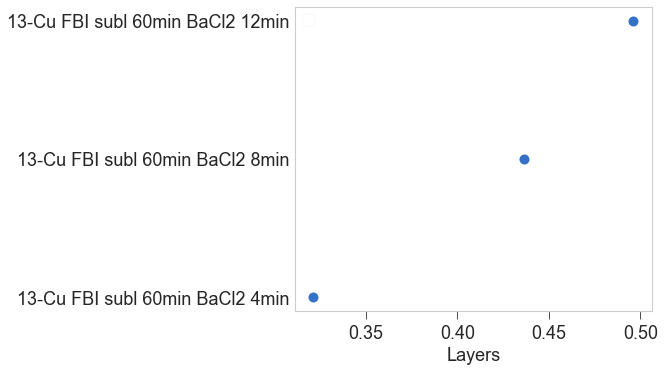

In [73]:
plot_coverages(samp13[2:])

## Fits

Modify user pars
Modify user pars
Modify user pars
Modify user pars


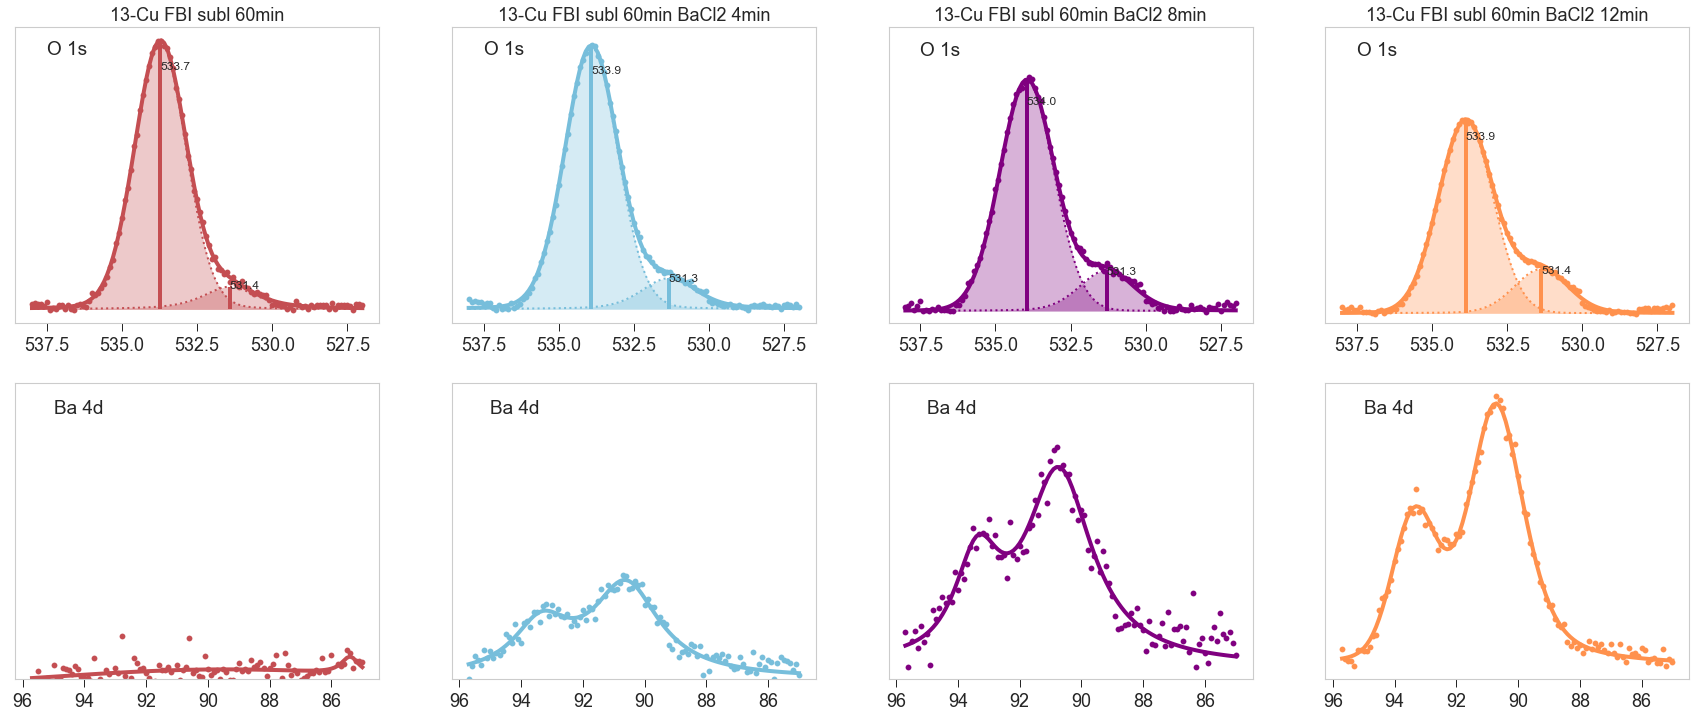

In [121]:
fig, ax = plt.subplots(2, 4, sharex=False, figsize=(30, 12), )

r = 'O_1s'
for i, xp in enumerate(samp13[1:]):
    Fn = XPFit(xp, region = r)
    Fn.preset_pars('v1_sigma', 1.0587)
    Fn.double_voigt(sepPt=532)
    plot_fit_result(xp, r, fitRes=xp.fit[r], ax=ax[0][i], offset=0,
                    flag_fill=True, plot_comps=True)
    ax[0][i].set(title=xp.name.replace('_', ' '), xlabel='', ylabel='', yticks=[], 
                 ylim=(ax[0][i].get_ylim()[0], ax[0][0].get_ylim()[1]))
    ax[0][i].invert_xaxis()
    ax[0][i].tick_params('both', length=8, width=1, which='major')
    ax[0][i].text(s='O 1s', x=537.5, y=ax[0][0].get_ylim()[1]*0.9, fontsize=19)

r = 'Ba_4d'
li, _ = plot_fit_result(samp13[4], r, fitRes=samp13[4].fit[r], ax=ax[1][3], flag_fill=True, plot_comps=False)
lim = li.get_ylim()
ax[1][3].cla()
for i,xp in enumerate(samp13[1:]):
    Fn = XPFit(xp, region = r)
#     Fn.double_voigt()

    li = plot_fit_result(xp, r, fitRes=xp.fit[r], ax=ax[1][i], flag_fill=True, plot_comps=False)
    ax[1][i].set(xlabel='', ylabel='', yticks=[], ylim=lim)
    ax[1][i].invert_xaxis()
    ax[1][i].tick_params('both', length=8, width=1, which='major',)
    ax[1][i].text(s='Ba 4d', x=95, y=lim[1]*0.9, fontsize=19)
# plt.tight_layout(w_pad=0.5, h_pad=0.5, pad=0.1)
# ax[0][0].legend(list(li.get_lines()), labels = [xp.name for xp in samp13[:0:-1]], ncol=len(selection),
#             loc="upper left", bbox_to_anchor=(0.1, 1.2))  

In [77]:
for xp in samp13[1:]:
    print(xp.fit['O_1s'].best_values['v1_sigma'])

1.0587118065760728
1.0734324499996668
1.0375794446808904
1.0433869350117546


In [80]:
area_big = []
for xp in samp13[1:]:
    area_big.append(xp.area['O_1s_v1_'])
# area_big.append(selection[4].area['O_1s_v1_'])

### Plot O_v1 vs subl Ba

Text(0, 0.5, 'Area O*-Ba / Total O 1s area')

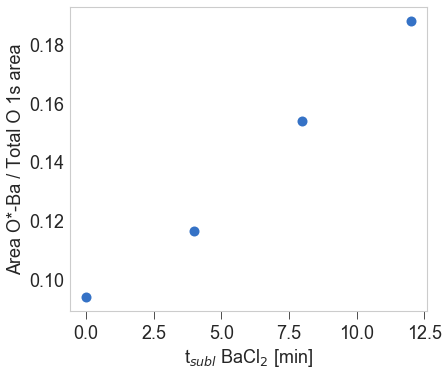

In [81]:
tsubl = [0, 4, 8, 12]
plt.plot(tsubl, area_big, 'o', markersize=10)
plt.xlabel('t$_{subl}$ BaCl$_2$ [min]')
plt.ylabel('Area O*-Ba / Total O 1s area')

In [84]:
for xp in samp13:
    write_processed_xp(xp.path, xp)

Storing of file /Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_02_03_Cu/proc/20210203_13-Cu_clean.uxy.ft successful
Storing of file /Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_02_03_Cu/proc/20210203_13-Cu_FBI_subl_60min.uxy.ft successful
Storing of file /Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_02_03_Cu/proc/20210203_13-Cu_FBI_subl_60min_BaCl2_04min.uxy.ft successful
Storing of file /Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_02_03_Cu/proc/20210203_13-Cu_FBI_subl_60min_BaCl2_08min.uxy.ft successful
Storing of file /Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_02_03_Cu/proc/20210203_13-Cu_FBI_subl_60min_BaCl2_12min.uxy.ft successful


# Sample 15 from April '21

In [48]:
path = '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_*/**/*.uxy'

files = glob.glob(path, recursive=True)
files.sort()
files[0], files[3] = files[3], files[0]
files

['/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_12_Cu/proc/20210413_16-Cu_FBI_subl_8min.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_12_Cu/proc/20210413_16-Cu_FBI_subl_15min.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_12_Cu/proc/20210413_16-Cu_FBI_subl_22min.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_12_Cu/proc/20210412_16-Cu_clean.uxy']

In [49]:
xpfbi = [read_processed_xp(f) for f in files]

[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_12_Cu/proc/20210413_16-Cu_FBI_subl_8min.uxy.ft', returning empty fit dict
[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_12_Cu/proc/20210413_16-Cu_FBI_subl_15min.uxy.ft', returning empty fit dict
[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_12_Cu/proc/20210413_16-Cu_FBI_subl_22min.uxy.ft', returning empty fit dict
[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_12_Cu/proc/20210412_16-Cu_clean.uxy.ft', returning empty fit dict


In [39]:
for xp in xpfbi:
    write_processed_xp(xp.path, xp)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a21be02e8>,
      dtype=object)

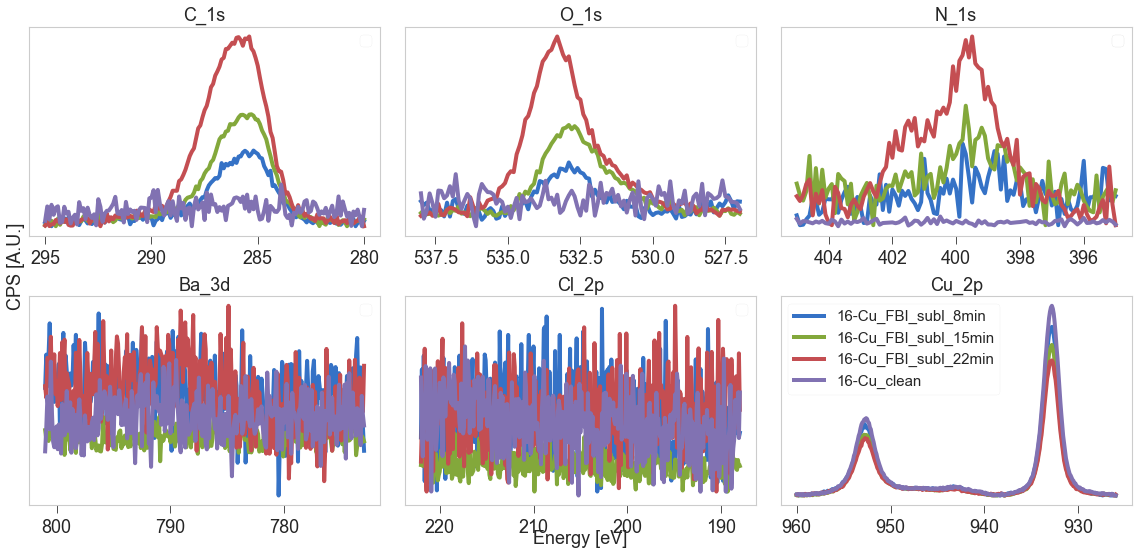

In [50]:
regs = ['C_1s', 'O_1s', 'N_1s', 'Ba_3d', 'Cl_2p', 'Cu_2p']

plot_xp_regions(xpfbi, regs, ncols=3)

In [51]:
inds = [[0, 1, 2, 3]]

layers_fbi = arrange_coverages(xpfbi, inds,
                               r_ml = 1.1*nm, region='Cu_2p', mfp = 1.86*nm, takeoff = 10)


In [34]:
def arrange_coverages(experiments: list, inds: list,
                      r_ml: float, region: str, mfp: float, takeoff: float)->np.matrix:
    """Estimate n_layers for a list of experiments following the indices inds
    Parameters:
     - experiments: list of XPS_experiment to look into
     - inds: list of indices. It must be arranged such that each set of measurements
             has its reference (clean substrate) index at the end of each list.
             Example:  inds = [[0,1,2,3,5,7,8, 4], [9, 10]]
             will take experiments[4] as clean_substrate, and compute the thickness of experiments[0],
             experiments[1], experiments[2]... Then it will take experiments[10] as clean_substrate and
             compute the thickness for experiments[9]
     - all other params must be passed as for n_layers
    Returns:
    layers_res: matrix (M x 2), with column 0 is the mean value of n_layers and column 1 its error, and
    where M is the number of experiments passed for computation.
    """
    layers_res = []
    for lref in inds:
        for li in lref[:-1]:
            lay, dlay = n_layers(xpf=experiments[li], xp0=experiments[lref[-1]],
                                           r_ml = r_ml, region=region, mfp=mfp, takeoff=takeoff) 
            experiments[li].area['layers'] = lay
            experiments[li].area['dlayers'] = dlay
            
            layers_res.append((lay, dlay))
    layers_res = np.matrix(layers_res)
    return layers_res

def plot_coverages(experiments):
    layers, dlayers = [], []
    names = []
    for xp in experiments:
        try:
            layers.append(xp.area['layers'])
            dlayers.append(xp.area['dlayers'])
            names.append(xp.name)
        except KeyError:
            pass

    ax = plt.gca()
    ax.errorbar(x=names, y=layers, yerr=dlayers, fmt='o', label='Rate $R_0$')

    ax.set_ylabel('Layers')
    ax.legend()

In [52]:
xpfbi[1].area

{'layers': 0.4628315389625579, 'dlayers': 0.0014838314051838835}

In [56]:
for xp in xpfbi:
    xp.name = xp.name.replace('16-Cu_FBI_subl', '')

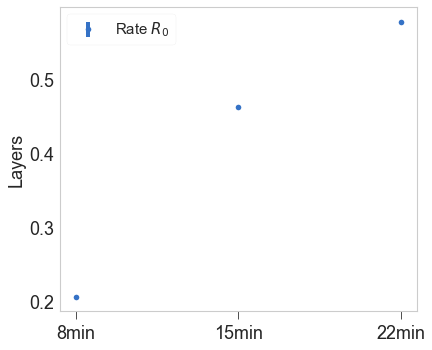

In [57]:
plot_coverages(xpfbi)

# Sample 16 from april 21st

In [68]:
path = '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_21*/**/*.uxy'

files = glob.glob(path, recursive=True)
files.sort()
file_clean = files[-1]
files[1:] = files[:-1]
files[0] = file_clean
files

['/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_21_Cu/proc/20210421_16-Cu_clean.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_21_Cu/proc/20210421_16-Cu_FBI_subl_22min.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_21_Cu/proc/20210421_16-Cu_FBI_subl_22min_BaCl2_1min.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_21_Cu/proc/20210421_16-Cu_FBI_subl_22min_BaCl2_2min.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_21_Cu/proc/20210421_16-Cu_FBI_subl_22min_BaCl2_6min.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_21_Cu/proc/20210421_16-Cu_FBI_subl_22min_BaCl2_6min_200grad.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_21_Cu/proc/20210421_16-Cu_FBI_subl_22min_BaCl2_6min_250grad.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_21_Cu/proc/20210421_16-Cu_FBI_subl_22min_BaCl2_6min_300grad.uxy']

In [34]:
subml = [read_processed_xp(f) for f in files]
for xp in subml:
    xp.name = xp.name.replace('17-Cu_','').replace('subl_','')

[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_21_Cu/proc/20210421_16-Cu_clean.uxy.ft', returning empty fit dict
[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_21_Cu/proc/20210421_16-Cu_FBI_subl_22min_BaCl2_6min_200grad.uxy.ft', returning empty fit dict
[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_21_Cu/proc/20210421_16-Cu_FBI_subl_22min_BaCl2_6min_300grad.uxy.ft', returning empty fit dict


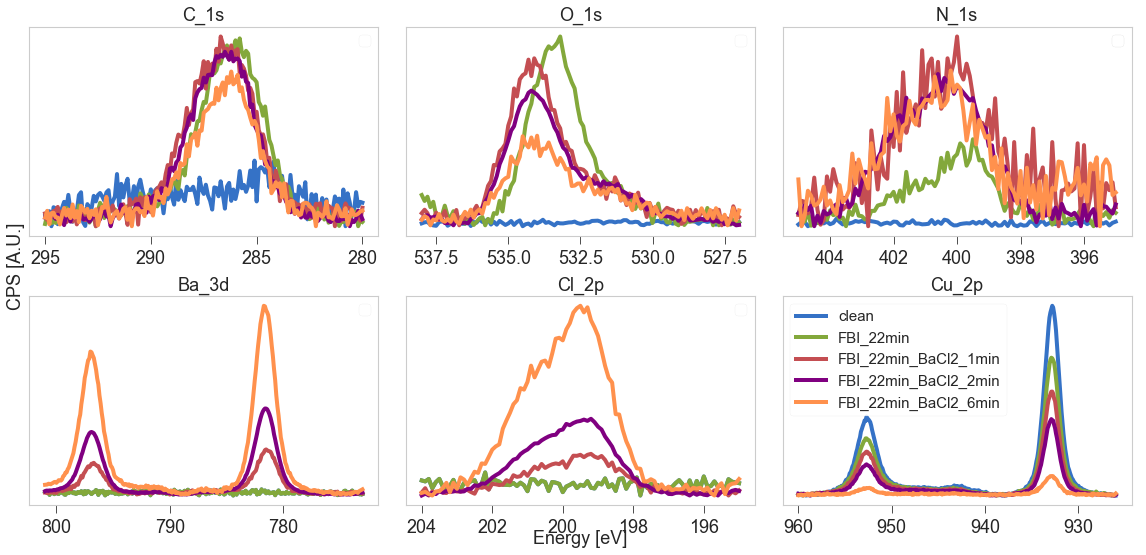

In [7]:
regs = ['C_1s', 'O_1s', 'N_1s', 'Ba_3d', 'Cl_2p', 'Cu_2p']

plot_xp_regions(subml[:5], regs, ncols=3);
# plt.gcf().savefig('/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/Unscaled_exps.png', dpi=200)

In [384]:
col = ['y', 'c', 'brown', 'k']
for i, xp in enumerate(subml[4:]):
    xp.name = xp.name.replace('22min_', '').replace('grad', 'ºC')
    xp.color = col[i]

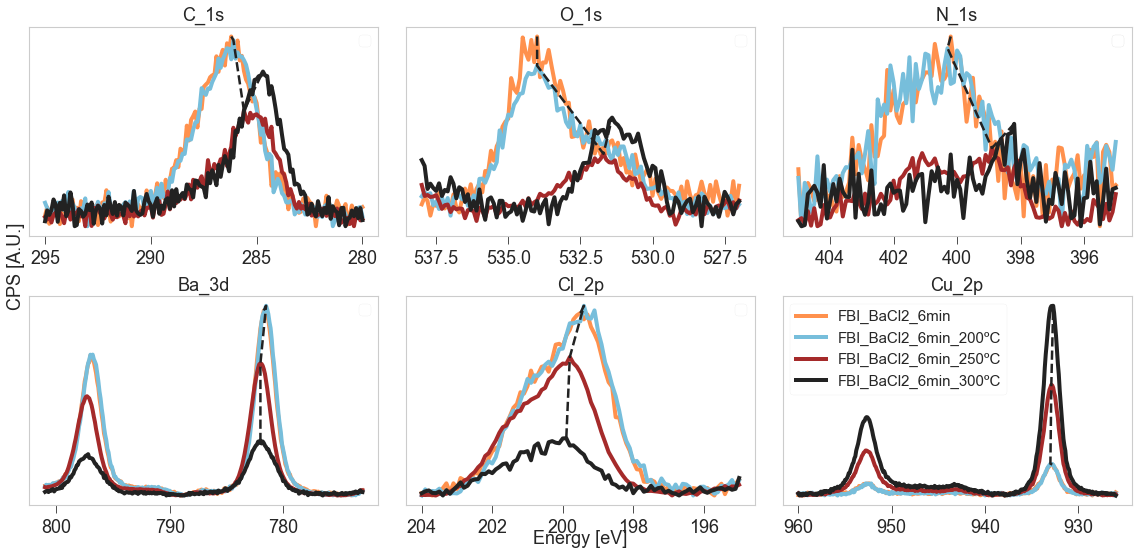

In [387]:
regs = ['C_1s', 'O_1s', 'N_1s', 'Ba_3d', 'Cl_2p', 'Cu_2p']

plot_xp_regions(subml[4:], regs, ncols=3, flag_shift=True);
# plt.gcf().savefig('/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/Unscaled_exps_anneal.png', dpi=200)

In [461]:
for r in regs+ ['Ba_4d']:
    enmx = []
    comx = []
    for xp in subml[5:]:
        argmx = np.argmax(xp.dfx[r].counts)
        enmx.append(xp.dfx[r].energy.loc[argmx])
        comx.append(xp.dfx[r].counts.loc[argmx])
    print(r, enmx[0] - enmx[2])

C_1s 1.400000000000034
O_1s 2.6000000000000227
N_1s 2.1000000000000227
Ba_3d -0.5
Cl_2p -0.5
Cu_2p 0.2999999999999545
Ba_4d -0.8000000000000114


## Stoichiometry

'Ba_4d' region does not exist in clean


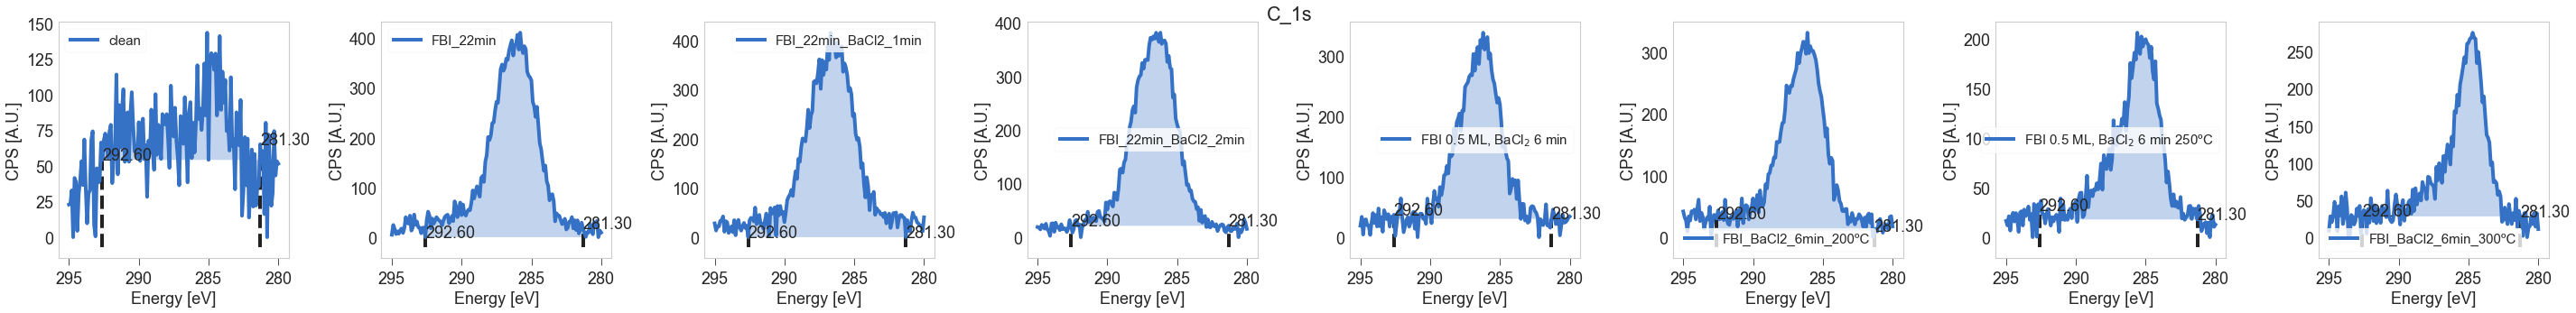

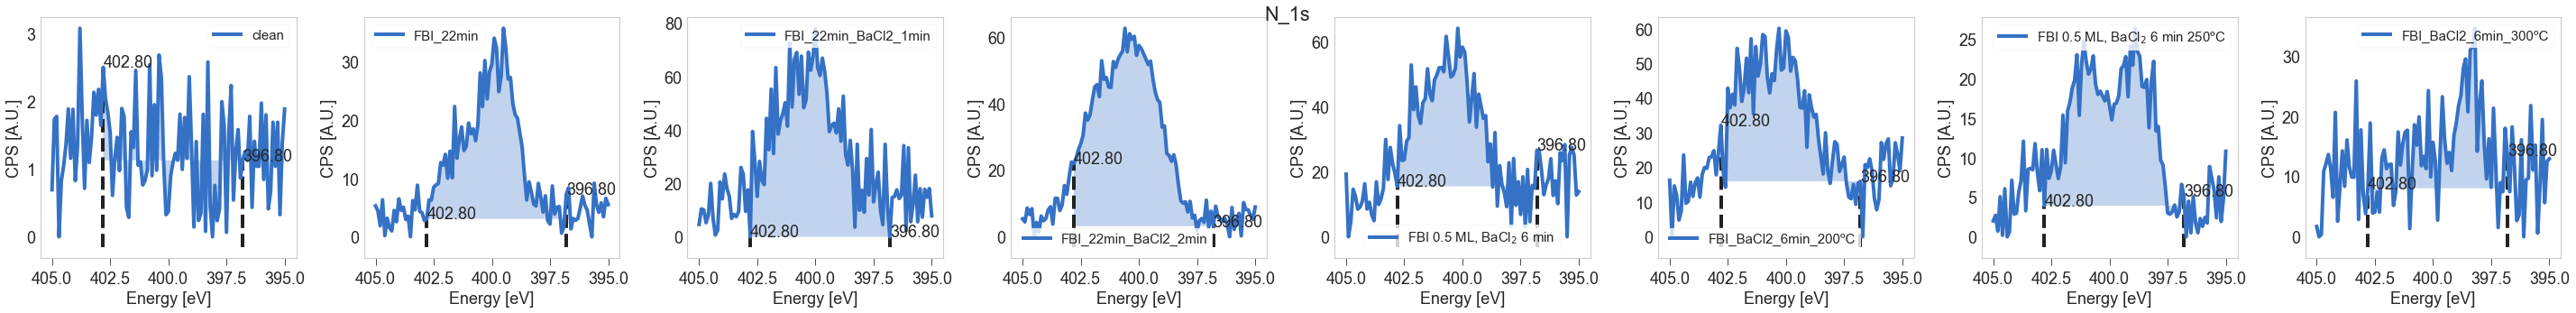

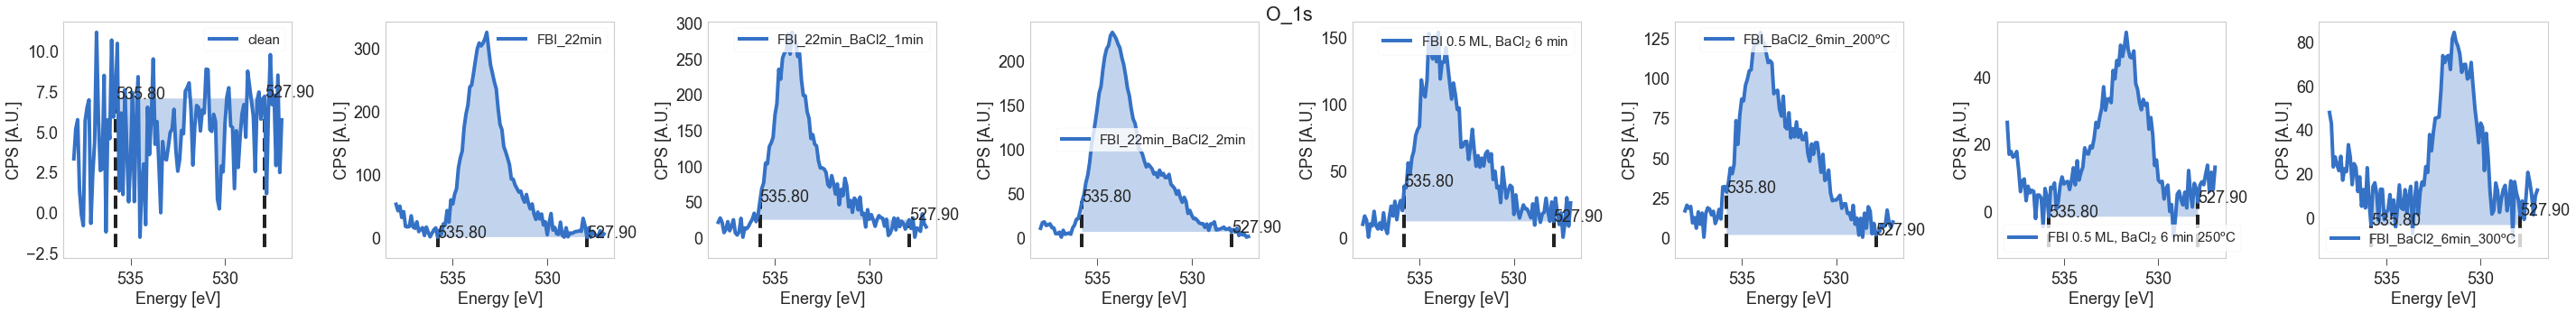

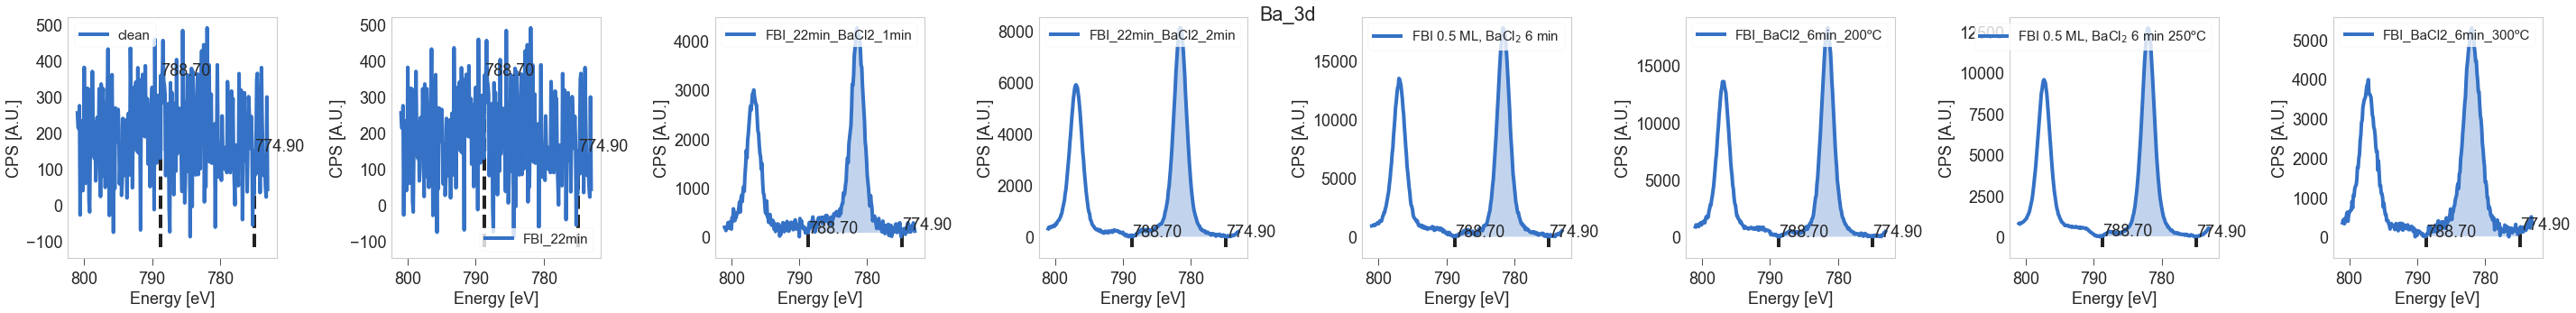

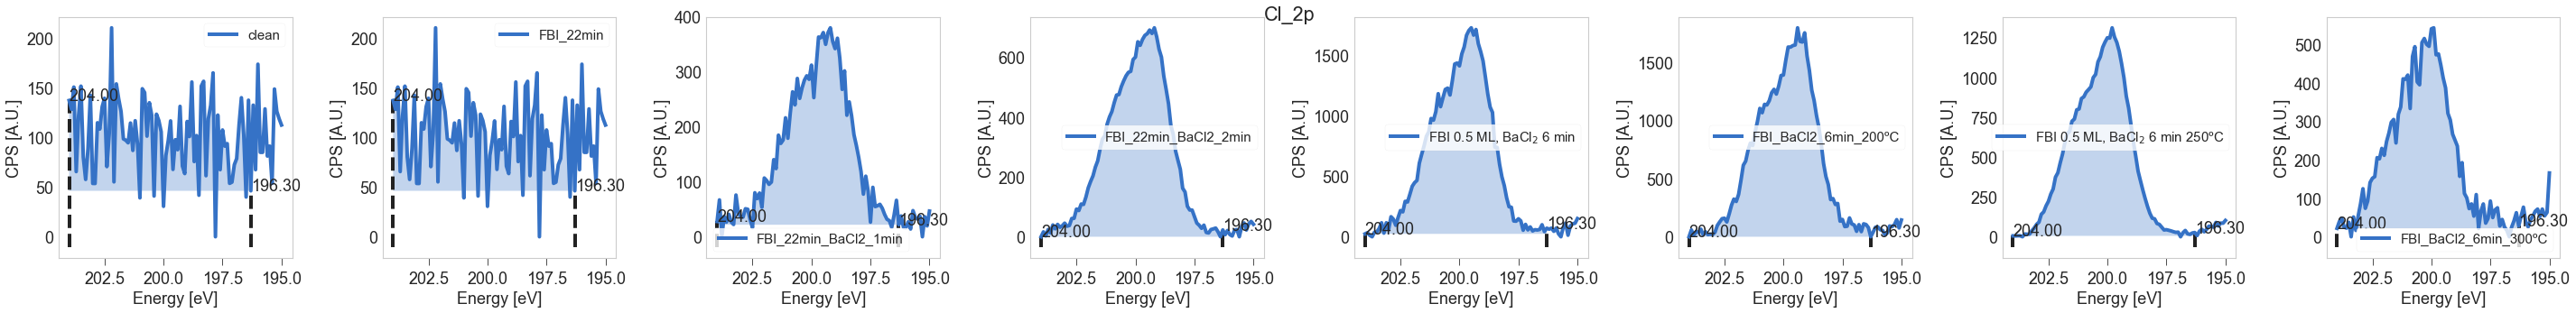

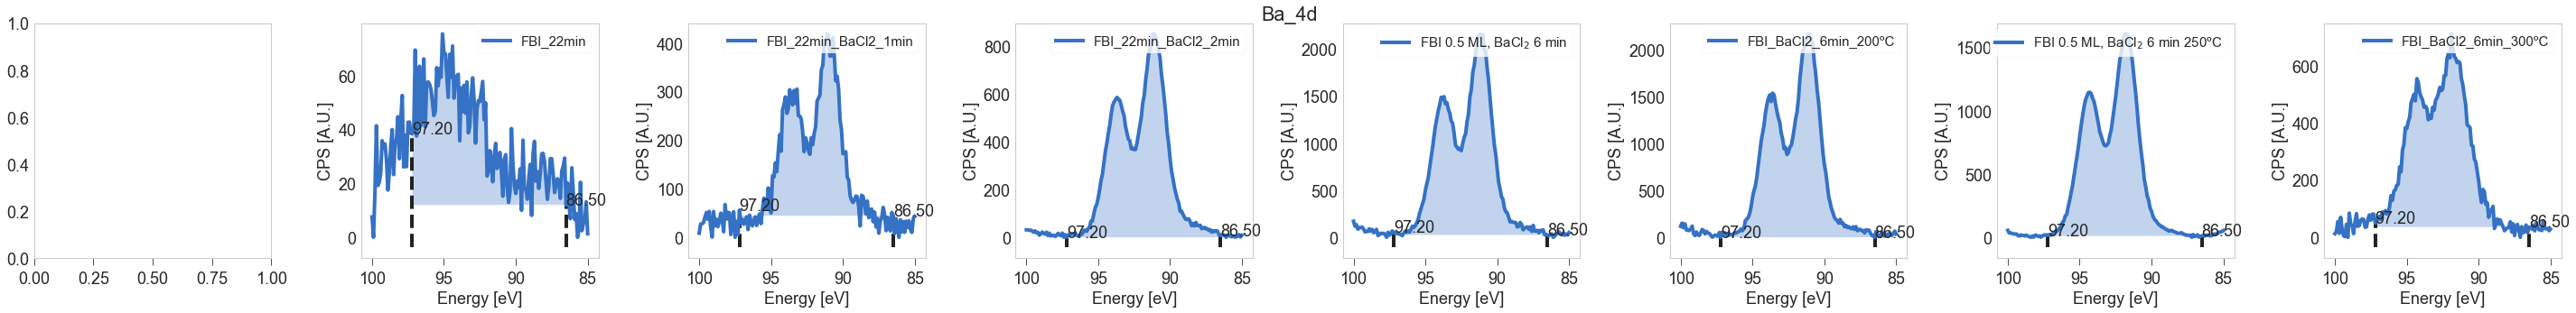

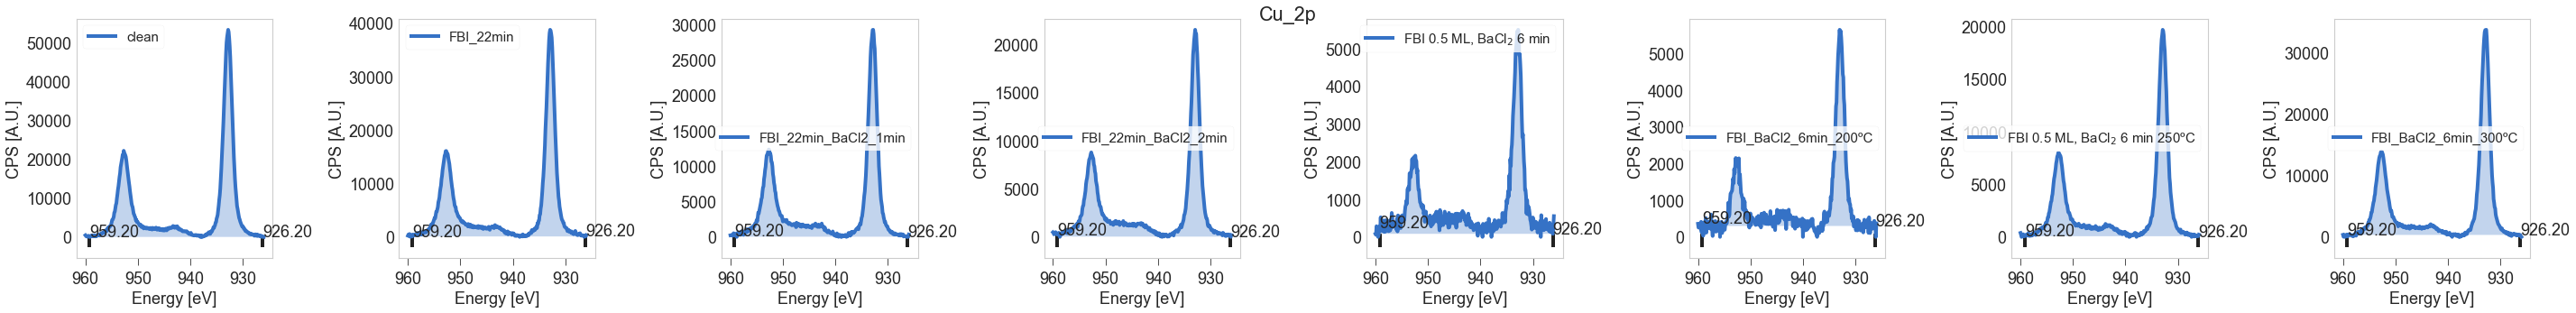

In [478]:
regions = ['C_1s', 'N_1s', 'O_1s', 'Ba_3d', 'Cl_2p', 'Ba_4d', 'Cu_2p']#, 'Ba3d', 'Cl2p', 'Ba4d']

for i,r in enumerate(regions):
    integrateRegions(subml, region=r, asf=asf)#, indRef=indRefs[i])


[5393.288758828598,
 5393.288758828598,
 21798.629287139738,
 37415.80971800347,
 83198.04483211024,
 83427.09582605082,
 59756.638047610875,
 31006.37864443253]

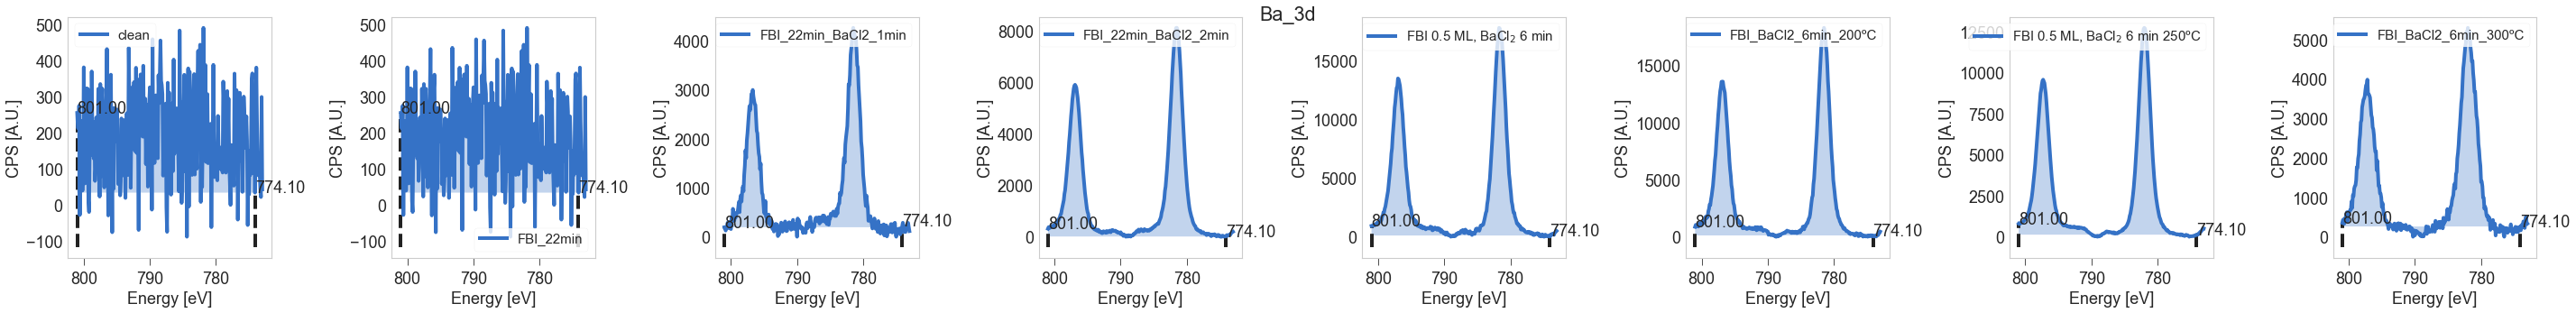

In [475]:
integrateRegions(subml, 'Ba_3d', asf, eup=802, edw=774.1)

In [476]:
num, denom = (('N_1s', 'C_1s', 'C_1s' ), ('O_1s', 'N_1s', 'O_1s',))
make_stoichometry_table(subml,  num=num, denom=denom, sep=' \t ')

num, denom = ('N_1s', 'Cl_2p'), ( 'Ba_3d', 'Ba_3d')
make_stoichometry_table(subml,  num=num, denom=denom, sep=' \t ')


Experiment	N_/O_	C_/N_	C_/O_	
clean 	 0.28  	  184.39  	  51.32  	  
FBI_22min 	 0.17  	  28.83  	  5.00  	  
FBI_22min_BaCl2_1min 	 0.45  	  11.79  	  5.25  	  
FBI_22min_BaCl2_2min 	 0.45  	  12.21  	  5.48  	  
FBI 0.5 ML, BaCl$_2$ 6 min 	 0.60  	  10.51  	  6.33  	  
FBI_BaCl2_6min_200ºC 	 0.72  	  9.63  	  6.94  	  
FBI 0.5 ML, BaCl$_2$ 6 min 250ºC 	 0.90  	  14.68  	  13.22  	  
FBI_BaCl2_6min_300ºC 	 0.61  	  18.24  	  11.10  	  
Experiment	N_/Ba_	Cl_/Ba_	
clean 	 0.02  	  1.22  	  
FBI_22min 	 0.27  	  1.22  	  
FBI_22min_BaCl2_1min 	 0.17  	  0.46  	  
FBI_22min_BaCl2_2min 	 0.09  	  0.46  	  
FBI 0.5 ML, BaCl$_2$ 6 min 	 0.04  	  0.49  	  
FBI_BaCl2_6min_200ºC 	 0.04  	  0.50  	  
FBI 0.5 ML, BaCl$_2$ 6 min 250ºC 	 0.02  	  0.49  	  
FBI_BaCl2_6min_300ºC 	 0.05  	  0.43  	  


## Coverages

In [41]:
# Coverage with FBI: IMFP = 1.86 nm
inds = [[1, 2, 0]]
layers_fbi = arrange_coverages(subml, inds,
                               r_ml = 1.1*nm, region='Cu_2p', mfp = 1.86*nm, takeoff = 10)

# Coverage with BaCl2: IMFP = 1.35 nm
# Take previous stage (only FBI) as reference
inds = [[2, 3, 4, 5, 6, 7, 1]]
layers_fbi = arrange_coverages(subml, inds,
                               r_ml = 1*nm, region='Cu_2p', mfp = 1.35*nm, takeoff = 10)

# Add thickness of reference layer
# for xp in subml[2:]:
#     xp.area['layers'] += subml[1].area['layers']

In [466]:
n_layers(subml[1], subml[0],
       r_ml = 1.1*nm, region='Cu_2p', mfp = 1.86*nm, takeoff = 10)

(-6.5492799524020615, -0.03723991176291924)

In [479]:
subml[1].area['Cu_2p'], subml[0].area['Cu_2p']

(29248.261144679513, 38877.82720851339)

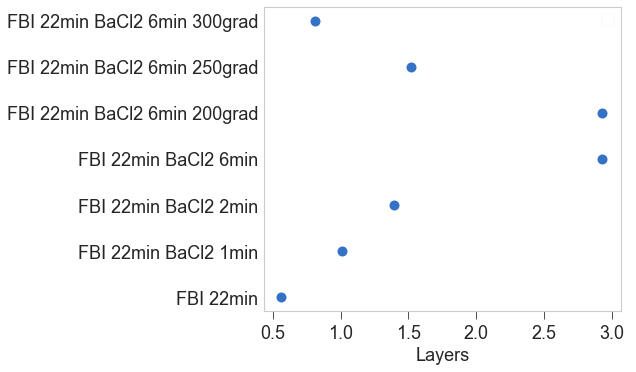

In [40]:
plot_coverages(subml)

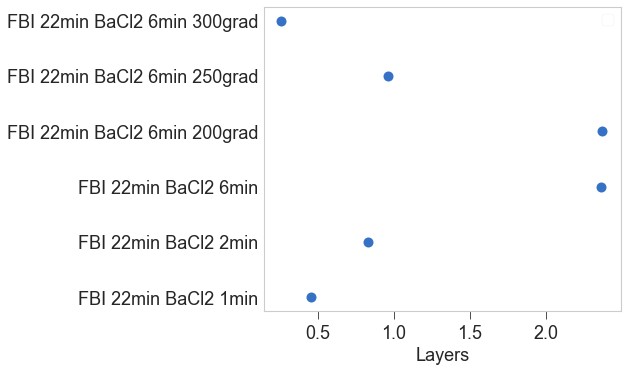

In [43]:
plot_coverages(subml[2:])

## Fits

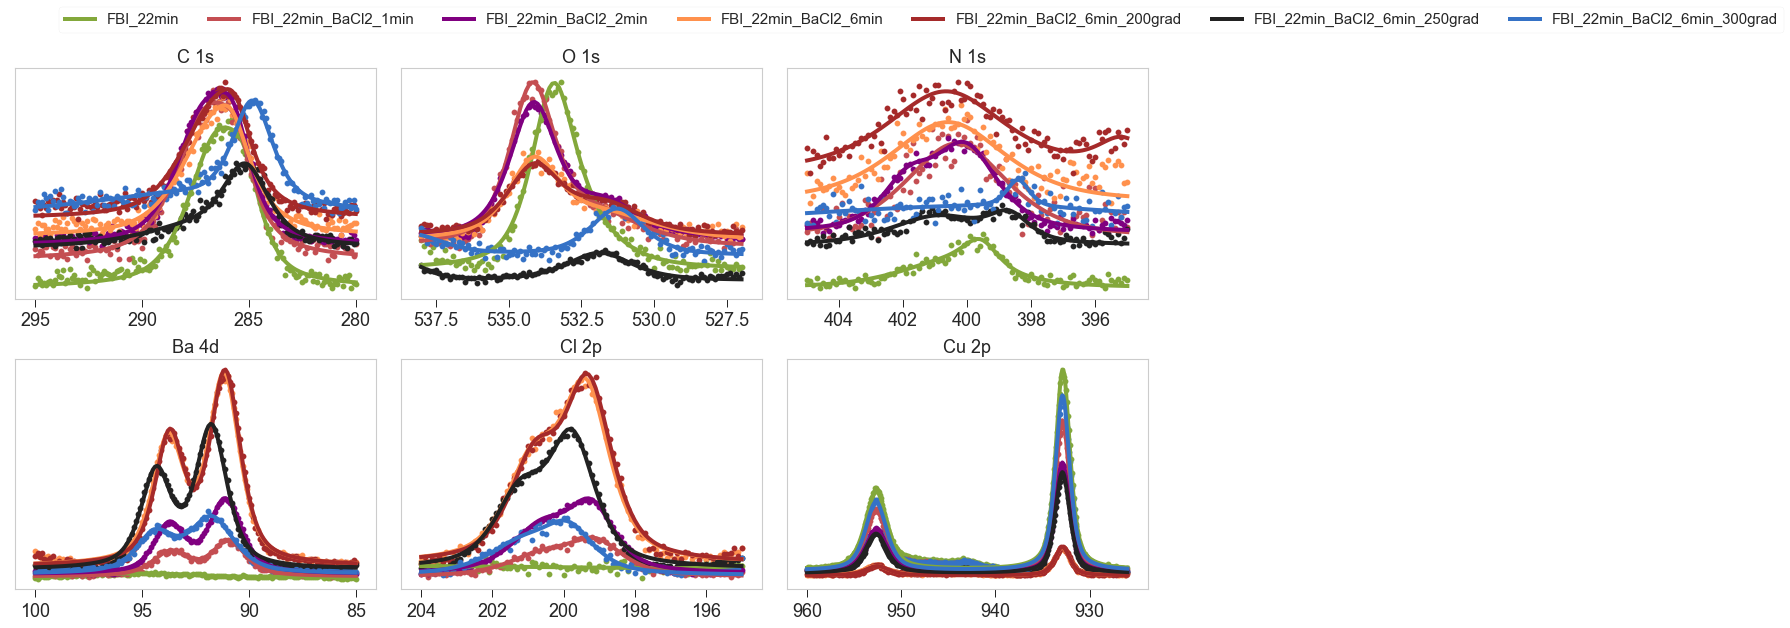

In [8]:
fig, ax = plt.subplots(2, 3, sharex=False, figsize=(16, 8), )

reg2 = ['C_1s', 'O_1s', 'N_1s']
seps = [286.5, 532, 401]
for j,r in enumerate(reg2):
    for i, xp in enumerate(subml[1:]):
        Fn = XPFit(xp, region = r)
        Fn.double_voigt(sepPt=seps[j])
        Fn.set_areas()
        plot_fit_result(xp, r, fitRes=xp.fit[r], ax=ax[0][j], offset=1+5*i/10,
                        flag_fill=True, plot_comps=False)
    ax[0][j].set(title=r.replace('_', ' '), xlabel='', ylabel='', yticks=[])
    ax[0][j].invert_xaxis()
    ax[0][j].minorticks_on()
    ax[0][j].tick_params('both', length=8, width=1, which='major')

reg1 = ['Ba_4d', 'Cl_2p', 'Cu_2p']
seps = [92.5, 201, 945]

for j,r in enumerate(reg1):
    for i,xp in enumerate(subml[1:]):
        Fn = XPFit(xp, region = r)
        Fn.double_voigt(sepPt=seps[j])
        Fn.set_areas()
        li,_ = plot_fit_result(xp, r, fitRes=xp.fit[r], ax=ax[1][j], flag_fill=True, plot_comps=False)
    ax[1][j].set(title=r.replace('_', ' '), xlabel='', ylabel='', yticks=[])
    ax[1][j].invert_xaxis()
    ax[1][j].tick_params('both', length=8, width=1, which='major')

plt.tight_layout(w_pad=0.5, h_pad=0.5, pad=0.1)
ax[0][0].legend(list(li.get_lines()), labels = [xp.name for xp in subml[1:]], ncol=len(subml[1:]),
            loc="upper left", bbox_to_anchor=(0.1, 1.3))  

In [108]:
cols = ['b', 'g', 'r', 'purple', 'y', 'brown', 'k', ]
for xp, c in zip(subml, cols):
    xp.color = c

In [184]:
selection = subml[1:5] + [subml[6]]
for xp in selection:
    print(xp.name)

FBI_22min
FBI_22min_BaCl2_1min
FBI_22min_BaCl2_2min
FBI_22min_BaCl2_6min
FBI_22min_BaCl2_6min_250grad


In [147]:
subml[4].name

'FBI_22min_BaCl2_6min'

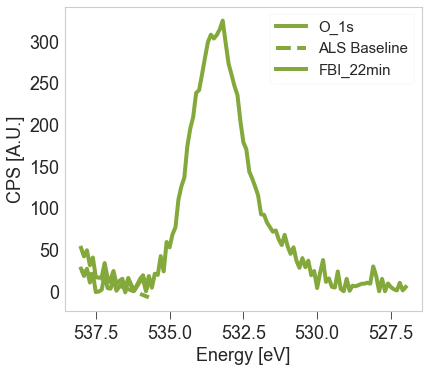

In [8]:
fix_tail_bg(subml[1], 'O_1s', edw=535.7, inplace =True);

Modify user pars
Modify user pars
Modify user pars
Modify user pars


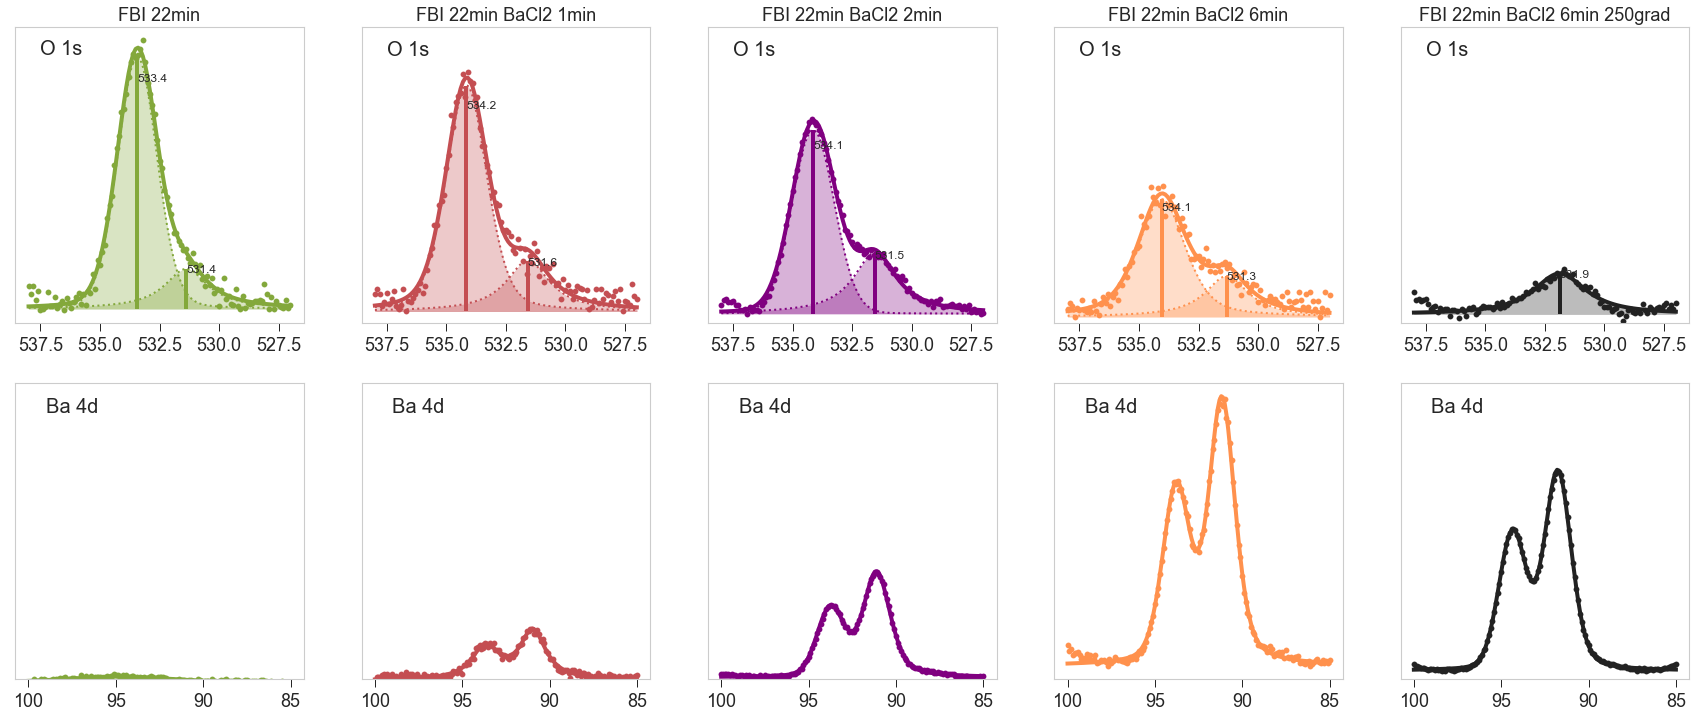

In [122]:
fig, ax = plt.subplots(2, 5, sharex=False, figsize=(30, 12), )
selection = subml[1:5] + [subml[6]]

r = 'O_1s'
for i, xp in enumerate(selection):
    Fn = XPFit(xp, region = r)
    if (i == 4):
        Fn.voigt()
    else:
        Fn.preset_pars('v1_sigma', 1.097)
        Fn.double_voigt(sepPt=532)
    Fn.set_areas()
    plot_fit_result(xp, r, fitRes=xp.fit[r], ax=ax[0][i], offset=0,
                    flag_fill=True, plot_comps=True)
    ax[0][i].set(title=xp.name.replace('_', ' '), xlabel='', ylabel='', yticks=[], 
                 ylim=(ax[0][i].get_ylim()[0], ax[0][0].get_ylim()[1]))
    ax[0][i].invert_xaxis()
    ax[0][i].tick_params('both', length=8, width=1, which='major')
    ax[0][i].text(s='O 1s', x=537.5, y=ax[0][0].get_ylim()[1]*0.9, fontsize=20)

r = 'Ba_4d'
li, _ = plot_fit_result(subml[4], r, fitRes=subml[4].fit[r], ax=ax[1][3], flag_fill=True, plot_comps=False)
lim = li.get_ylim()
ax[1][3].cla()
for i,xp in enumerate(selection):
    Fn = XPFit(xp, region = r)
    if i == 0: Fn.voigt()
    else:    Fn.double_voigt(sepPt=92.5)
    Fn.set_areas()
    li = plot_fit_result(xp, r, fitRes=xp.fit[r], ax=ax[1][i], flag_fill=True, plot_comps=False)
    ax[1][i].set(xlabel='', ylabel='', yticks=[], ylim=lim)
    ax[1][i].invert_xaxis()
    ax[1][i].tick_params('both', length=8, width=1, which='major',)
    ax[1][i].text(s='Ba 4d', x=99, y=lim[1]*0.9, fontsize=20)
# plt.tight_layout(w_pad=0.5, h_pad=0.5, pad=0.1)
# ax[0][0].legend(list(li.get_lines()), labels = [xp.name for xp in subml[:0:-1]], ncol=len(selection),
#             loc="upper left", bbox_to_anchor=(0.1, 1.2))  

In [28]:
for xp in selection[:4]:
    print(xp.name)
    print(xp.fit['O_1s'].best_values['v1_fraction'], xp.fit['O_1s'].best_values['v2_fraction'])
    print(xp.fit['O_1s'].best_values['v1_sigma'], xp.fit['O_1s'].best_values['v2_sigma'])
    print(xp.area['O_1s_v1_'])


FBI_22min
0.9999999993224074 0.17079244132248872
1.097 0.9818947805391087
0.17966789822660267
FBI_22min_BaCl2_1min
0.9999999480387497 0.3857683255195026
1.097 1.017129305422558
0.22287316002304872
FBI_22min_BaCl2_2min
0.9999999972646049 0.04392628165512297
1.097 1.0462745643185722
0.30666910832243705
FBI_22min_BaCl2_6min
0.9999999459644904 0.5754774128833094
1.097 1.1734394529013934
0.2695355341300805


In [29]:
area_big = [0]
for xp in selection[1:4]:
    area_big.append(xp.area['O_1s_v1_'])
# area_big.append(selection[4].area['O_1s_v1_'])
area_big.append(1)

In [188]:
for xp in subml[1:]:
    try: 
        print(xp.area['O_1s_v2_'], xp.area['O_1s_v1_'])
        print()
    except KeyError:
        pass

0.5502232608866355 0.44977673911336435

0.6471704619917409 0.35282953800825917

0.41984452772760483 0.5801554722723953



### Plot O_v1 vs subl Ba

Text(0, 0.5, 'Area O*-Ba / Total O 1s area')

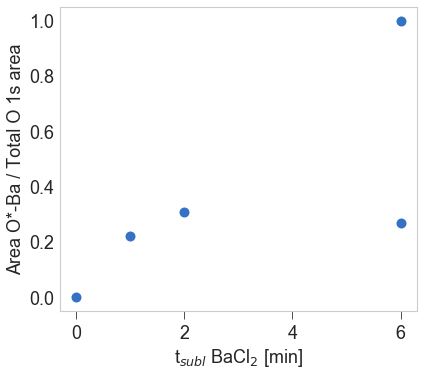

In [30]:
tsubl = [0, 1, 2, 6, 6]
plt.plot(tsubl, area_big, 'o', markersize=10)
plt.xlabel('t$_{subl}$ BaCl$_2$ [min]')
plt.ylabel('Area O*-Ba / Total O 1s area')

In [36]:
for xp in subml:
    write_processed_xp(xp.path, xp)

Storing of file /Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_21_Cu/proc/20210421_16-Cu_FBI_subl_22min.uxy.ft successful
Storing of file /Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_21_Cu/proc/20210421_16-Cu_FBI_subl_22min_BaCl2_1min.uxy.ft successful
Storing of file /Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_21_Cu/proc/20210421_16-Cu_FBI_subl_22min_BaCl2_2min.uxy.ft successful
Storing of file /Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_21_Cu/proc/20210421_16-Cu_FBI_subl_22min_BaCl2_6min.uxy.ft successful
Storing of file /Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_21_Cu/proc/20210421_16-Cu_FBI_subl_22min_BaCl2_6min_250grad.uxy.ft successful


# Sample 17 from april 26st

In [44]:
path = '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_26*/**/*.uxy'

files = glob.glob(path, recursive=True)
files.sort()
# file_clean = files[-1]
files[1], files[0] = files[0], files[1]
files

['/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_26_Cu/proc/20210426_17-Cu_clean.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_26_Cu/proc/20210426_17-Cu_FBI_subl_60min.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_26_Cu/proc/20210427_17-Cu_FBI_subl_60min_BaCl2_1min.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_26_Cu/proc/20210427_17-Cu_FBI_subl_60min_BaCl2_2min.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_26_Cu/proc/20210427_17-Cu_FBI_subl_60min_BaCl2_6min.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_26_Cu/proc/20210427_17-Cu_FBI_subl_60min_BaCl2_6min_250grad.uxy']

In [45]:
samp17 = [read_processed_xp(f) for f in files]
# for xp in samp17:
#     xp.name = xp.name.replace('17-Cu_','').replace('subl_','')

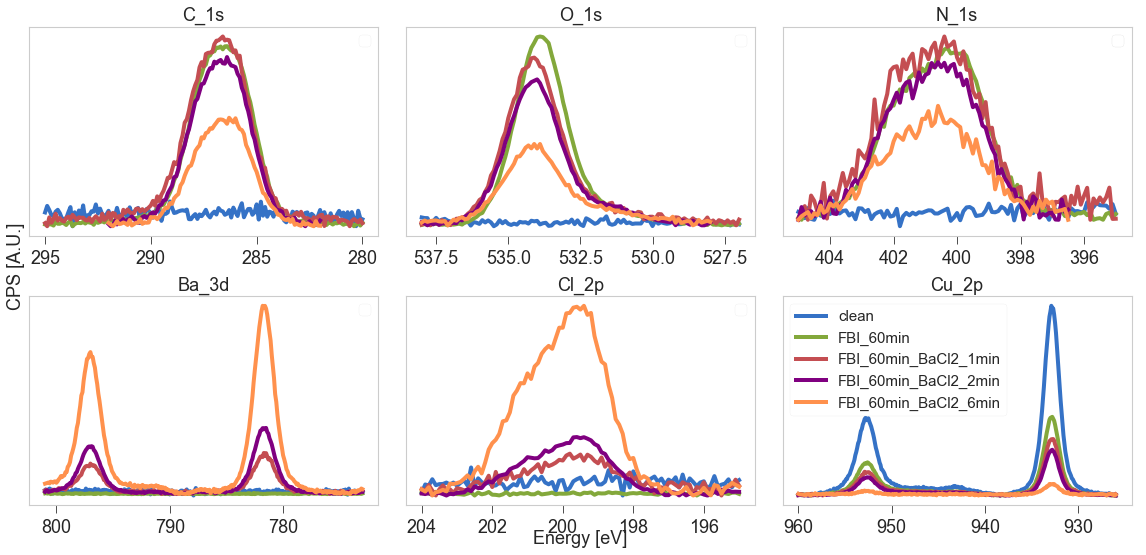

In [12]:
regs = ['C_1s', 'O_1s', 'N_1s', 'Ba_3d', 'Cl_2p', 'Cu_2p']

plot_xp_regions(samp17[:5], regs, ncols=3);
# plt.gcf().savefig('/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_26_Cu/Unscaled_exps.png', dpi=200)

In [389]:
col = ['y', 'brown', 'k']
for i, xp in enumerate(samp17[4:]):
    xp.name = xp.name.replace('22min_', '').replace('grad', 'ºC')
    xp.color = col[i]

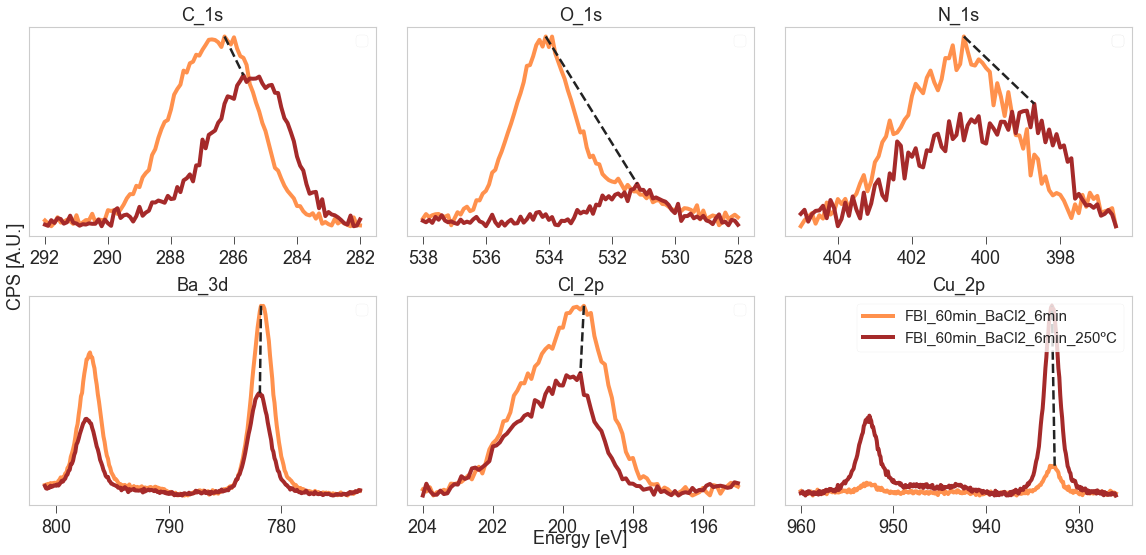

In [390]:
regs = ['C_1s', 'O_1s', 'N_1s', 'Ba_3d', 'Cl_2p', 'Cu_2p']

li = plot_xp_regions(samp17[4:], regs, ncols=3, flag_shift=True);
# plt.gcf().savefig('/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/Unscaled_exps_anneal.png', dpi=200)

In [460]:
for r in regs + ['Ba_4d']:
    enmx = []
    comx = []
    for xp in samp17[4:]:
        argmx = np.argmax(xp.dfx[r].counts)
        enmx.append(xp.dfx[r].energy.loc[argmx])
        comx.append(xp.dfx[r].counts.loc[argmx])
    print(r, enmx[0] - enmx[1])

C_1s 0.6000000000000227
O_1s 2.8999999999999773
N_1s 1.900000000000034
Ba_3d -0.10000000000002274
Cl_2p -0.09999999999999432
Cu_2p -0.2999999999999545
Ba_4d -0.20000000000000284


## Stoichiometry

'Ba_4d' region does not exist in clean


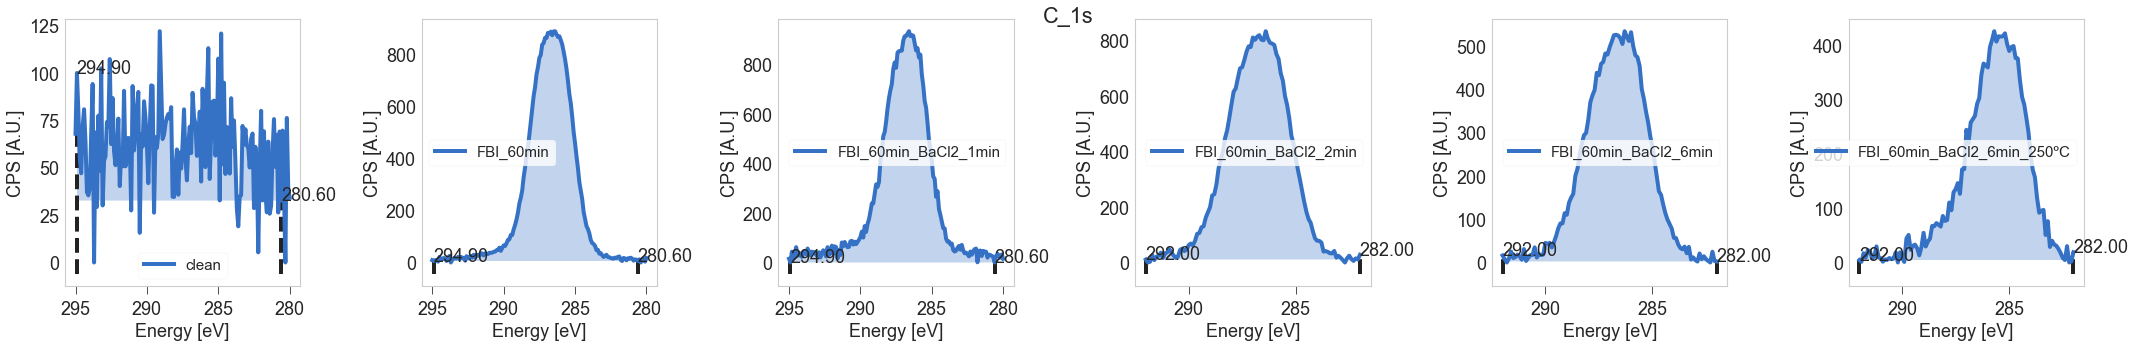

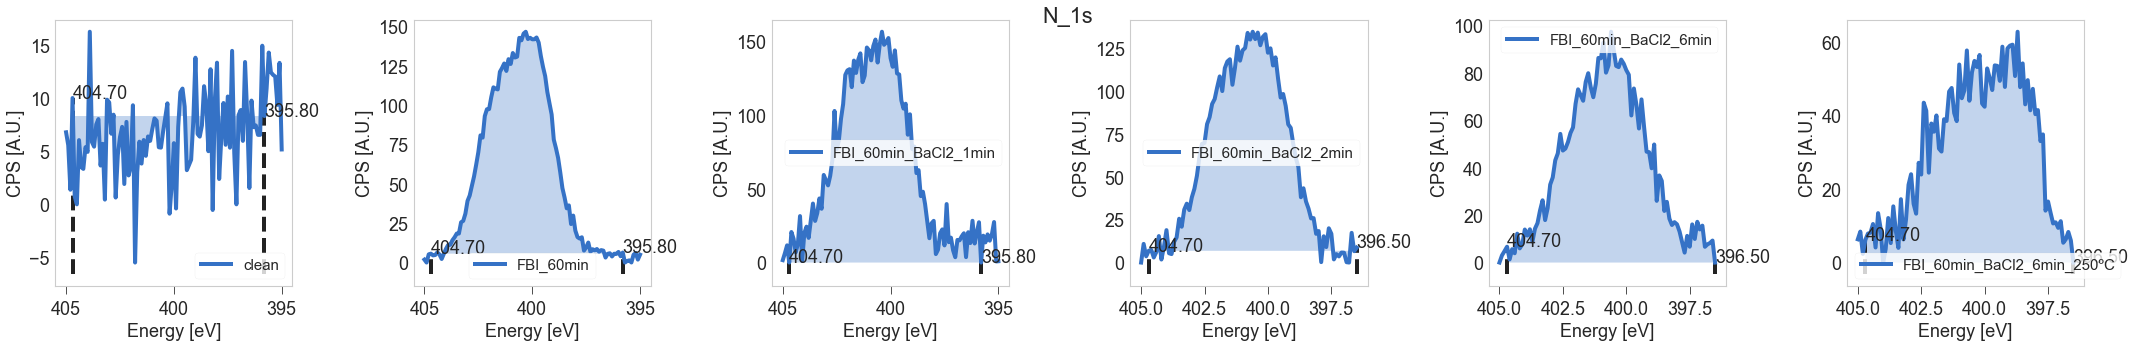

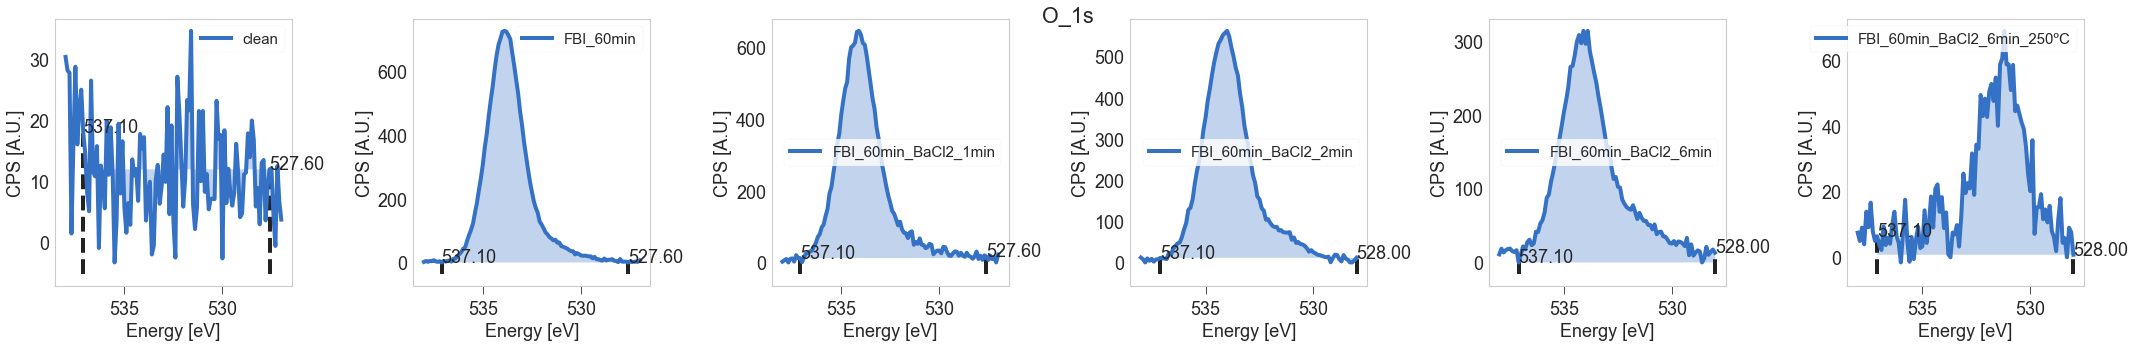

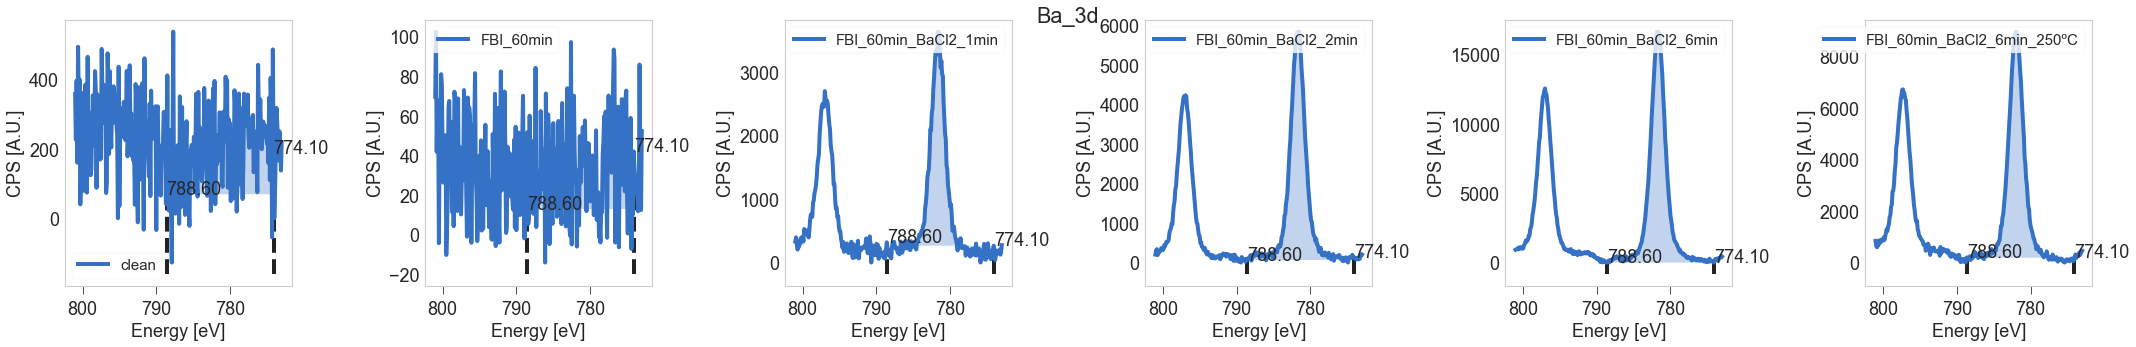

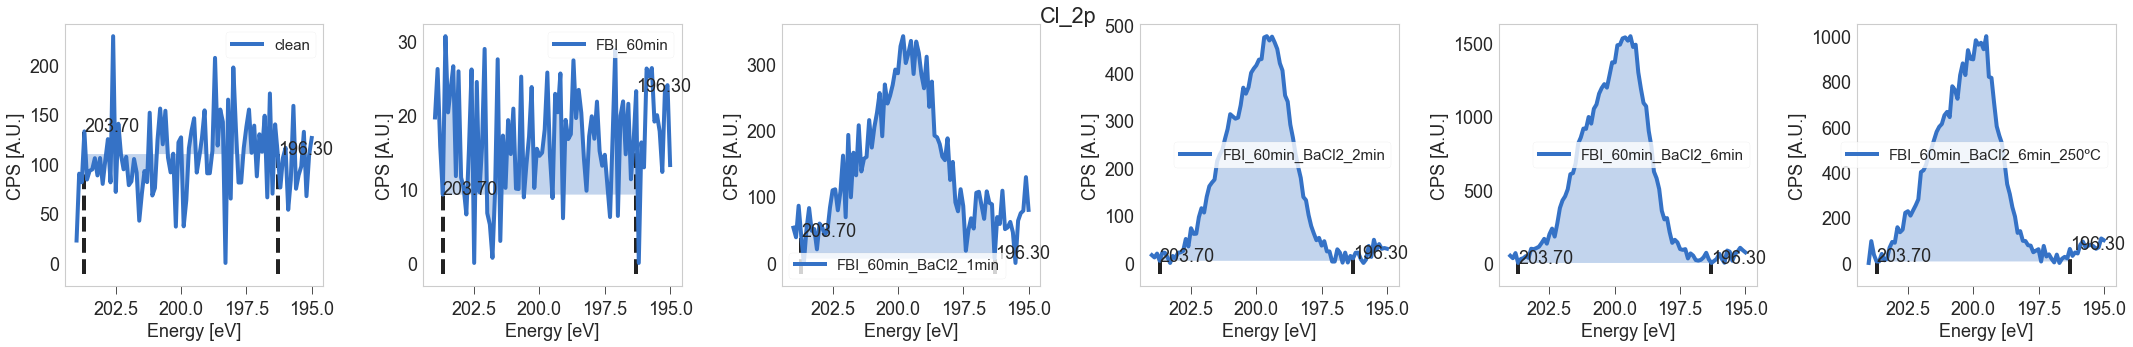

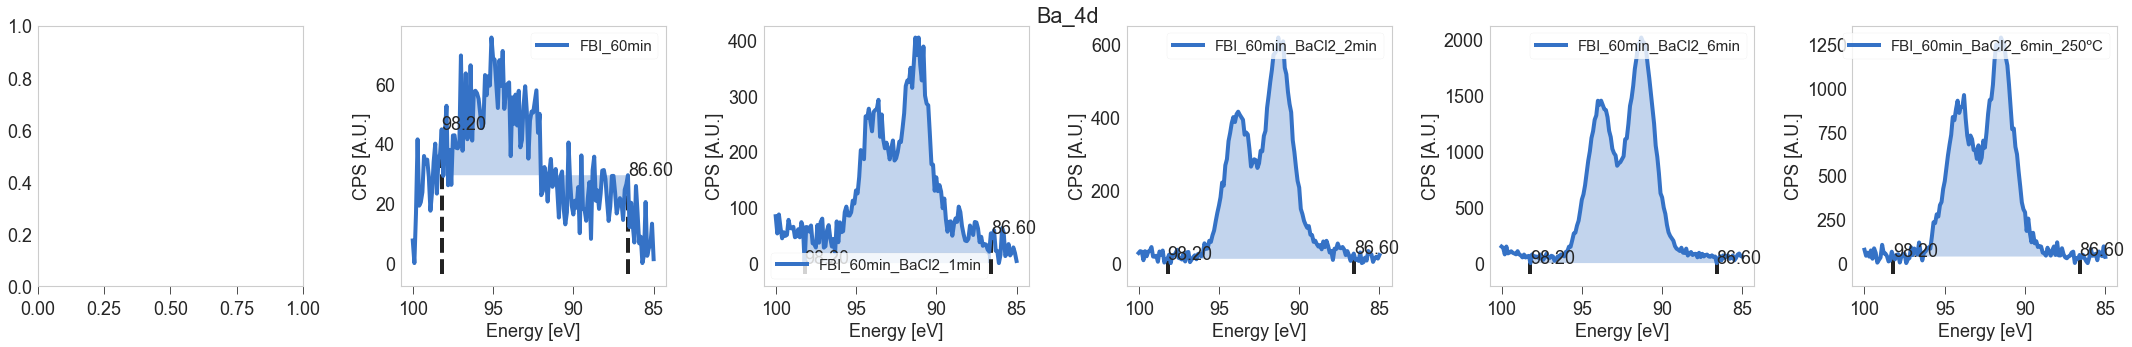

In [352]:
regions = ['C_1s', 'N_1s', 'O_1s', 'Ba_3d', 'Cl_2p', 'Ba_4d']#, 'Ba3d', 'Cl2p', 'Ba4d']

for i,r in enumerate(regions):
    integrateRegions(samp17, region=r, asf=asf)#, indRef=indRefs[i])


[6139.4677929984555,
 902.294264495149,
 19253.446323639575,
 27351.960519849956,
 77360.61573501438,
 44865.09790480745]

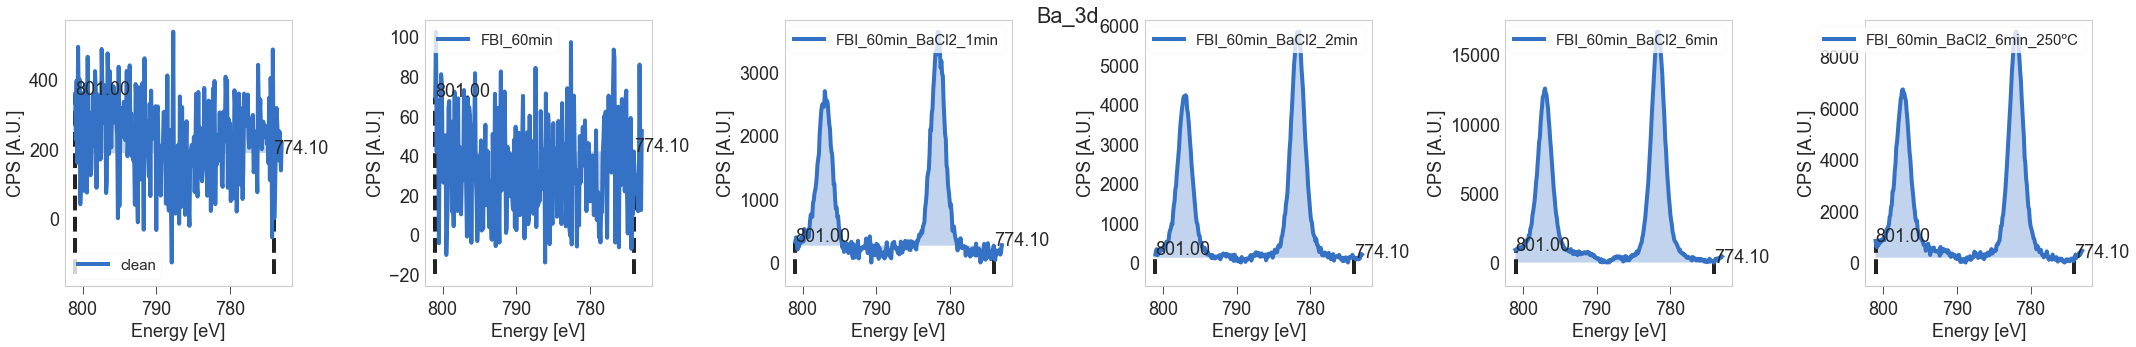

In [330]:
integrateRegions(samp17, 'Ba_3d', asf, eup=802, edw=774.1)

In [353]:
num, denom = (('N_1s', 'C_1s', 'C_1s' ), ('O_1s', 'N_1s', 'O_1s',))
make_stoichometry_table(samp17,  num=num, denom=denom, sep=' \t ')

num, denom = ('N_1s', 'Cl_2p'), ( 'Ba_3d', 'Ba_3d')
make_stoichometry_table(samp17,  num=num, denom=denom, sep=' \t ')


Experiment	N_/O_	C_/N_	C_/O_	
clean 	 0.81  	  25.04  	  20.38  	  
FBI_60min 	 0.46  	  9.84  	  4.57  	  
FBI_60min_BaCl2_1min 	 0.54  	  9.58  	  5.18  	  
FBI_60min_BaCl2_2min 	 0.50  	  9.52  	  4.78  	  
FBI_60min_BaCl2_6min 	 0.55  	  8.87  	  4.87  	  
FBI_60min_BaCl2_6min_250ºC 	 2.06  	  8.63  	  17.79  	  
Experiment	N_/Ba_	Cl_/Ba_	
clean 	 0.30  	  2.27  	  
FBI_60min 	 17.43  	  2.10  	  
FBI_60min_BaCl2_1min 	 0.89  	  0.93  	  
FBI_60min_BaCl2_2min 	 0.49  	  0.74  	  
FBI_60min_BaCl2_6min 	 0.13  	  0.89  	  
FBI_60min_BaCl2_6min_250ºC 	 0.17  	  0.96  	  


In [332]:
num, denom = (('N_1s', 'C_1s', 'C_1s', 'N_1s', 'Cl_2p'), ('O_1s', 'N_1s', 'O_1s','Ba_3d', 'Ba_3d'))
make_stoichometry_table(samp17,  num=num, denom=denom, sep=' \t ')

Experiment	N_/O_	C_/N_	C_/O_	N_/Ba_	Cl_/Ba_	
clean 	 0.81  	  25.04  	  20.38  	  0.15  	  1.11  	  
FBI_60min 	 0.46  	  9.84  	  4.57  	  9.31  	  1.12  	  
FBI_60min_BaCl2_1min 	 0.54  	  9.58  	  5.18  	  0.50  	  0.52  	  
FBI_60min_BaCl2_2min 	 0.50  	  9.52  	  4.78  	  0.28  	  0.42  	  
FBI_60min_BaCl2_6min 	 0.55  	  8.87  	  4.87  	  0.07  	  0.48  	  
FBI_60min_BaCl2_6min_250ºC 	 1.84  	  8.63  	  15.93  	  0.09  	  0.52  	  


## Coverage

In [49]:
# Coverage with FBI: IMFP = 1.86 nm
inds = [[1, 0]]
layers_fbi = arrange_coverages(samp17, inds,
                               r_ml = 1.1*nm, region='Cu_2p', mfp = 1.86*nm, takeoff = 10)

# Coverage with BaCl2: IMFP = 1.35 nm
# Take previous stage (only FBI) as reference
inds = [[2, 3, 4, 5, 1]]
layers_fbi = arrange_coverages(samp17, inds,
                               r_ml = 1*nm, region='Cu_2p', mfp = 1.35*nm, takeoff = 10)

# Add thickness of reference layer
# for xp in samp17[2:]:
#     xp.area['layers'] += samp17[1].area['layers']

In [47]:
layers_fbi

matrix([[4.87608456e-01, 2.51150881e-03],
        [8.06225506e-01, 4.47651267e-03],
        [2.06701634e+00, 1.07242970e-02],
        [1.43246461e-01, 6.95966009e-04]])

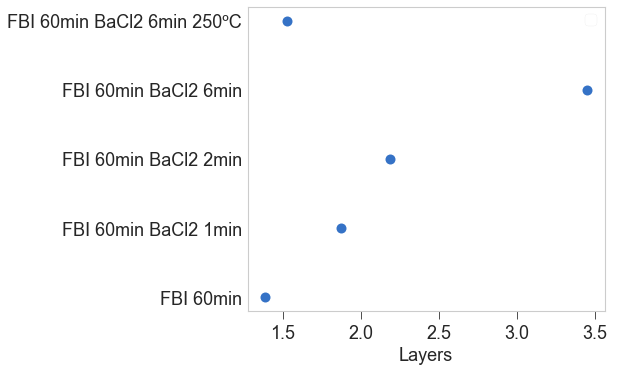

In [48]:
plot_coverages(samp17)

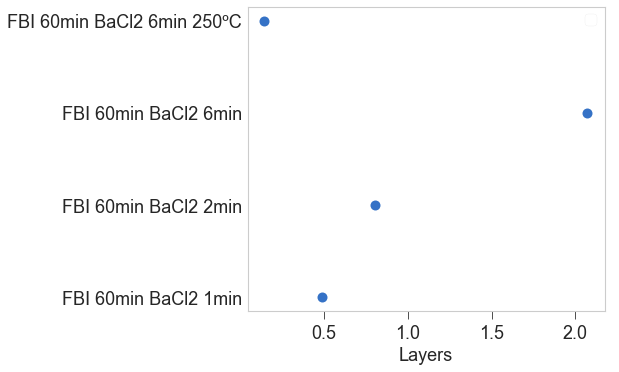

In [50]:
plot_coverages(samp17[2:])

([<matplotlib.axis.XTick at 0x1a17850518>,
 <a list of 9 Text xticklabel objects>)

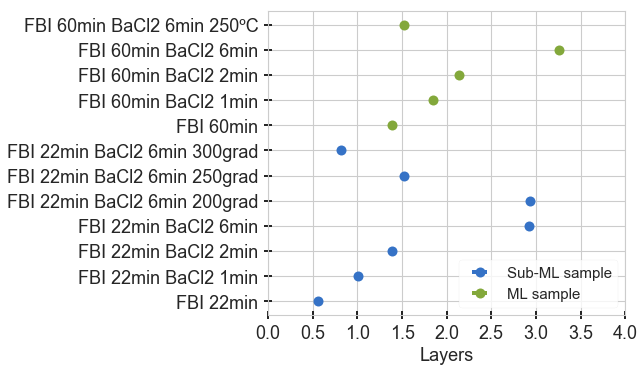

In [17]:
plot_coverages(subml, label='Sub-ML sample');
plot_coverages(samp17, label = 'ML sample');
# plt.gca().set(yticks=True)
plt.gca().tick_params(direction='inout', length=8, width=2)
plt.grid()
plt.xticks(list(plt.xticks()[0]) + [4])


## Fits

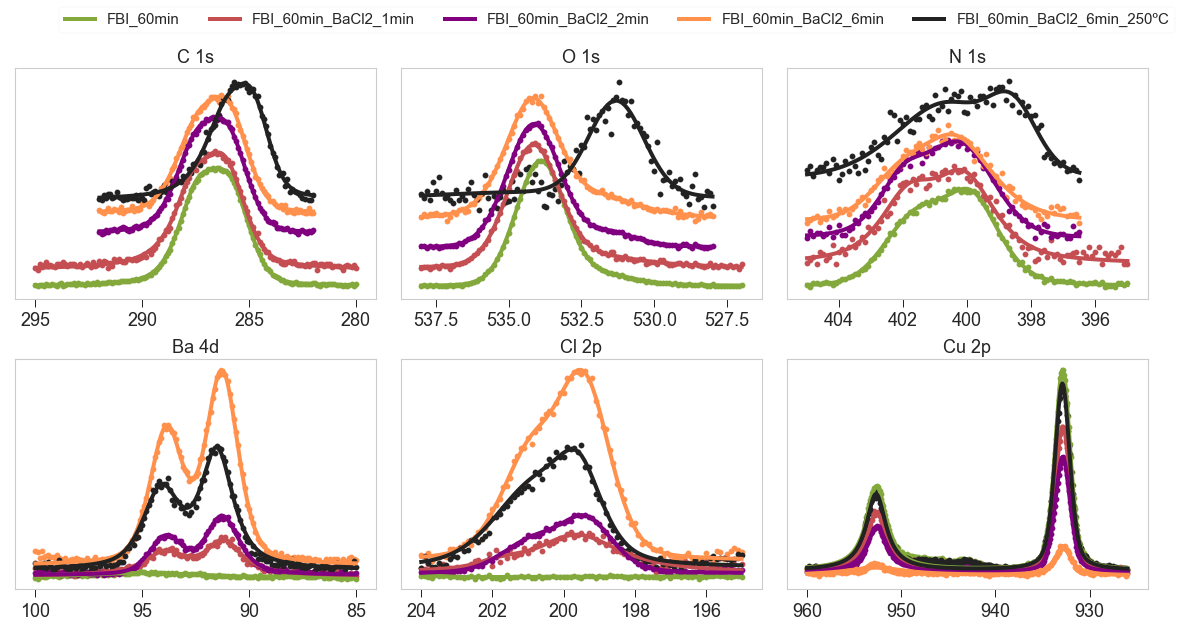

In [354]:
fig, ax = plt.subplots(2, 3, sharex=False, figsize=(16, 8), )

reg2 = ['C_1s', 'O_1s', 'N_1s']
seps = [286.5, 532, 401]
for j,r in enumerate(reg2):
    for i, xp in enumerate(samp17[1:]):
        xp = normalise_dfx(xp)
        Fn = XPFit(xp, region = r)
        Fn.double_voigt(sepPt=seps[j])
        Fn.set_areas()
        plot_fit_result(xp, r, fitRes=xp.fit[r], ax=ax[0][j], offset=1+5*i/10,
                        flag_fill=True, plot_comps=False)
    ax[0][j].set(title=r.replace('_', ' '), xlabel='', ylabel='', yticks=[])
    ax[0][j].invert_xaxis()
    ax[0][j].minorticks_on()
    ax[0][j].tick_params('both', length=8, width=1, which='major')

reg1 = ['Ba_4d', 'Cl_2p', 'Cu_2p']
seps = [92.5, 201, 945]

for j,r in enumerate(reg1):
    for i,xp in enumerate(samp17[1:]):
#         Fn = XPFit(xp, region = r)
#         Fn.double_voigt(sepPt=seps[j])
#         Fn.set_areas()
        li = plot_fit_result(xp, r, fitRes=xp.fit[r], ax=ax[1][j], flag_fill=True, plot_comps=False)
    ax[1][j].set(title=r.replace('_', ' '), xlabel='', ylabel='', yticks=[])
    ax[1][j].invert_xaxis()
    ax[1][j].tick_params('both', length=8, width=1, which='major')

plt.tight_layout(w_pad=0.5, h_pad=0.5, pad=0.1)
ax[0][0].legend(list(li.get_lines()), labels = [xp.name for xp in samp17[1:]], ncol=len(samp17[1:]),
            loc="upper left", bbox_to_anchor=(0.1, 1.3))  

In [343]:
cols = ['b', 'g', 'r', 'purple', 'y', 'k', 'pink']
for xp, c in zip(samp17, cols):
    xp.color = c

### Fits O 1s

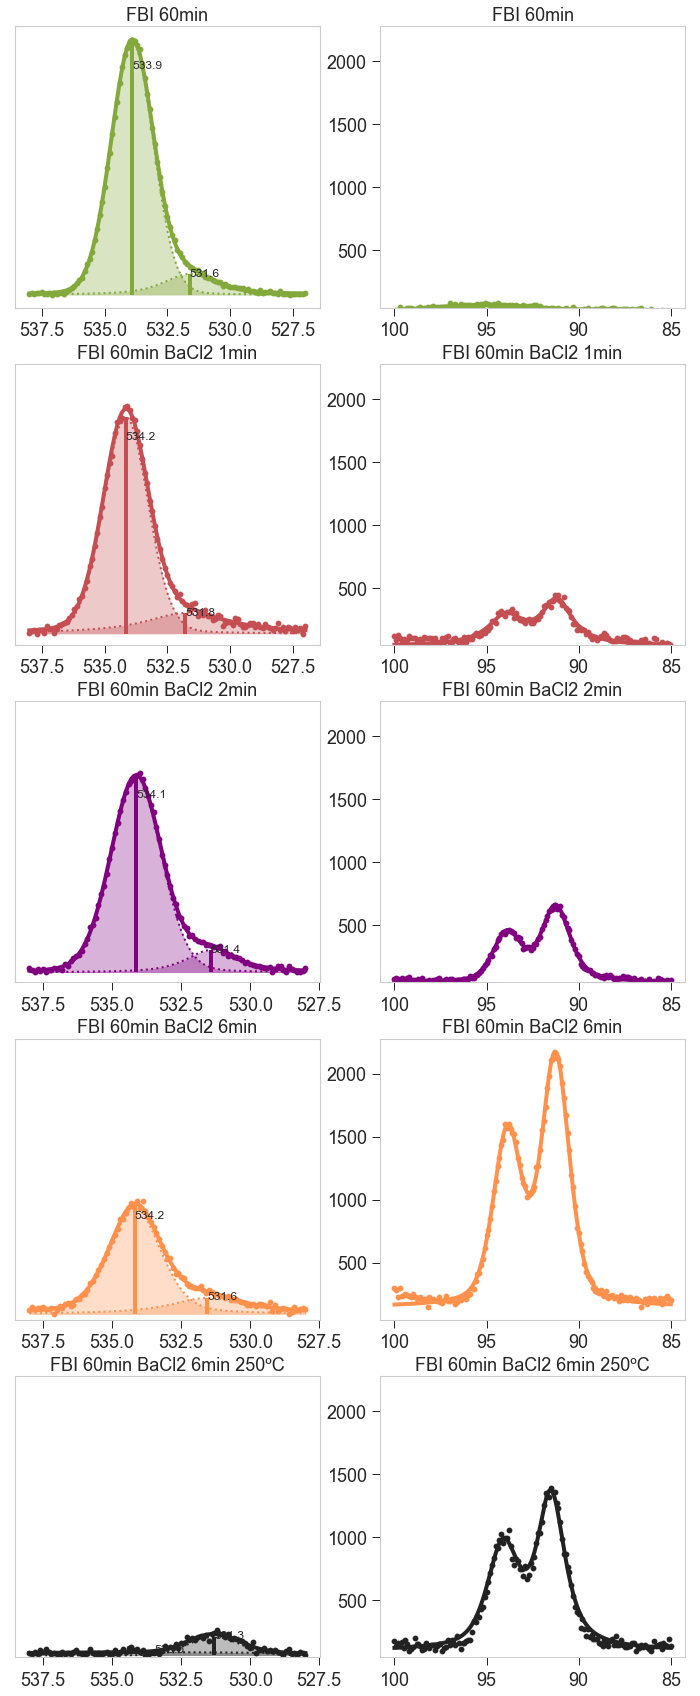

In [355]:
fig, ax = plt.subplots(5, 2, sharex=False, figsize=(12, 30), )

r = 'O_1s'
for i, xp in enumerate(samp17[1:]):
    Fn = XPFit(xp, region = r)
    Fn.double_voigt(sepPt=532)
    Fn.set_areas()
    plot_fit_result(xp, r, fitRes=xp.fit[r], ax=ax[i][0], offset=0,
                    flag_fill=True, plot_comps=True)
    ax[i][0].set(title=xp.name.replace('_', ' '), xlabel='', ylabel='', yticks=[], 
                 ylim=(ax[i][0].get_ylim()[0], ax[0][0].get_ylim()[1]))
    ax[i][0].invert_xaxis()
    ax[i][0].tick_params('both', length=8, width=1, which='major')

r = 'Ba_4d'
li = plot_fit_result(samp17[4], r, fitRes=samp17[4].fit[r], ax=ax[3][1], flag_fill=True, plot_comps=False)
lim = li.get_ylim()
ax[3][1].cla()
for i,xp in enumerate(samp17[1:]):
#         Fn = XPFit(xp, region = r)
#         Fn.double_voigt(sepPt=seps)

    li = plot_fit_result(xp, r, fitRes=xp.fit[r], ax=ax[i][1], flag_fill=True, plot_comps=False)
    ax[i][1].set(title=xp.name.replace('_', ' '), xlabel='', ylabel='', ylim=lim)
    ax[i][1].invert_xaxis()
    ax[i][1].tick_params('both', length=8, width=1, which='major',)

# plt.tight_layout(w_pad=0.5, h_pad=0.5, pad=0.1)
# ax[0][0].legend(list(li.get_lines()), labels = [xp.name for xp in samp17[:0:-1]], ncol=len(samp17[1:]),
#             loc="upper left", bbox_to_anchor=(0.1, 1.2))  

Modify user pars
Modify user pars
Modify user pars
Modify user pars


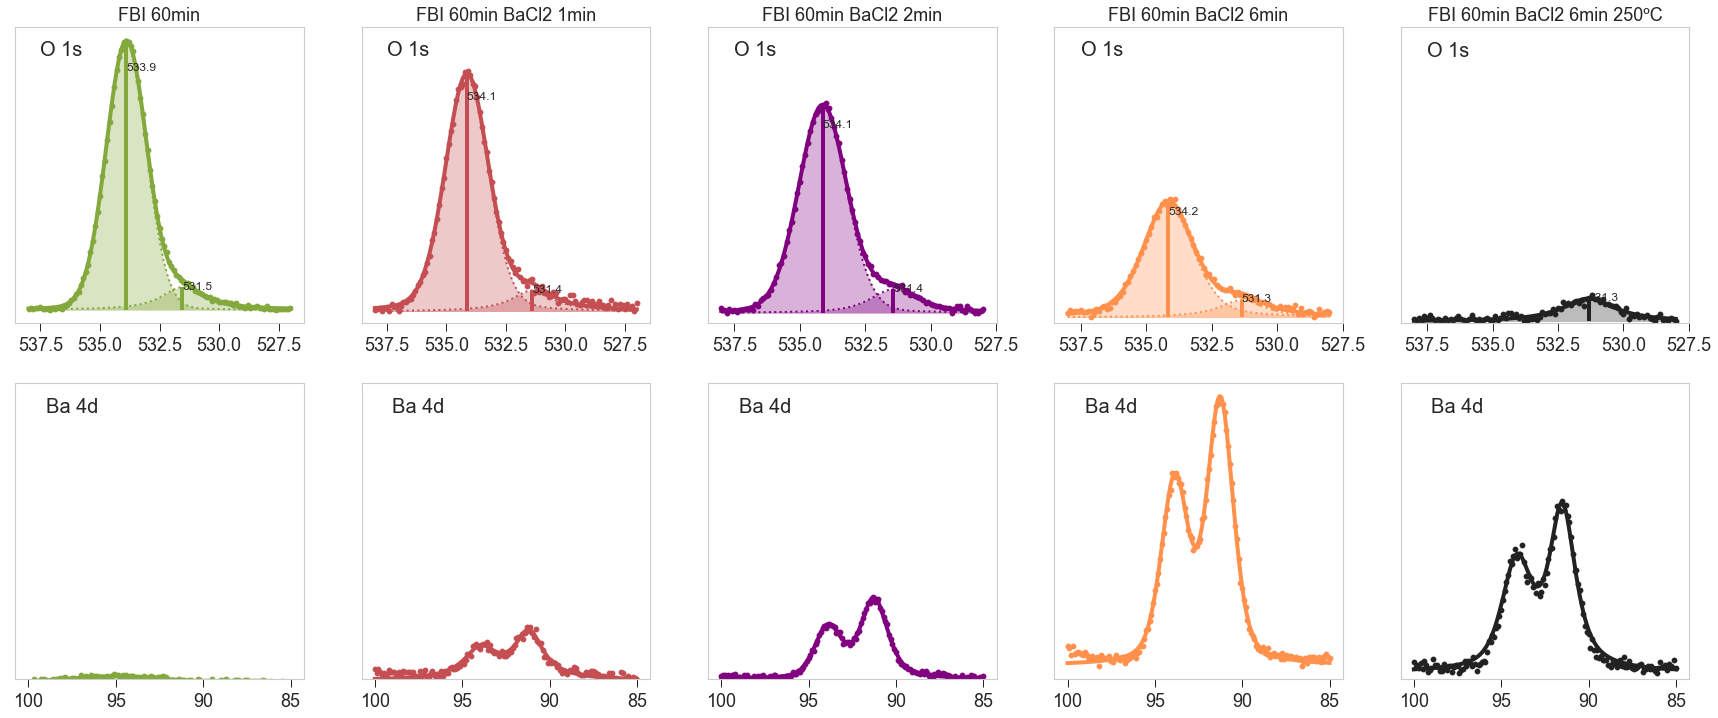

In [129]:
fig, ax = plt.subplots(2, 5, sharex=False, figsize=(30, 12), )

r = 'O_1s'
seps = [286.5, 532, 401]

for i, xp in enumerate(samp17[1:]):
    Fn = XPFit(xp, region = r)
    if i == 4:
        Fn.voigt()
    else:
        Fn.preset_pars('v1_sigma', 1.0469)
        Fn.double_voigt(sepPt=532)
    plot_fit_result(xp, r, fitRes=xp.fit[r], ax=ax[0][i], offset=0,
                    flag_fill=True, plot_comps=True)
    ax[0][i].set(title=xp.name.replace('_', ' '), xlabel='', ylabel='', yticks=[], 
                 ylim=(ax[0][i].get_ylim()[0], ax[0][0].get_ylim()[1]))
    ax[0][i].invert_xaxis()
    ax[0][i].tick_params('both', length=8, width=1, which='major')
    ax[0][i].text(s='O 1s', x=537.5, y=ax[0][0].get_ylim()[1]*0.9, fontsize=20)

r = 'Ba_4d'
li, _ = plot_fit_result(samp17[4], r, ax=ax[1][3], flag_fill=True, plot_comps=False)
lim = li.get_ylim()
ax[1][3].cla()
for i,xp in enumerate(samp17[1:]):
#         Fn = XPFit(xp, region = r)
#         Fn.double_voigt(sepPt=seps)

    li = plot_fit_result(xp, r, fitRes=xp.fit[r], ax=ax[1][i], flag_fill=True, plot_comps=False)
    ax[1][i].set(xlabel='', ylabel='', yticks=[], ylim=lim)
    ax[1][i].invert_xaxis()
    ax[1][i].tick_params('both', length=8, width=1, which='major',)
    ax[1][i].text(s='Ba 4d', x=99, y=lim[1]*0.9, fontsize=20)
# plt.tight_layout(w_pad=0.5, h_pad=0.5, pad=0.1)
# ax[0][0].legend(list(li.get_lines()), labels = [xp.name for xp in samp17[:0:-1]], ncol=len(samp17[1:]),
#             loc="upper left", bbox_to_anchor=(0.1, 1.2))  

In [56]:
for xp in samp17[1:]:
    print(xp.fit['O_1s'].best_values['v1_sigma'])

1.0469
1.0469
1.0469
1.0469
1.2082845720365807


In [376]:
for xp in samp17:
    write_processed_xp(xp.path, xp)

Storing of file /Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_26_Cu/proc/20210426_17-Cu_clean.uxy.ft successful
Storing of file /Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_26_Cu/proc/20210426_17-Cu_FBI_subl_60min.uxy.ft successful
Storing of file /Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_26_Cu/proc/20210427_17-Cu_FBI_subl_60min_BaCl2_1min.uxy.ft successful
Storing of file /Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_26_Cu/proc/20210427_17-Cu_FBI_subl_60min_BaCl2_2min.uxy.ft successful
Storing of file /Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_26_Cu/proc/20210427_17-Cu_FBI_subl_60min_BaCl2_6min.uxy.ft successful
Storing of file /Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_26_Cu/proc/20210427_17-Cu_FBI_subl_60min_BaCl2_6min_250grad.uxy.ft successful


In [57]:
area_ml = []
for xp in samp17[1:5]:
    area_ml.append(xp.area['O_1s_v1_'])
area_ml.append(1)

In [60]:
area_abs_ml = []
for xp in samp17[1:5]:
    area_abs_ml.append(xp.area['O_1s_v1_'] * xp.area['O_1s'])
area_abs_ml.append(samp17[5].area['O_1s'])

In [368]:
samp17[4].area['O_1s'] * samp17[4].area['O_1s_v1_'], samp17[5].area['O_1s']

(178.55937515063565, 195.5776631179623)

### Plot O_v1 vs subl Ba

Text(0, 0.5, 'Area O*-Ba / Total O 1s area')

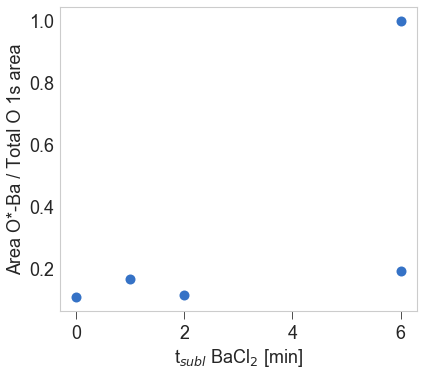

In [58]:
tsubl = [0, 1, 2, 6, 6]
plt.plot(tsubl, area_ml, 'o', label='ML sample', markersize=10)
# plt.plot(tsubl, area_big, 'o', label='Sub-ML sample', markersize=10)

plt.xlabel('t$_{subl}$ BaCl$_2$ [min]')
plt.ylabel('Area O*-Ba / Total O 1s area')
# plt.legend()

Text(0, 0.5, 'Area O*-Ba [Counts $\\cdot$ eV]')

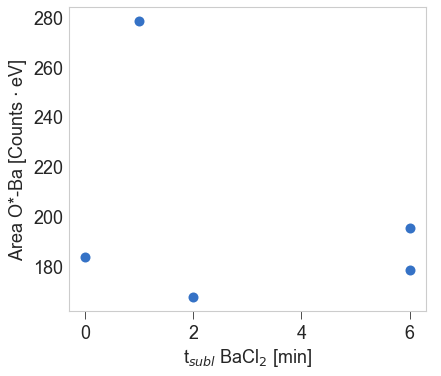

In [61]:
tsubl = [0, 1, 2, 6, 6]
plt.plot(tsubl, area_abs_ml, 'o', label='ML sample', markersize=10)
# plt.plot(tsubl, area_big, 'o', label='Sub-ML sample', markersize=10)

plt.xlabel('t$_{subl}$ BaCl$_2$ [min]')
plt.ylabel('Area O*-Ba [Counts $\cdot$ eV]')
# plt.legend()

In [434]:
samp17[4].ls = '--'
samp17[4].name = 'FBI 1.5 ML, BaCl$_2$ 6 min'
samp17[5].ls = '--'
samp17[5].name = 'FBI 1.5 ML, BaCl$_2$ 6 min 250ºC'

subml[4].name = 'FBI 0.5 ML, BaCl$_2$ 6 min'
subml[6].name = 'FBI 0.5 ML, BaCl$_2$ 6 min 250ºC'

### Other fits

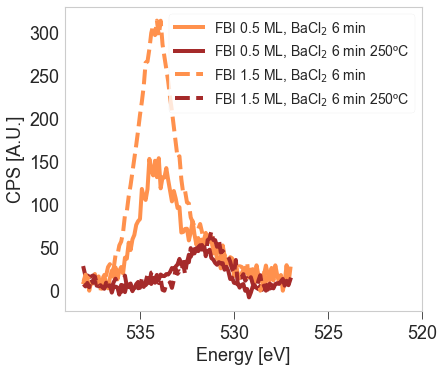

In [437]:
region = 'O_1s'
plot_region(subml[4], region)
plot_region(subml[6], region)
plot_region(samp17[4], region, )
plot_region(samp17[5], region)
plt.gca().set(xlim=(539, 520 ))
plt.legend(loc='upper right', fontsize = 14)

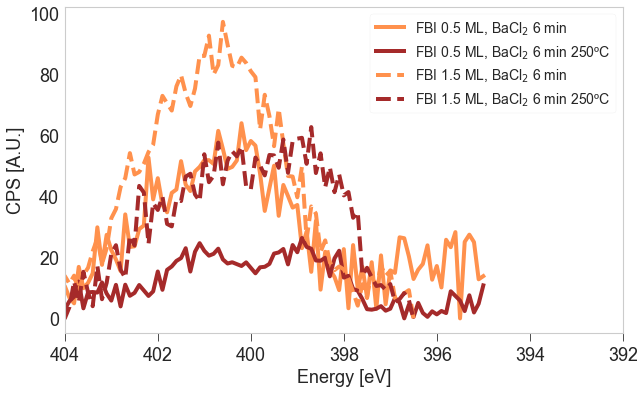

In [446]:
region = 'N_1s'
plt.figure(figsize=(10, 6))
plot_region(subml[4], region)
plot_region(subml[6], region)
plot_region(samp17[4], region, )
plot_region(samp17[5], region)
plt.gca().set(xlim=(404, 392 ))
plt.legend(loc='upper right', fontsize = 14)

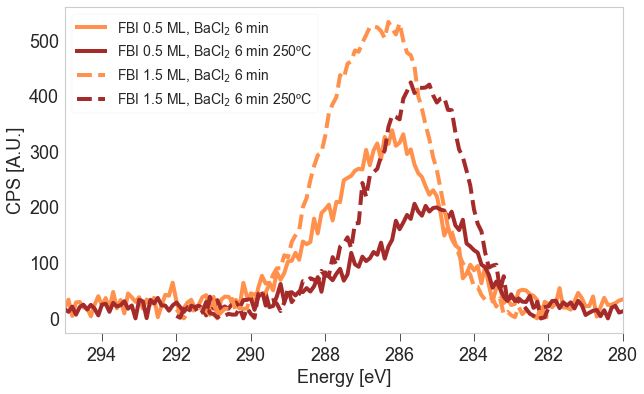

In [451]:
region = 'C_1s'
plt.figure(figsize=(10, 6))
plot_region(subml[4], region)
plot_region(subml[6], region)
plot_region(samp17[4], region, )
plot_region(samp17[5], region)
plt.gca().set(xlim=(295, 280))
plt.legend(loc='upper left', fontsize = 14)

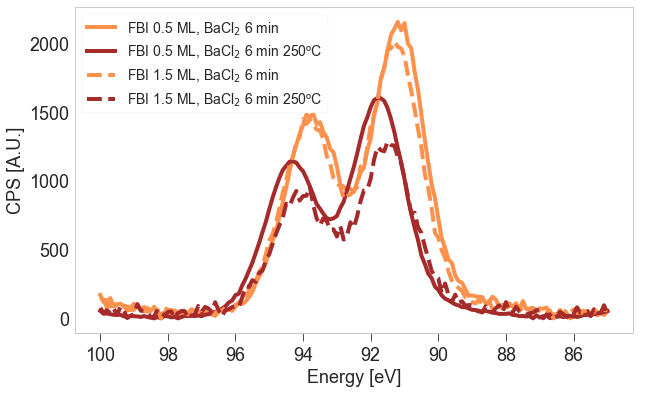

In [455]:
region = 'Ba_4d'
plt.figure(figsize=(10, 6))
plot_region(subml[4], region)
plot_region(subml[6], region)
plot_region(samp17[4], region, )
plot_region(samp17[5], region)
plt.gca().invert_xaxis()
plt.legend(loc='upper left', fontsize = 14)

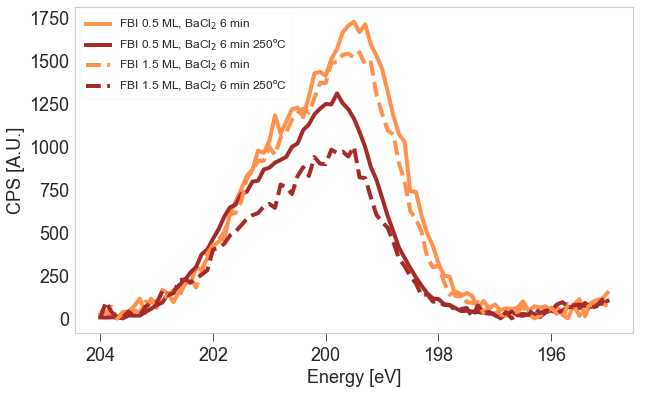

In [458]:
region = 'Cl_2p'
plt.figure(figsize=(10, 6))
plot_region(subml[4], region)
plot_region(subml[6], region)
plot_region(samp17[4], region, )
plot_region(samp17[5], region)
plt.gca().invert_xaxis()
plt.legend(loc='upper left', fontsize = 12)

# All samples O 1s shoulder vs Ba layers

In [165]:
samp17[1].name

'FBI_60min'

In [137]:
np.sqrt(xp.area['O_1s_v1_'] * (xp.area['O_1s']) ) / xp.area['O_1s']

0.014388008144192384

In [185]:
for xp in samp12[1:6:3]:
    print(xp.name)

11-Cu_FBI_subl_20min_BaCl2_2min
12-Cu_FBI_subl_20min_BaCl2_4min


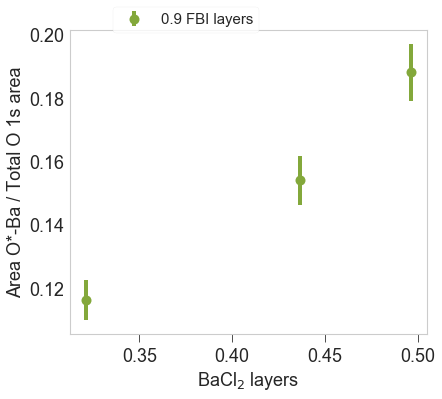

In [194]:
cov12, shoulder12, dshoulder12 = [], [], []
for xp in samp12[1:6:3]:
    cov12.append(xp.area['layers'])
    shoulder12.append(xp.area['O_1s_v1_'])
    dshoulder12.append(np.sqrt(xp.area['O_1s_v1_'] * (xp.area['O_1s']) ) / xp.area['O_1s'] )

# plt.errorbar(x=cov12, y=shoulder12, yerr=dshoulder12, fmt='o',ms=10, label='%.1f FBI layers' %samp12[0].area['layers'])

cov13, shoulder13, dshoulder13 = [], [], []
for xp in samp13[2:]:
    cov13.append(xp.area['layers'])
    shoulder13.append(xp.area['O_1s_v1_'])
    dshoulder13.append(np.sqrt(xp.area['O_1s_v1_'] * (xp.area['O_1s']) ) / xp.area['O_1s'] )

plt.errorbar(x=cov13, y=shoulder13, yerr=dshoulder13, fmt='go',ms=10, label='%.1f FBI layers' %samp13[1].area['layers'])
# plt.plot(cov13, shoulder13, 'og', ms=10, label='%.1f FBI layers' %samp13[1].area['layers'])
plt.xlabel('BaCl$_2$ layers')
plt.ylabel('Area O*-Ba / Total O 1s area')
plt.gca().legend(loc="upper left", bbox_to_anchor=(0.1, 1.1))  

FBI_60min_BaCl2_1min
FBI_60min_BaCl2_2min
FBI_60min_BaCl2_6min


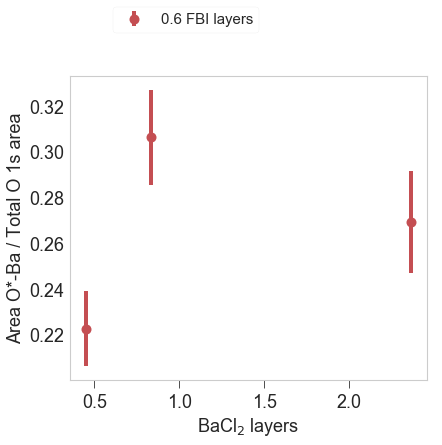

In [190]:
cov16, shoulder16, dshoulder16 = [], [], []
for xp in subml[2:5]:
    cov16.append(xp.area['layers'])
    shoulder16.append(xp.area['O_1s_v1_'])
    dshoulder16.append(np.sqrt(xp.area['O_1s_v1_'] * (xp.area['O_1s']) ) / xp.area['O_1s'] )
    
plt.errorbar(x=cov16, y=shoulder16, yerr=dshoulder16, fmt='ro',ms=10, label='%.1f FBI layers' %subml[1].area['layers'])

cov17, shoulder17, dshoulder17 = [], [], []
for xp in samp17[2:5]:
    print(xp.name)
    cov17.append(xp.area['layers'])
    shoulder17.append(xp.area['O_1s_v1_'])
    dshoulder17.append(np.sqrt(xp.area['O_1s_v1_'] * (xp.area['O_1s']) ) / xp.area['O_1s'] )
    
# plt.errorbar(x=cov17, y=shoulder17, yerr=dshoulder17, fmt='ok',ms=10, label='%.1f FBI layers' %samp17[1].area['layers'])
plt.xlabel('BaCl$_2$ layers')
plt.ylabel('Area O*-Ba / Total O 1s area')
plt.gca().legend(loc="upper left", bbox_to_anchor=(0.1, 1.25))  

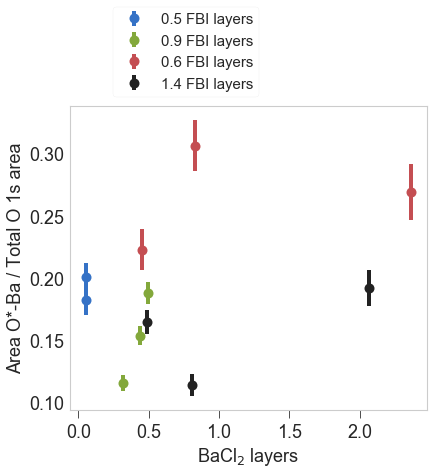

In [187]:
plt.errorbar(x=cov12, y=shoulder12, yerr=dshoulder12, fmt='o',ms=10, label='%.1f FBI layers' %samp12[0].area['layers'])
plt.errorbar(x=cov13, y=shoulder13, yerr=dshoulder13, fmt='o',ms=10, label='%.1f FBI layers' %samp13[1].area['layers'])
plt.errorbar(x=cov16, y=shoulder16, yerr=dshoulder16, fmt='ro',ms=10, label='%.1f FBI layers' %subml[1].area['layers'])
plt.errorbar(x=cov17, y=shoulder17, yerr=dshoulder17, fmt='ok',ms=10, label='%.1f FBI layers' %samp17[1].area['layers'])
plt.xlabel('BaCl$_2$ layers')
plt.ylabel('Area O*-Ba / Total O 1s area')
plt.gca().legend(loc="upper left", bbox_to_anchor=(0.1, 1.35))  

# Figures paper

## Progressive barium addition

In [58]:
path = '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_02_*/**/*.uxy'

files = glob.glob(path, recursive=True)
files.sort()

files = files[6:10]
files

['/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_02_03_Cu/proc/20210203_13-Cu_FBI_subl_60min.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_02_03_Cu/proc/20210203_13-Cu_FBI_subl_60min_BaCl2_04min.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_02_03_Cu/proc/20210203_13-Cu_FBI_subl_60min_BaCl2_08min.uxy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_02_03_Cu/proc/20210203_13-Cu_FBI_subl_60min_BaCl2_12min.uxy']

In [63]:
progba = [read_processed_xp(f) for f in files]

In [100]:
progba[3].color = 'k'

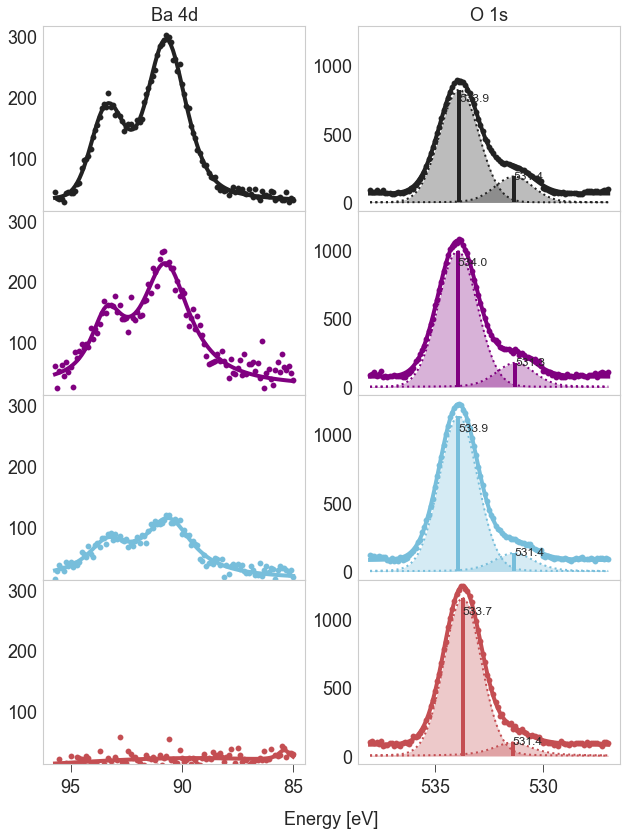

In [102]:
region = 'Ba_4d'
fig, ax = plt.subplots(4, 2, sharex=False, figsize=(9, 12), )
fig.add_subplot(111, frameon=False, xticks=[], yticks=[])  # Used for common xlabel and ylabel

for i,xp in enumerate(progba[::-1]):

    plot_fit_result(xp, 'Ba_4d', fitRes=xp.fit['Ba_4d'], ax=ax[i][0], flag_fill=False, plot_comps=False)
    plot_fit_result(xp, 'O_1s', fitRes=xp.fit['O_1s'], ax=ax[i][1], flag_fill=True)

    if i == 0: yl1 = ax[i][0].get_ylim()
    ax[i][0].set(ylim=yl1)
    
    ax[i][0].invert_xaxis()
    ax[i][1].invert_xaxis()
    ax[i][0].set(xlabel='', ylabel='')
    ax[i][1].set(xlabel='', ylabel='')

#     ax[i][0].get_legend().remove()
#     ax[i][1].get_legend().remove()

yl2 = ax[2][1].get_ylim()
for i in range(4):
    ax[i][1].set(ylim=yl2)
    
ax[0][0].set_title('Ba 4d')
ax[0][1].set_title('O 1s')

plt.xlabel('\n\nEnergy [eV]', ha='center')
plt.tight_layout(w_pad=0.5, h_pad=0.9, pad=0.3)

plt.subplots_adjust(hspace=.0)
plt.subplots_adjust(wspace=.2)

plt.gcf().savefig('/Users/pabloherrero/Dropbox/phd/drafts/fbi_cu_sublimation/v3/fits_ba4d_o1s.png', dpi=200)

In [300]:
xp_norm2.color = 'k'

In [105]:
banorm = [normalise_dfx(xp) for xp in progba]

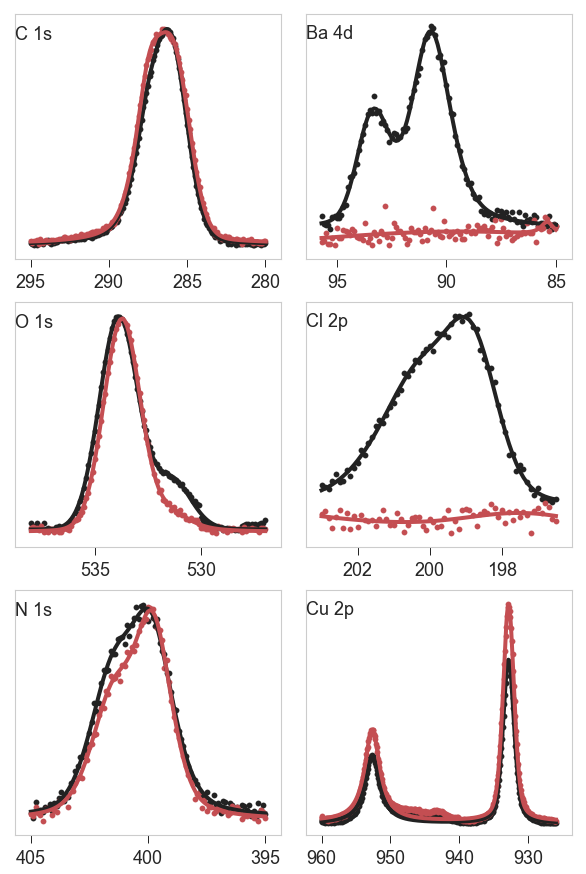

In [118]:
fig, ax = plt.subplots(3,2, sharex=False, figsize=(8, 12), )

reg2 = ['C_1s', 'O_1s', 'N_1s']
seps = [286.5, 532, 401]
for j,r in enumerate(reg2):
    for i, xp in enumerate([banorm[-1], banorm[0]]):
#         Fn = XPFit(xp, region = r)
#         Fn.double_voigt(sepPt=seps[j])
        plot_fit_result(xp, r, fitRes=xp.fit[r], ax=ax[j][0], flag_fill=True, plot_comps=False)
    ax[j][0].set(xlabel='', ylabel='', yticks=[])
    ax[j][0].invert_xaxis()
    ax[j][0].text(s=r.replace('_', ' '), x=(ax[j][0].get_xlim()[0]), y=(ax[j][0].get_ylim()[1]*0.9))
    ax[j][0].minorticks_on()
    ax[j][0].tick_params('both', length=8, width=1, which='major')



reg1 = ['Ba_4d', 'Cl_2p', 'Cu_2p']
for j,r in enumerate(reg1):
    for i,xp in enumerate([progba[-1], progba[0]]):
        plot_fit_result(xp, r, fitRes=xp.fit[r], ax=ax[j][1], flag_fill=True, plot_comps=False)
    ax[j][1].set(xlabel='', ylabel='', yticks=[])
    ax[j][1].invert_xaxis()
    ax[j][1].text(s=r.replace('_', ' '), x=(ax[j][1].get_xlim()[0]), y=(ax[j][1].get_ylim()[1]*0.9))
    
    ax[j][1].tick_params('both', length=8, width=1, which='major')
    
plt.tight_layout(w_pad=0.5, h_pad=0.2, pad=0.1)
plt.gcf().savefig('/Users/pabloherrero/Dropbox/phd/drafts/fbi_cu_sublimation/v3/fbi_ba_3to1.png', dpi=200)

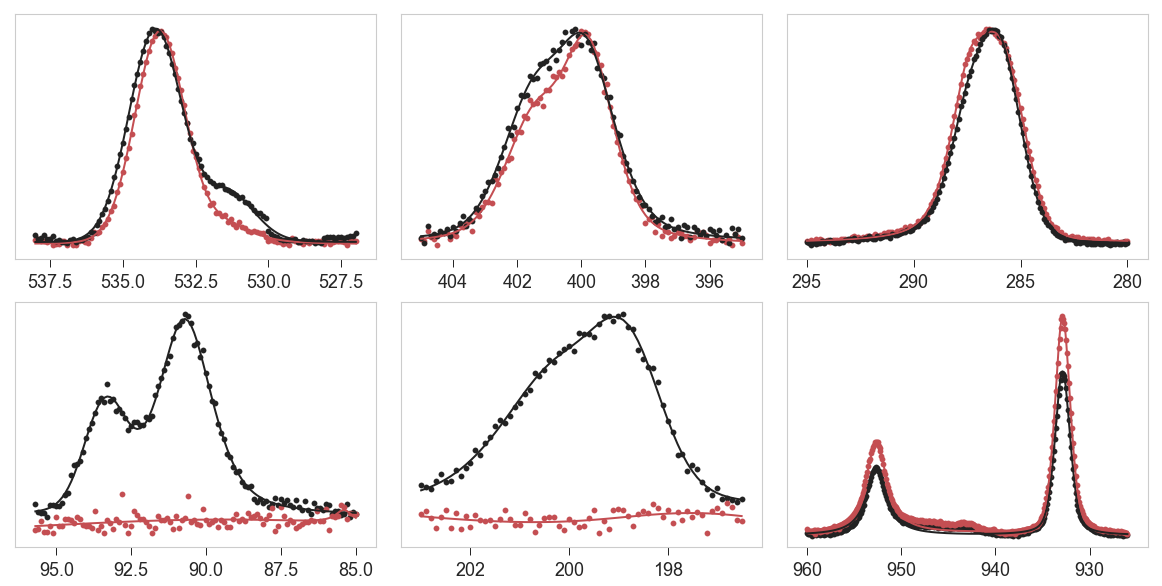

In [316]:
fig, ax = plt.subplots(2, 3, sharex=False, figsize=(16, 8), )

reg2 = ['O_1s', 'N_1s', 'C_1s',]
seps = [ 532, 401, 286.5,]
for j,r in enumerate(reg2):
    for i, xp in enumerate([banorm[-1], banorm[0]]):
        Fn = XPFit(xp, region = r)
        Fn.double_voigt(sepPt=seps[j])
        plot_fit_result(xp, r, fitRes=xp.fit[r], ax=ax[0][j], flag_fill=True, plot_comps=False)
    ax[0][j].set(xlabel='', ylabel='', yticks=[])
#     ax[0][j].text(s=r.replace('_', ' '), x=(ax[0][j].get_xlim()[1]), y=(ax[0][j].get_ylim()[1]*0.9))
    
    ax[0][j].invert_xaxis()
    ax[0][j].minorticks_on()
    ax[0][j].tick_params('both', length=8, width=1, which='major')

reg1 = ['Ba_4d', 'Cl_2p', 'Cu_2p']
for j,r in enumerate(reg1):
    for i,xp in enumerate([progba[-1], progba[0]]):
        li = plot_fit_result(xp, r, fitRes=xp.fit[r], ax=ax[1][j], flag_fill=True, plot_comps=False)
    ax[1][j].set( xlabel='', ylabel='', yticks=[])
#     ax[1][j].text(s=r.replace('_', ' '), x=(ax[1][j].get_xlim()[1]), y=(ax[1][j].get_ylim()[1]*0.9))
    
    ax[1][j].invert_xaxis()
    ax[1][j].tick_params('both', length=8, width=1, which='major')
    
plt.tight_layout(w_pad=0.5, h_pad=0.2, pad=0.1)
# ax[0][0].legend(list(li.get_lines()), labels = [progba[-1].name, progba[0].name], ncol=2,
#             loc="upper right", bbox_to_anchor=(1.0, 1.2), fontsize=16)           


## FBI coverage

In [107]:
path = '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_0*/**/*.sxy'
files = glob.glob(path, recursive=True)
files.sort()

In [106]:
fbi_exps = []
ba_exps = []
for f in files:
    if ('FBI_subl_' in f) and ('BaCl2' not in f):
        fbi_exps.append(read_processed_xp(f))
    elif 'BaCl2' in f:
        ba_exps.append(read_processed_xp(f))

clean_exps = []
for f in files:
    if 'clean' in f:
        clean_exps.append(read_processed_xp(f))

[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_18_Cu/proc/20210119_7-Cu_FBI_subl_05min.sxy.ft', returning empty fit dict
[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_18_Cu/proc/20210119_7-Cu_FBI_subl_10min.sxy.ft', returning empty fit dict
[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_18_Cu/proc/20210119_7-Cu_FBI_subl_15min.sxy.ft', returning empty fit dict
[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_18_Cu/proc/20210119_7-Cu_FBI_subl_20min.sxy.ft', returning empty fit dict
[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_21_Cu/proc/20210121_8-Cu_FBI_subl_05min.sxy.ft', returning empty fit dict
[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_21_Cu/proc/20210122_8-Cu_FBI_s

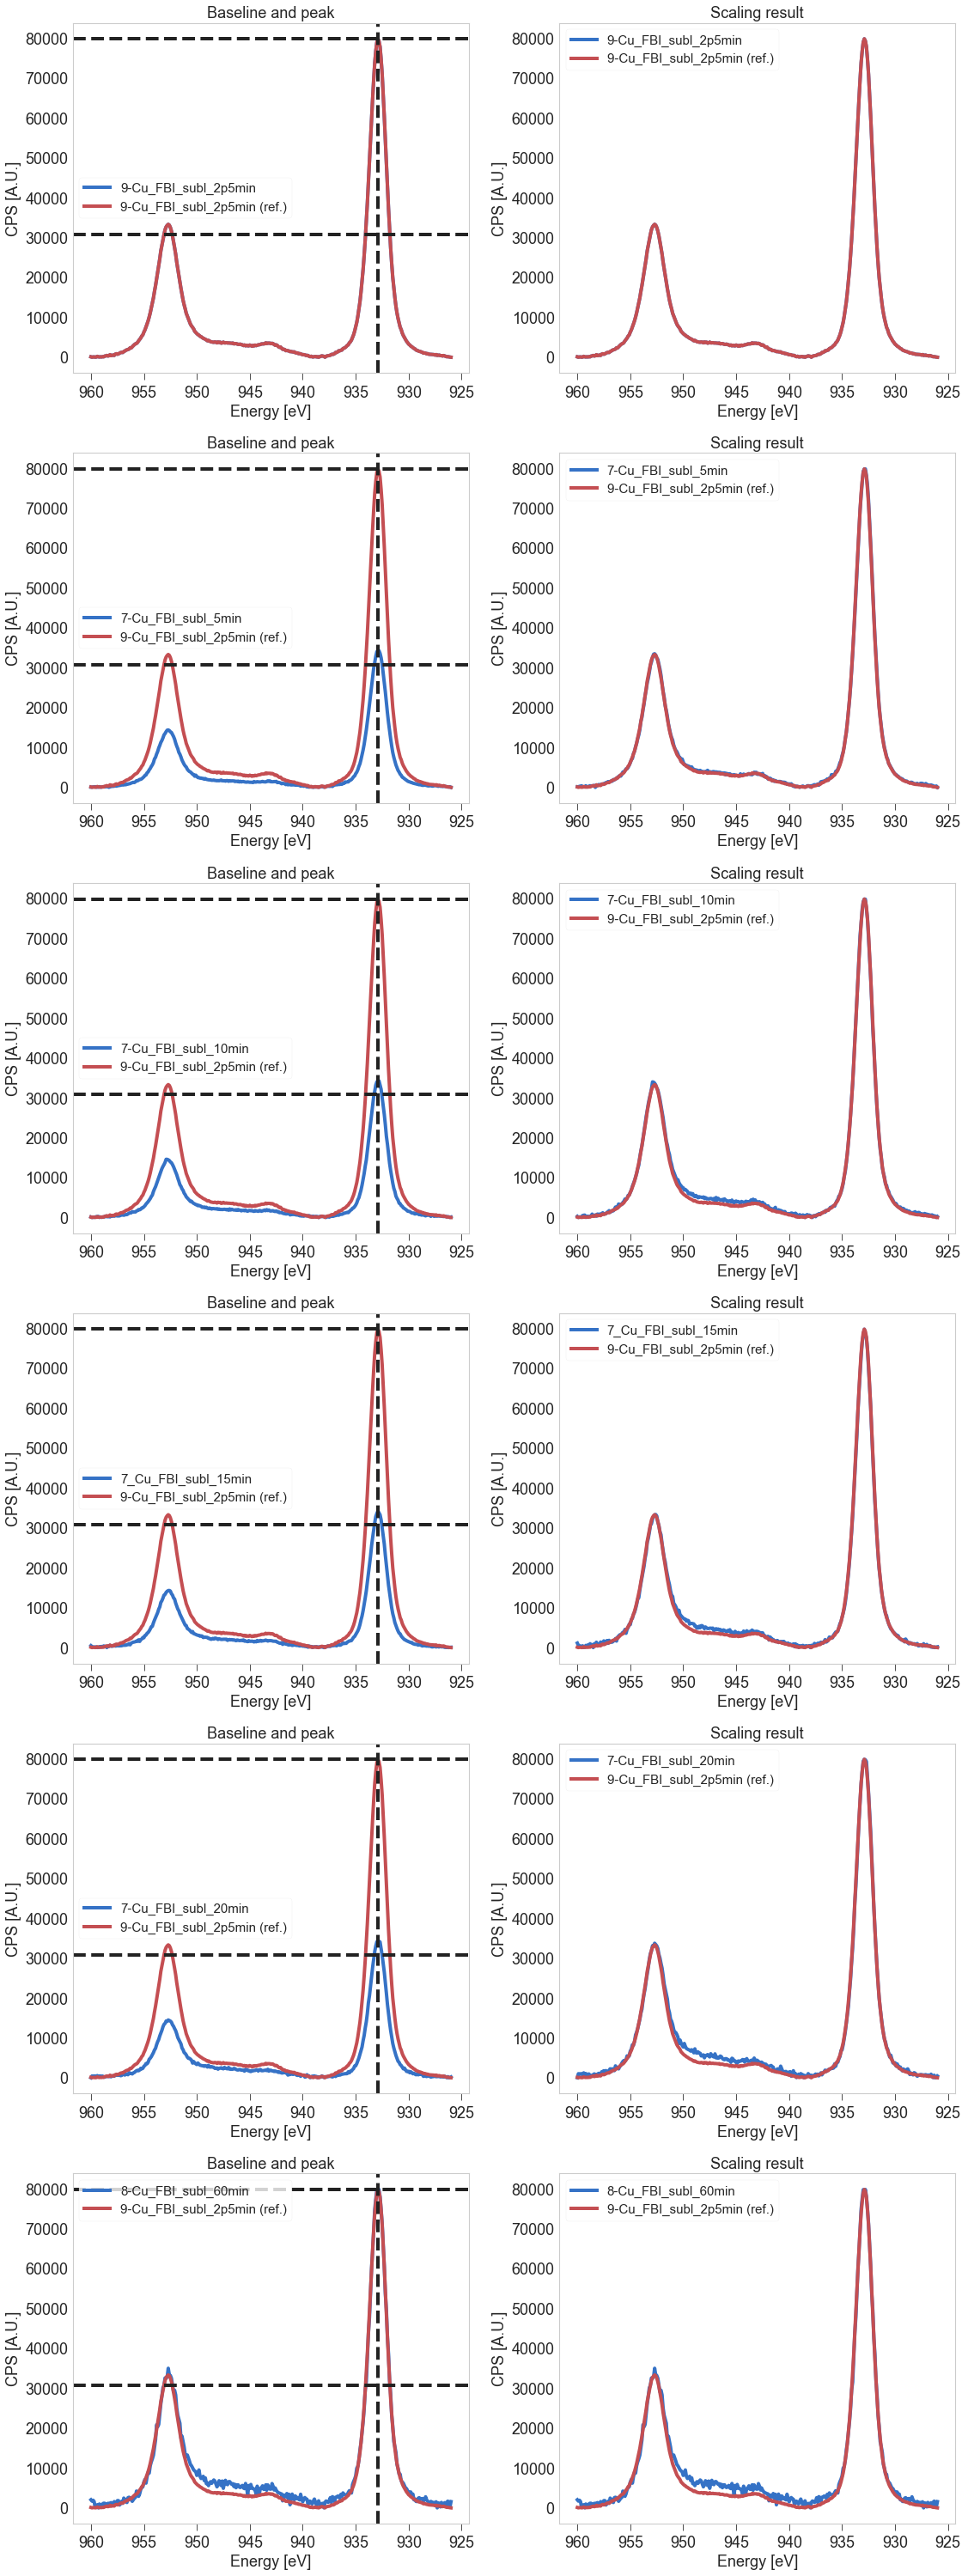

In [109]:
sele2 = [xp for xp in fbi_exps if ('7-' in xp.path) ]
selection = [fbi_exps[7]] + sele2
selection.append(fbi_exps[6])
selection = scale_and_plot_spectra(selection, indRef=0, region='Cu_2p')

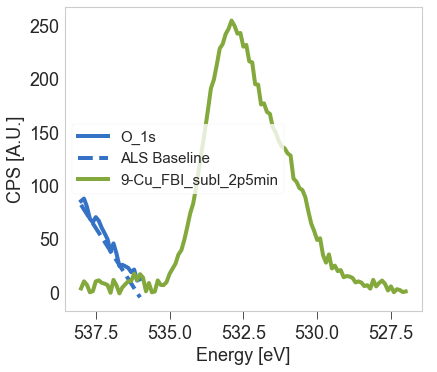

In [110]:
fix_tail_bg(selection[0], 'O_1s', edw=536, inplace=True);

In [111]:
for xp in selection:
    write_processed_xp(xp.path, xp)

In [67]:
for xp in selection:
    xp.name = xp.name[14:].replace('min', ' min')
selection[0].name = selection[0].name.replace('p', '.')
plt.rcParams['lines.linewidth'] = 4

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a22bbb9b0>,
      dtype=object)

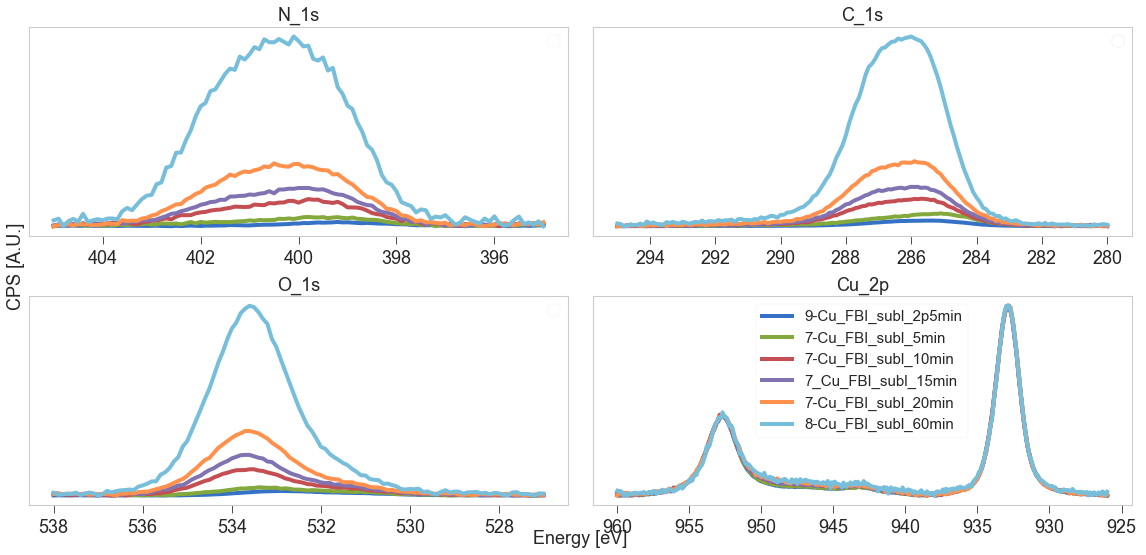

In [112]:
regions= ['N_1s', 'C_1s', 'O_1s', 'Cu_2p']

plot_xp_regions(selection, regions, ncols=2)
# plt.gcf().savefig('/Users/pabloherrero/Dropbox/phd/papers/fbi_cu_sublim_v2/FBI_growth_many.png', dpi=200)

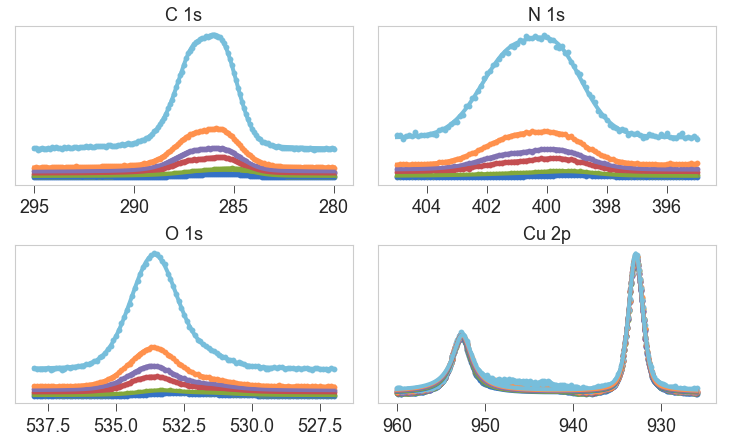

In [61]:
regions= ['C_1s', 'O_1s', 'N_1s', 'Cu_2p']
fig, ax = plt.subplots(2,2, sharex=False, figsize=(10, 6), )

seps = [286.5, 532, 401, 950]
for j,r in enumerate(regions):
    for i, xp in enumerate(selection):
        k, l = j%2, j//2
        Fn = XPFit(xp, region = r)
        Fn.double_voigt(sepPt=seps[j])
        plot_fit_result(xp, r, fitRes=xp.fit[r], ax=ax[k][l], flag_fill=True, offset=1+i/100, plot_comps=False)
    ax[k][l].set(title=r.replace('_', ' '), xlabel='', ylabel='', yticks=[])
    ax[k][l].invert_xaxis()
plt.tight_layout(w_pad=0.5, h_pad=0.5, pad=0.1)
# plt.gcf().savefig('/Users/pabloherrero/Dropbox/phd/papers/fbi_cu_sublimation/v3/fbi_coverage_all.png', dpi=200)

### Normalized

In [113]:
norm_sel = [normalise_dfx(xp) for xp in selection]

In [ ]:
coverages = [0.47, 0.65, 1.09, 1.41, 1.82, 3.02]
for i,xp in enumerate(norm_sel):
    xp.name = coverages[i]
    

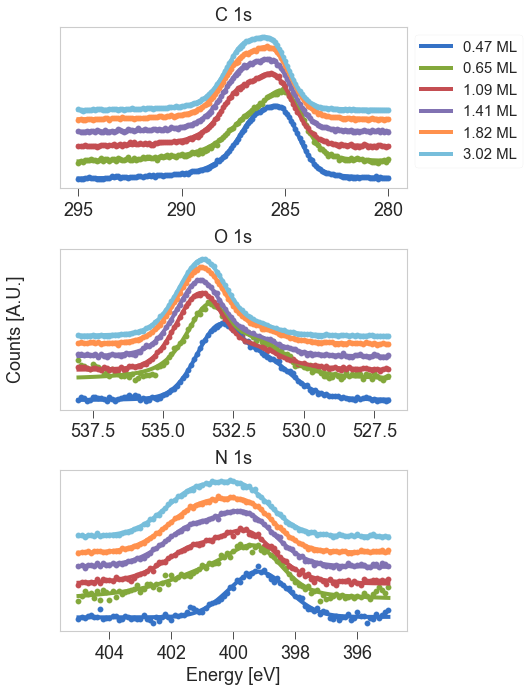

In [118]:
# selection = [xp for xp in fbi_exps if ('7-' in xp.path)]
regions= ['C_1s', 'O_1s', 'N_1s']
coverages = [0.47, 0.65, 1.09, 1.41, 1.82, 3.02]
fig, ax = plt.subplots(3, sharex=False, figsize=(6, 10), )
axx = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
axx.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Energy [eV]")
plt.ylabel("Counts [A.U.]")

seps = [286.5, 532, 401]
for j,r in enumerate(regions):
    for i, xp in enumerate(norm_sel):
#         k, l = j%2, j//2
#         Fn = XPFit(xp, region = r)
#         Fn.double_voigt(sepPt=seps[j])
        li = plot_fit_result(xp, r, fitRes=xp.fit[r], ax=ax[j], flag_fill=True, offset=1+8*i/10, plot_comps=False)
    ax[j].set(title=r.replace('_', ' '), xlabel='', ylabel='', yticks=[])
    ax[j].invert_xaxis()

plt.tight_layout(w_pad=0.5, h_pad=0.5, pad=0.1)     #  First manage the space and THEN add the legend
ax[0].legend(list(li.get_lines()), labels = [str(cov) + ' ML' for cov in coverages], ncol=1,
            loc="upper left", bbox_to_anchor=(1., 1.))           

fig.savefig('/Users/pabloherrero/Dropbox/phd/drafts/fbi_cu_sublimation/v3/fbi_coverage_all_norm.png', dpi=200, bbox_inches = 'tight')

In [135]:
enmx, comx

([399.2, 399.8, 399.8, 399.8, 400.5, 400.1],
 [3.6030859014338024,
  4.400486932869589,
  4.366650039082655,
  4.438425884718759,
  4.381751107306329,
  4.41259188411626])

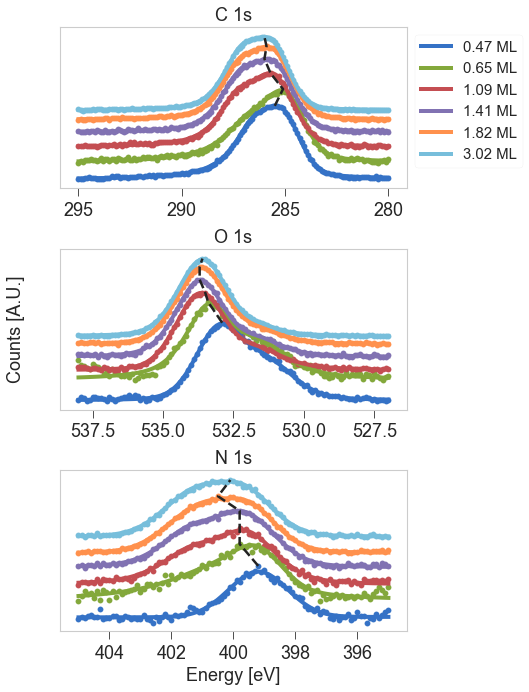

In [141]:
# selection = [xp for xp in fbi_exps if ('7-' in xp.path)]
regions= ['C_1s', 'O_1s', 'N_1s']
coverages = [0.47, 0.65, 1.09, 1.41, 1.82, 3.02]
fig, ax = plt.subplots(3, sharex=False, figsize=(6, 10), )
axx = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
axx.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Energy [eV]")
plt.ylabel("Counts [A.U.]")

seps = [286.5, 532, 401]
for j,r in enumerate(regions):
    enmx, comx = [], []
    for i, xp in enumerate(norm_sel):
#         k, l = j%2, j//2
#         Fn = XPFit(xp, region = r)
#         Fn.double_voigt(sepPt=seps[j])
        li, off = plot_fit_result(xp, r, fitRes=xp.fit[r], ax=ax[j], flag_fill=True, offset=1+8*i/10, plot_comps=False)
        argmx = np.argmax(xp.dfx[r].counts)

        enmx.append(xp.dfx[r].energy.loc[argmx])
        comx.append(xp.dfx[r].counts.loc[argmx] + off)
    ax[j].plot(enmx, comx, '--', lw=2.5)
    ax[j].set(title=r.replace('_', ' '), xlabel='', ylabel='', yticks=[])
    ax[j].invert_xaxis()

plt.tight_layout(w_pad=0.5, h_pad=0.5, pad=0.1)     #  First manage the space and THEN add the legend
ax[0].legend(list(li.get_lines()), labels = [str(cov) + ' ML' for cov in coverages], ncol=1,
            loc="upper left", bbox_to_anchor=(1., 1.))           

fig.savefig('/Users/pabloherrero/Dropbox/phd/drafts/fbi_cu_sublimation/v3/fbi_coverage_all_norm.png', dpi=200, bbox_inches = 'tight')

In [ ]:
tsubl4 = [5, 10, 15, 20, 5, 15, 60, 2.5]
matrix([[6.51323846e-01, 1.16140270e-03],
        [1.08637052e+00, 3.27288126e-03],
        [1.41274162e+00, 3.49811320e-03],
        [1.82644117e+00, 3.82795998e-03],
        [7.24651170e-01, 1.30998972e-03],
        [1.54539729e+00, 3.59823743e-03],
        [3.02141495e+00, 5.11686513e-03],
        [4.75515898e-01, 8.51986016e-04]])
coverages = [0.47, 0.65, 1.09, 1.41, 1.82, 3.02]

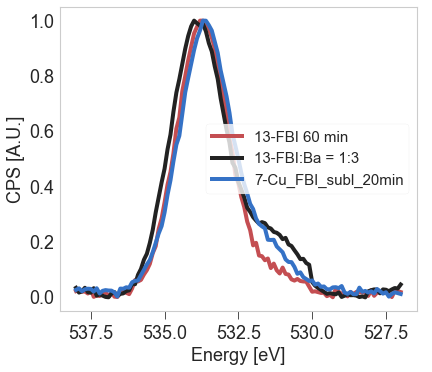

In [128]:
color = ['r', 'k', 'b']
for i,xp in enumerate([progba[0], progba[-1], selection[3]]):
    xpn = normalise_dfx(xp)
    plot_region(xpn, 'O_1s', col=color[i])

## Progressive barium

In [123]:
for xp in progba:
    xp.name = xp.name[3:]

progba[0].name = 'FBI:Ba = 1:0'

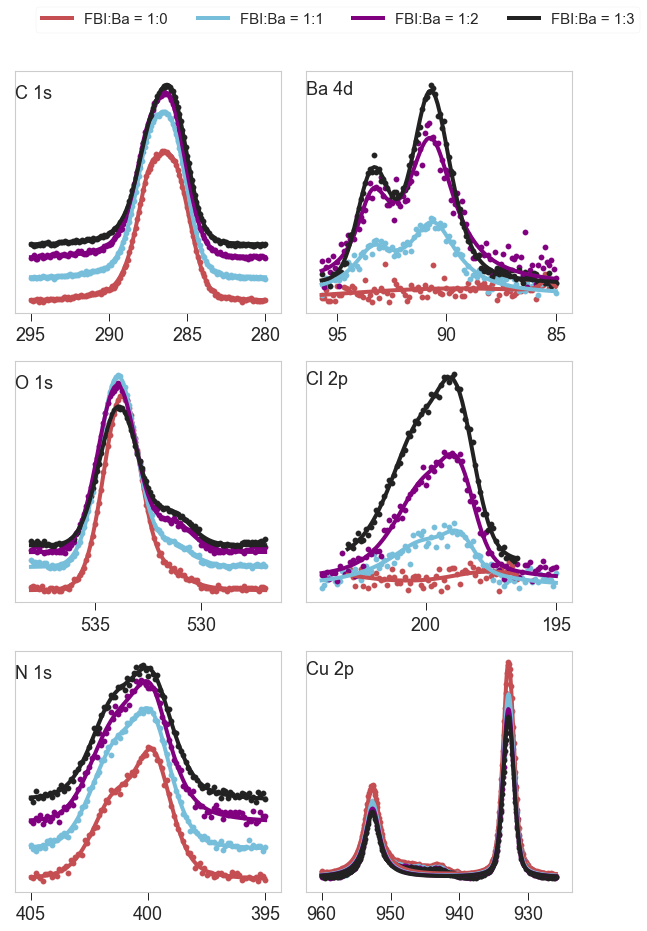

In [127]:
fig, ax = plt.subplots(3, 2, sharex=False, figsize=(8, 12), )

reg2 = ['C_1s', 'O_1s', 'N_1s']
seps = [286.5, 532, 401]
for j,r in enumerate(reg2):
    for i, xp in enumerate(progba):
#         xp = normalise_dfx(xpo)
        Fn = XPFit(xp, region = r)
        Fn.double_voigt(sepPt=seps[j])
        plot_fit_result(xp, r, fitRes=xp.fit[r], ax=ax[j][0], offset=1+5*i/10,
                        flag_fill=True, plot_comps=False)
    ax[j][0].set(xlabel='', ylabel='', yticks=[])
    ax[j][0].invert_xaxis()
    ax[j][0].text(s=r.replace('_', ' '), x=(ax[j][0].get_xlim()[0]), y=(ax[j][0].get_ylim()[1]*0.9))
    ax[j][0].minorticks_on()
    ax[j][0].tick_params('both', length=8, width=1, which='major')



reg1 = ['Ba_4d', 'Cl_2p', 'Cu_2p']
for j,r in enumerate(reg1):
    for i,xp in enumerate(progba):
        li = plot_fit_result(xp, r, fitRes=xp.fit[r], ax=ax[j][1], flag_fill=True, plot_comps=False)
    ax[j][1].set( xlabel='', ylabel='', yticks=[])
    ax[j][1].invert_xaxis()
    ax[j][1].tick_params('both', length=8, width=1, which='major')
    ax[j][1].text(s=r.replace('_', ' '), x=(ax[j][1].get_xlim()[0]), y=(ax[j][1].get_ylim()[1]*0.9))
    
# ax[0][0].set(ylabel='Counts [A.U.]')
# ax[1][0].set(ylabel='Counts [A.U.]')
# ax[1][1].set(xlabel='Energy [eV]')

plt.tight_layout(w_pad=0.5, h_pad=0.5, pad=0.1)
ax[0][0].legend(list(li.get_lines()), labels = [xp.name for xp in progba], ncol=len(selection),
            loc="upper left", bbox_to_anchor=(0.05, 1.3))           

fig.savefig('/Users/pabloherrero/Dropbox/phd/drafts/fbi_cu_sublimation/v3/fbi_prog_ba.png', dpi=200, bbox_inches = 'tight')

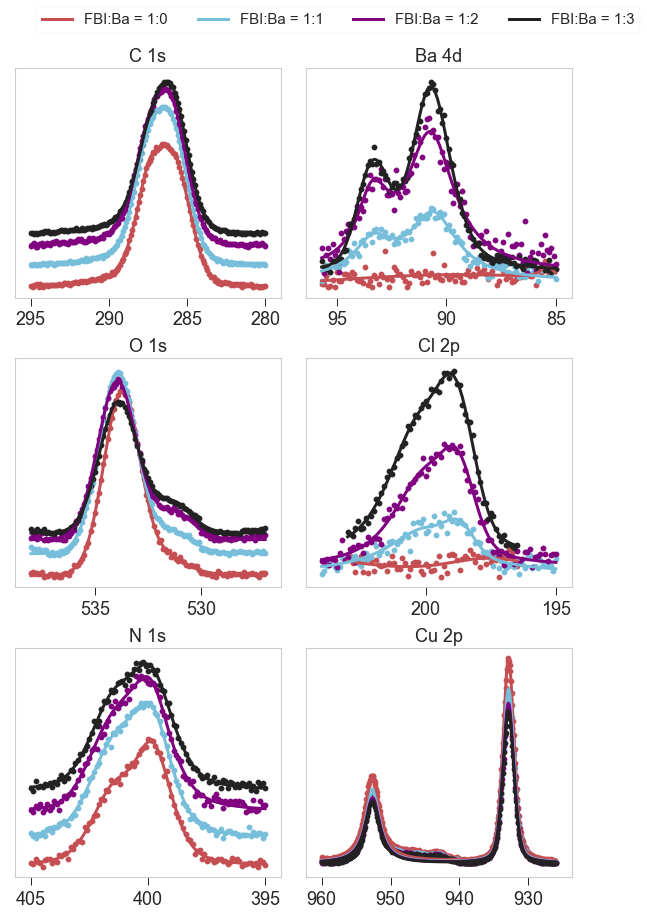

In [67]:
fig, ax = plt.subplots(3, 2, sharex=False, figsize=(8, 12), )

reg2 = ['C_1s', 'O_1s', 'N_1s']
seps = [286.5, 532, 401]
for j,r in enumerate(reg2):
    for i, xp in enumerate(progba):
#         xp = normalise_dfx(xpo)
        Fn = XPFit(xp, region = r)
        Fn.double_voigt(sepPt=seps[j])
        plot_fit_result(xp, r, fitRes=xp.fit[r], ax=ax[j][0], offset=1+5*i/10,
                        flag_fill=True, plot_comps=False)
    ax[j][0].set(title=r.replace('_', ' '), xlabel='', ylabel='', yticks=[])
    ax[j][0].invert_xaxis()
    ax[j][0].minorticks_on()
    ax[j][0].tick_params('both', length=8, width=1, which='major')


reg1 = ['Ba_4d', 'Cl_2p', 'Cu_2p']
for j,r in enumerate(reg1):
    for i,xp in enumerate(progba):
        li = plot_fit_result(xp, r, fitRes=xp.fit[r], ax=ax[j][1], flag_fill=True, plot_comps=False)
    ax[j][1].set(title=r.replace('_', ' '), xlabel='', ylabel='', yticks=[])
    ax[j][1].invert_xaxis()
    ax[j][1].tick_params('both', length=8, width=1, which='major')
    
# ax[0][0].set(ylabel='Counts [A.U.]')
# ax[1][0].set(ylabel='Counts [A.U.]')
# ax[1][1].set(xlabel='Energy [eV]')

plt.tight_layout(w_pad=0.5, h_pad=0.5, pad=0.1)
ax[0][0].legend(list(li.get_lines()), labels = [xp.name for xp in progba], ncol=len(selection),
            loc="upper left", bbox_to_anchor=(0.05, 1.3))           

# fig.savefig('/Users/pabloherrero/Dropbox/phd/papers/fbi_cu_sublimation/v3/fbi_prog_ba.png', dpi=200, bbox_inches = 'tight')

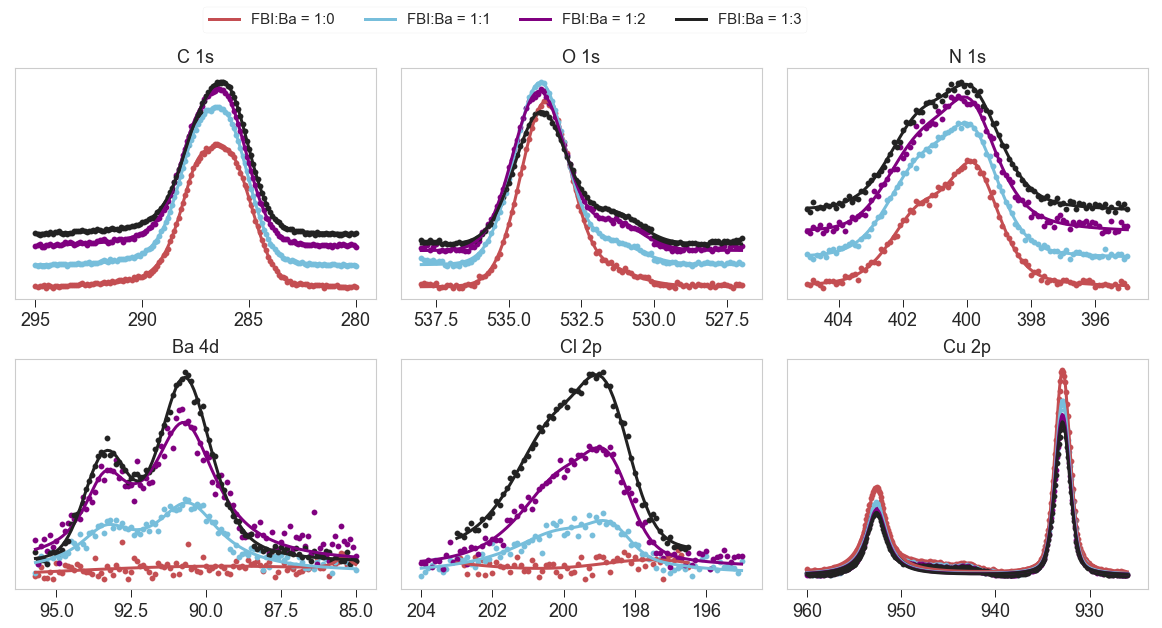

In [163]:
fig, ax = plt.subplots(2, 3, sharex=False, figsize=(16, 8), )

reg2 = ['C_1s', 'O_1s', 'N_1s']
seps = [286.5, 532, 401]
for j,r in enumerate(reg2):
    for i, xp in enumerate(progba):
#         xp = normalise_dfx(xpo)
        Fn = XPFit(xp, region = r)
        Fn.double_voigt(sepPt=seps[j])
        plot_fit_result(xp, r, fitRes=xp.fit[r], ax=ax[0][j], offset=1+5*i/10,
                        flag_fill=True, plot_comps=False)
    ax[0][j].set(title=r.replace('_', ' '), xlabel='', ylabel='', yticks=[])
    ax[0][j].invert_xaxis()
    ax[0][j].minorticks_on()
    ax[0][j].tick_params('both', length=8, width=1, which='major')

reg1 = ['Ba_4d', 'Cl_2p', 'Cu_2p']
for j,r in enumerate(reg1):
    for i,xp in enumerate(progba):
        li = plot_fit_result(xp, r, fitRes=xp.fit[r], ax=ax[1][j], flag_fill=True, plot_comps=False)
    ax[1][j].set(title=r.replace('_', ' '), xlabel='', ylabel='', yticks=[])
    ax[1][j].invert_xaxis()
    ax[1][j].tick_params('both', length=8, width=1, which='major')

plt.tight_layout(w_pad=0.5, h_pad=0.5, pad=0.1)
ax[0][0].legend(list(li.get_lines()), labels = [xp.name for xp in progba], ncol=len(selection),
            loc="upper left", bbox_to_anchor=(0.5, 1.3))  

## Coverages plots

In [306]:
path = '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021*/**/*.uxy'

files = glob.glob(path, recursive=True)
files.sort()
ffi = []
for f in files:
    if 'calibration' not in f:
        ffi.append(f)

files = ffi
files

cu_exps = [read_processed_xp(f) for f in files]


[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_18_Cu/proc/20210119_7-Cu_FBI_subl_05min.uxy.ft', returning empty fit dict
[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_18_Cu/proc/20210119_7-Cu_FBI_subl_10min.uxy.ft', returning empty fit dict
[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_18_Cu/proc/20210119_7-Cu_FBI_subl_15min.uxy.ft', returning empty fit dict
[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_18_Cu/proc/20210119_7-Cu_FBI_subl_20min.uxy.ft', returning empty fit dict
[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_18_Cu/proc/20210119_7-Cu_clean.uxy.ft', returning empty fit dict
[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_01_21_Cu/proc/20210121_8-Cu_FBI_subl_05min

In [255]:
def guess_clean_xp(exp_set):
    lref = []
    li = []
    for i, xp in enumerate(exp_set):
        if 'clean' in xp.name: lref.append(i)
        else: li.append(i)
    if len(lref) == 1:
        inds = li + lref
        return inds
    elif len(lref) < 1:
        print('Did not find clean experiments in this set!')
    else:
        print('Too many clean experiments!')
        
def arrange_coverages(experiments: list, inds: list,
                      r_ml: float, region: str, mfp: float, takeoff: float)->np.matrix:
    """Estimate n_layers for a list of experiments following the indices inds
    Parameters:
     - experiments: list of XPS_experiment to look into
     - inds: list of indices. It must be arranged such that each set of measurements
             has its reference (clean substrate) index at the end of each list.
             Example:  inds = [[0,1,2,3,5,7,8, 4], [9, 10]]
             will take experiments[4] as clean_substrate, and compute the thickness of experiments[0],
             experiments[1], experiments[2]... Then it will take experiments[10] as clean_substrate and
             compute the thickness for experiments[9]
     - all other params must be passed as for n_layers
    Returns:
        layers_res: matrix (M x 2), with column 0 is the mean value of n_layers and column 1 its error, and
        where M is the number of experiments passed for computation.
    """
    layers_res = []
    for lref in inds:
        try:
            for li in lref[:-1]:
                layi = n_layers(xpf=experiments[li], xp0=experiments[lref[-1]],
                                           r_ml = r_ml, region=region, mfp=mfp, takeoff=takeoff) 
                experiments[li].area['layers'] = layi[0]
                experiments[li].area['dlayers'] = layi[1]
                
                layers_res.append(layi)
        except TypeError:
            pass
    layers_res = np.matrix(layers_res)
    return layers_res

def plot_coverages(experiments):
    layers, dlayers = [], []
    names = []
    for xp in experiments:
        try:
            layers.append(xp.area['layers'])
            dlayers.append(xp.area['dlayers'])
            names.append(xp.name)
        except KeyError:
            pass

    ax = plt.gca()
    ax.errorbar(x=names, y=layers, yerr=dlayers, fmt='o', label='Rate $R_0$')
    ax.set_ylabel('Layers')
    plt.draw()
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.legend()

In [375]:
nrexp = [int(re.findall('[0-9]+-', cu_exps[0].name)[0][:-1])]
exp_set = []
inds = []
for i, xp in enumerate(cu_exps):
    try:  # Locate the number of sample: xp.name should start f.ex. by '8-Cu_FBI...' 
        nr = int(re.findall('[0-9]+[-,_]', xp.name)[0][:-1])
    except IndexError: # If incorrect format, skip this xp
        print('Warning: incorrect xp.name format for', xp.name)
        nr = 10
    
    if nr == nrexp[-1]:
        exp_set.append(xp)
    else:
        print('Exp_set:', [xp.name for xp in exp_set])
        inds = guess_clean_xp(exp_set)
        print(inds)
        arrange_coverages(exp_set, [inds], 
                         r_ml = 1.1*nm, region='Cu_2p', mfp = 1.85*nm, takeoff = 10)
        nrexp.append(nr)
        exp_set = [xp]
print('Exp_set:', [xp.name for xp in exp_set])

inds = guess_clean_xp(exp_set) # Last exp_set is not accounted for with the else
arrange_coverages(exp_set, [inds],
                 r_ml = 1.1*nm, region='Cu_2p', mfp = 1.85*nm, takeoff = 10)

Exp_set: ['7-Cu_FBI_subl_5min', '7-Cu_FBI_subl_10min', '7_Cu-FBI_subl_15min', '7-Cu_FBI_subl_20min', '7-Cu_clean']
[0, 1, 2, 3, 4]
Exp_set: ['8-Cu_FBI_subl_05min', '8-Cu_clean', '8-Cu_FBI_subl_15min', '8-Cu_FBI_subl_60min']
[0, 2, 3, 1]
Exp_set: ['9-Cu_FBI_subl_2p5min', '9-Cu_clean']
[0, 1]
Exp_set: ['11-FBI 20min', '11-FBI 20min, BaCl$_2$ 2min', '11-Cu_clean']
[0, 1, 2]
Exp_set: ['12-FBI 20min', '12-FBI 20min, BaCl$_2$ 4min', '12-Cu_clean']
[0, 1, 2]
Exp_set: ['13-FBI 60 min', '"13-FBI:Ba', '"13-FBI:Ba', '"13-FBI:Ba', '13-Cu_clean']
[0, 1, 2, 3, 4]
Exp_set: ['14-FBI 8min', '14-FBI 8min, BaCl$_2$ 1min', '14-Cu_clean2']
[0, 1, 2]
Exp_set: ['16-Cu_clean', '16-Cu_FBI_subl_15min', '16-Cu_FBI_subl_22min', '16-Cu_FBI_subl_8min']


matrix([[0.46099815, 0.00147795],
        [0.57469614, 0.00187683],
        [0.20595483, 0.00063701]])

In [280]:
n_layers(xpf=cu_exps[5], xp0=cu_exps[6],
        r_ml = 1.1*nm, region='Cu_2p', mfp=1.85*nm, takeoff=10) 

(-1.4508434718750405, -0.0032895929623820465)

In [376]:
for xp in cu_exps:
    try:
        print(xp.name, xp.area['layers'])
    except KeyError: pass

7-Cu_FBI_subl_5min 0.6487437979940064
7-Cu_FBI_subl_10min 1.0805298212261916
7_Cu-FBI_subl_15min 1.4051462373885322
7-Cu_FBI_subl_20min 1.816621594559621
8-Cu_FBI_subl_05min 0.10251184906466321
8-Cu_FBI_subl_15min 1.0043494358994436
8-Cu_FBI_subl_60min 2.4436725806627115
9-Cu_FBI_subl_2p5min 0.473632266606096
11-FBI 20min 0.4991203191279348
11-FBI 20min, BaCl$_2$ 2min 0.5493118418479295
12-FBI 20min 0.44720971100225965
12-FBI 20min, BaCl$_2$ 4min 0.5016757846423242
13-FBI 60 min 0.8954621458661511
"13-FBI:Ba 1.1429712569462513
"13-FBI:Ba 1.2644100132637135
"13-FBI:Ba 1.3265161850773732
14-FBI 8min 0.1214782927703221
14-FBI 8min, BaCl$_2$ 1min 0.1723018213130005
16-Cu_FBI_subl_15min 0.4609981536902545
16-Cu_FBI_subl_22min 0.5746961428543874
16-Cu_FBI_subl_8min 0.20595483448625806


In [ ]:
coverages = [0.47, 0.65, 1.09, 1.41, 1.82, 3.02]


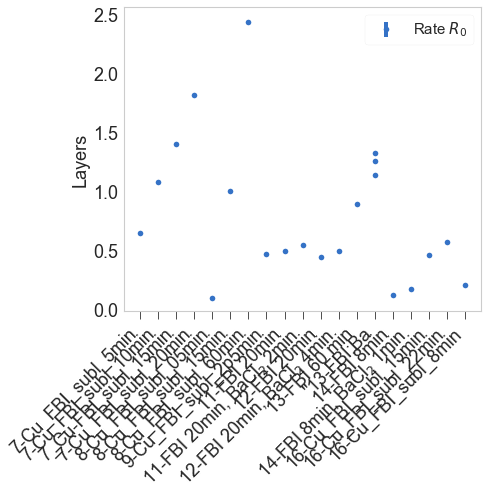

In [377]:
plot_coverages(cu_exps)

# Sub-ML fits

### N 1s

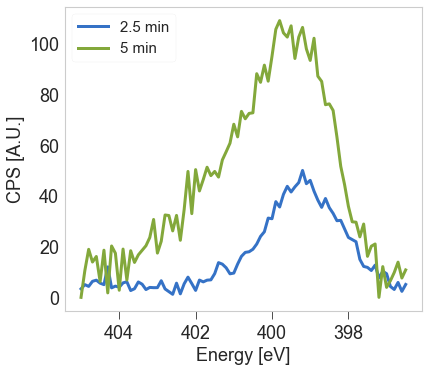

In [136]:
for xp in selection[:2]:
    xp = crop_spectrum(xp, region, edw=396.5, inplace=True)
    plot_region(xp, region)
cosmetics_plot()

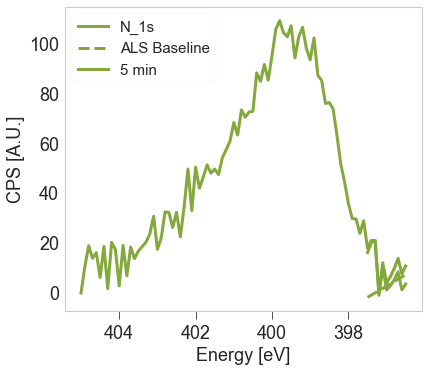

In [156]:
fix_tail_bg(selection[1], region, eup=397.5, inplace=True);

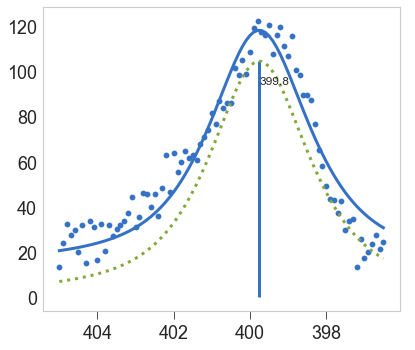

In [129]:
region = 'N_1s'
Fn = XPFit(selection[1], region=region)
# Fn.preset_pars(key='v1_fraction', val=0.9)

Fn.voigt()#(sepPt=398)
plot_fit_result(selection[1], region, fitRes=selection[1].fit[region])
plt.gca().invert_xaxis()

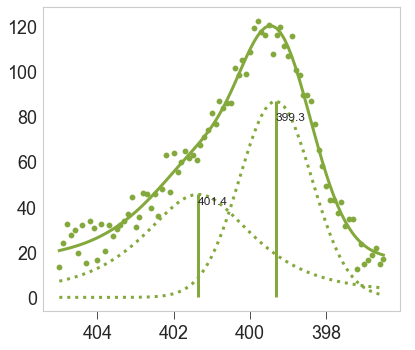

In [157]:
region = 'N_1s'
Fn = XPFit(selection[1], region=region)
# Fn.preset_pars(key='v1_fraction', val=0.9)

Fn.double_voigt(sepPt=401)
plot_fit_result(selection[1], region, fitRes=selection[1].fit[region])
Fn.set_areas()
plt.gca().invert_xaxis()

In [139]:
selection[1].area['N_1s_v1_'], selection[1].area['N_1s_v2_']

(0.4784884786777459, 0.5215115213222541)

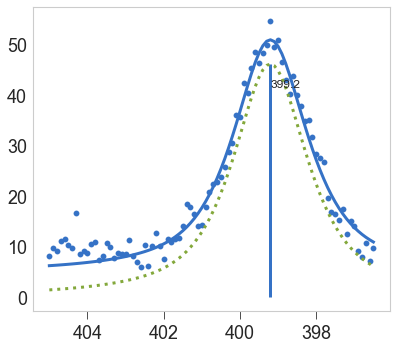

In [134]:
region = 'N_1s'
Fn = XPFit(selection[0], region=region)
# Fn.preset_pars(key='v1_fraction', val=0.9)

Fn.voigt()#(sepPt=398)
plot_fit_result(selection[0], region, fitRes=selection[0].fit[region])
plt.gca().invert_xaxis()

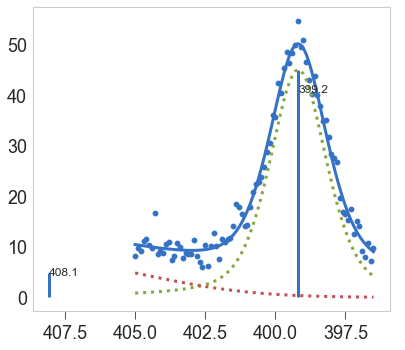

In [137]:
region = 'N_1s'
Fn = XPFit(selection[0], region=region)
# Fn.preset_pars(key='v1_fraction', val=0.9)

Fn.double_voigt(sepPt=400)
plot_fit_result(selection[0], region, fitRes=selection[0].fit[region])
plt.gca().invert_xaxis()

In [141]:
selection[0].color = 'b'
selection[1].color = 'g'

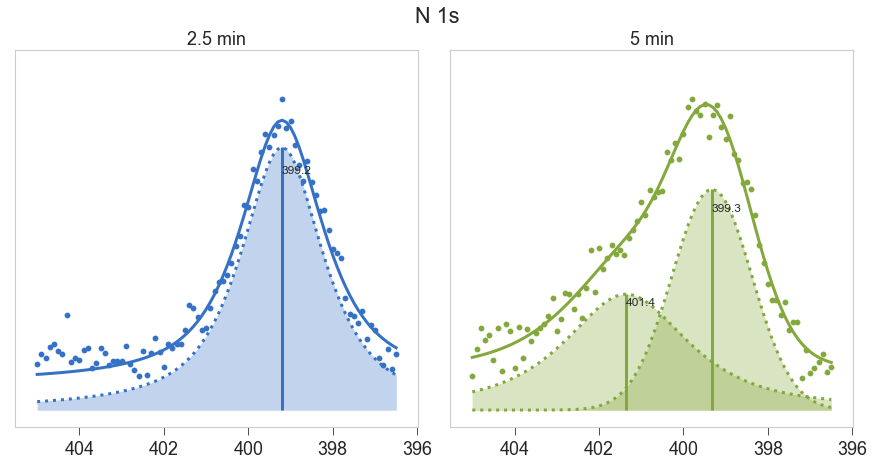

In [158]:
fig, ax = plt.subplots(1, 2, sharex=True, figsize=(12, 6 ), )

region = 'N_1s'

for i,xp in enumerate(selection[:2]):
    Fn = XPFit(xp, region=region)
    if i == 0:
        Fn.voigt()
    else:
        Fn.double_voigt(sepPt=401)
    plot_fit_result(xp, region, fitRes=xp.fit[region], ax=ax[i], flag_fill=True)
    ax[i].set( yticks=[], ylim=tuple([yl * 1.1 for yl in ax[i].get_ylim()]), title=xp.name)
    Fn.set_areas()
ax[i].invert_xaxis()
plt.tight_layout(w_pad=0.5, h_pad=0.5, pad=0.1)
fig.suptitle('N 1s', y=1.05)
ax[i].set(xlabel='', ylabel='')
plt.subplots_adjust(hspace=.0)
plt.subplots_adjust(wspace=.08)
# plt.gcf().savefig('/Users/pabloherrero/Dropbox/phd/papers/fbi_cu_sublim_v2/fits_n1s.png', dpi=200)

### Sample 14: 8 min FBI + 1 min BaCl2

In [68]:
xpba[-1].color = 'c'
lowcov = [xpfbi[-1], xpba[-1]]


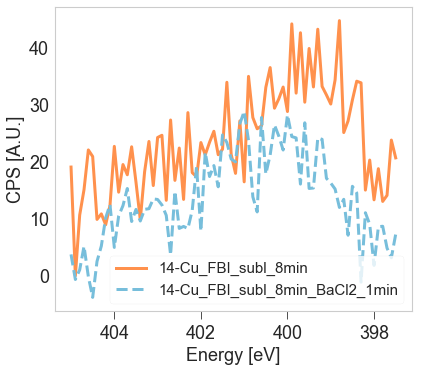

In [243]:
region = 'N_1s'
for xp in lowcov:
    xp = crop_spectrum(xp, region, edw=397.5, inplace=True)
    plot_region(xp, region)
cosmetics_plot()

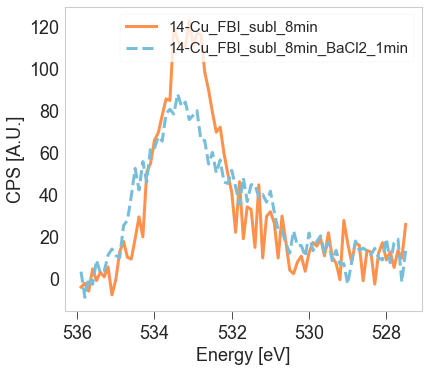

In [247]:
region = 'O_1s'
for xp in lowcov:
    xp = crop_spectrum(xp, region, eup=535.9
                       , edw=527.5, inplace=True)
    plot_region(xp, region)
cosmetics_plot()

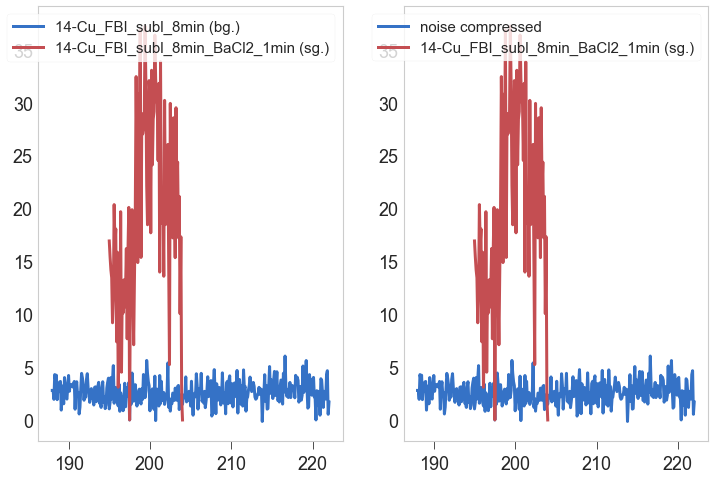

In [251]:
compress_noisy_region(lowcov[0], xpRef=lowcov[1], region='Cl_2p', inplace=True);

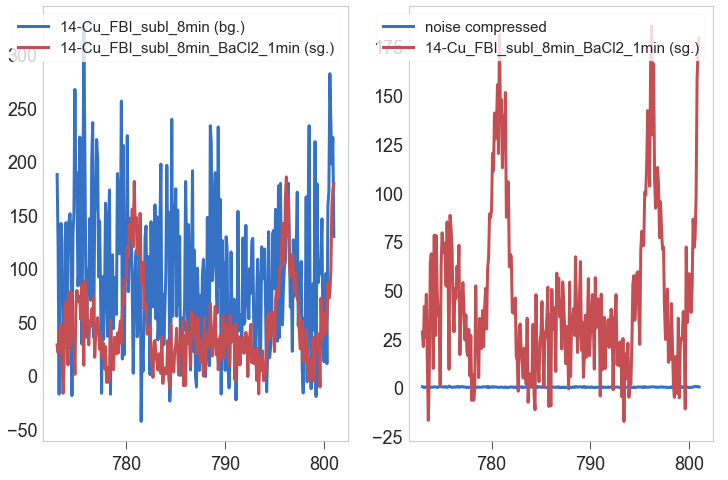

In [252]:
compress_noisy_region(lowcov[0], xpRef=lowcov[1], region='Ba_3d', inplace=True);

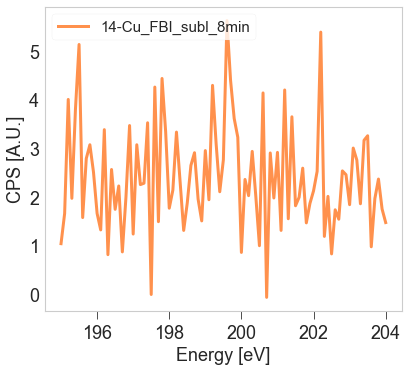

In [255]:
region = 'Cl_2p'
trim_spectra(lowcov[0], xpRef=lowcov[1], region=region, inplace=True)
plot_region(lowcov[0], region)
cosmetics_plot()

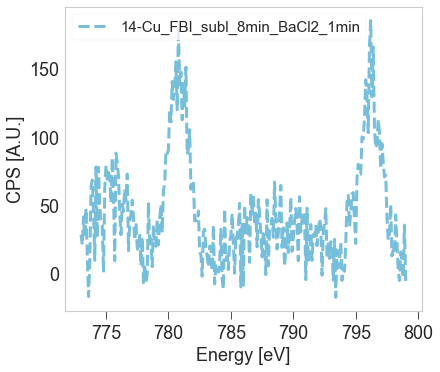

In [258]:
region = 'Ba_3d'
xp = crop_spectrum(lowcov[1], region=region,
              eup=799, inplace=True)
plot_region(xp, region)
cosmetics_plot()

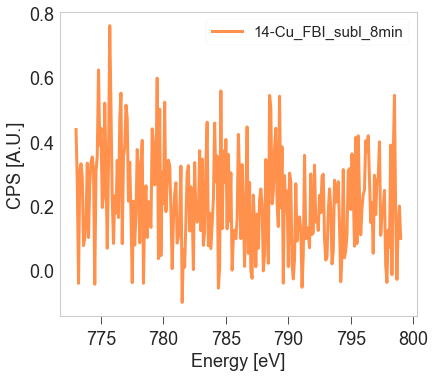

In [259]:
region = 'Ba_3d'
trim_spectra(lowcov[0], xpRef=lowcov[1], region=region, inplace=True)
plot_region(lowcov[0], region)
cosmetics_plot()

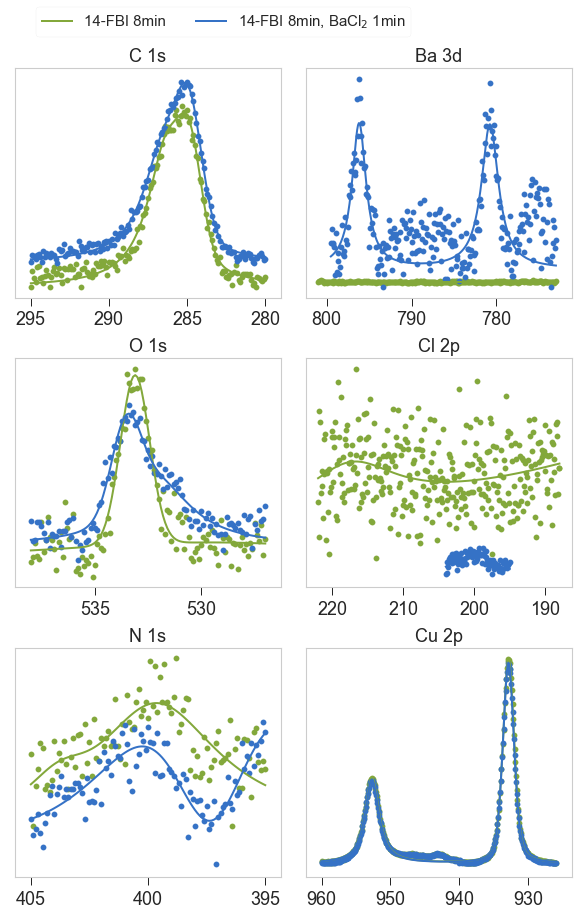

In [286]:
fig, ax = plt.subplots(3, 2, sharex=False, figsize=(8, 12), )
lowcov = [xpfbi[-1], xpba[-1]]
reg2 = ['C_1s', 'O_1s', 'N_1s']
seps = [286.5, 532, 401]
for j,r in enumerate(reg2):
    for i, xp in enumerate(lowcov):
#         xp = normalise_dfx(xpo)
        Fn = XPFit(xp, region = r)
        Fn.double_voigt(sepPt=seps[j])
        plot_fit_result(xp, r, fitRes=xp.fit[r], ax=ax[j][0], offset=1+5*i/10,
                        flag_fill=True, plot_comps=False)
    ax[j][0].set(title=r.replace('_', ' '), xlabel='', ylabel='', yticks=[])
    ax[j][0].invert_xaxis()
    ax[j][0].minorticks_on()
    ax[j][0].tick_params('both', length=8, width=1, which='major')

reg1 = ['Ba_3d', 'Cl_2p', 'Cu_2p']
seps = [790, 199, 950]
for j,r in enumerate(reg1):
    for i,xp in enumerate(lowcov):
        Fn = XPFit(xp, region = r)
        Fn.double_voigt(sepPt=seps[j])
        li = plot_fit_result(xp, r, fitRes=xp.fit[r], ax=ax[j][1], flag_fill=True, plot_comps=False)
    ax[j][1].set(title=r.replace('_', ' '), xlabel='', ylabel='', yticks=[])
    ax[j][1].invert_xaxis()
    ax[j][1].tick_params('both', length=8, width=1, which='major')

plt.tight_layout(w_pad=0.5, h_pad=0.5, pad=0.1)
ax[0][0].legend(list(li.get_lines()), labels = [xp.name for xp in lowcov], ncol=len(lowcov),
            loc="upper left", bbox_to_anchor=(0.05, 1.3))           

# fig.savefig('/Users/pabloherrero/Dropbox/phd/papers/fbi_cu_sublimation/v3/fbi_prog_ba.png', dpi=200, bbox_inches = 'tight')

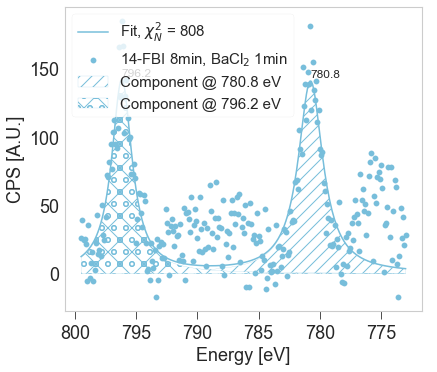

In [69]:
region = 'Ba_3d'
pars1 = []

Fn = XPFit(lowcov[1], region)
fitv = Fn.double_voigt(sepPt=790)
Fn.plot()